# Group 2: Dekker, Hauser, Tassone, Vogel

## 1. Introductory Part
e.g. loading packages, reading data, EDA

In [1]:
##### packages
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


import math
import matplotlib
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import pingouin as pg
from pingouin import multivariate_normality
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn import metrics
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import resample


import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base


from missingpy import MissForest
from impyute.imputation.cs import mice
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.utils.fixes import loguniform
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
import random as rd
from sklearn.metrics import confusion_matrix
import itertools
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier as GBC

/Users/lukasdekker/opt/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.3.11.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
##### reading the data
df14 = pd.read_csv('https://raw.githubusercontent.com/AtK42/ML_stonks_2021/main/Data/2014_Financial_Data.csv')
df15 = pd.read_csv('https://raw.githubusercontent.com/AtK42/ML_stonks_2021/main/Data/2015_Financial_Data.csv')
df16 = pd.read_csv('https://raw.githubusercontent.com/AtK42/ML_stonks_2021/main/Data/2016_Financial_Data.csv')
df17 = pd.read_csv('https://raw.githubusercontent.com/AtK42/ML_stonks_2021/main/Data/2017_Financial_Data.csv')
df18 = pd.read_csv('https://raw.githubusercontent.com/AtK42/ML_stonks_2021/main/Data/2018_Financial_Data.csv')

df_sp500 = pd.read_csv('https://raw.githubusercontent.com/AtK42/ML_stonks_2021/main/Data/sp-500-historical-annual-returns-modified.csv')



In [3]:
##### df manipulation

#add column with year
df14['year'] = 2014
df15['year'] = 2015
df16['year'] = 2016
df17['year'] = 2017
df18['year'] = 2018

#add column for recommendation
df14['recommendation'] = 0
df15['recommendation'] = 0
df16['recommendation'] = 0
df17['recommendation'] = 0
df18['recommendation'] = 0

#rename 'Price Var' col
df14.rename(columns={"2015 PRICE VAR [%]": "PRICE_VAR", "Unnamed: 0":"Stock"},inplace=True)
df15.rename(columns={"2016 PRICE VAR [%]": "PRICE_VAR", "Unnamed: 0":"Stock"},inplace=True)
df16.rename(columns={"2017 PRICE VAR [%]": "PRICE_VAR", "Unnamed: 0":"Stock"},inplace=True)
df17.rename(columns={"2018 PRICE VAR [%]": "PRICE_VAR", "Unnamed: 0":"Stock"},inplace=True)
df18.rename(columns={"2019 PRICE VAR [%]": "PRICE_VAR", "Unnamed: 0":"Stock"},inplace=True)

# df14.index = df14.Stock
# df15.index = df15.Stock
# df16.index = df16.Stock
# df17.index = df17.Stock
# df18.index = df18.Stock


#create a list with all raw data
df_all = pd.concat([df14, df15, df16, df17, df18], ignore_index=True)

In [4]:
##### Classifiaction (1: buy, 0: hold, -1: sell)
sp500_14 = df_sp500.iloc[0,1]
sp500_15 = df_sp500.iloc[1,1]
sp500_16 = df_sp500.iloc[2,1]
sp500_17 = df_sp500.iloc[3,1]
sp500_18 = df_sp500.iloc[4,1]

conditions_y = [(df_all['year']==2014),
                (df_all['year']==2015),
                (df_all['year']==2016),
                (df_all['year']==2017),
                (df_all['year']==2018)]

values_y = [sp500_14, sp500_15, sp500_16, sp500_17, sp500_18]

#insert the according sp500 return to the corresponding year
df_all['sp500'] = np.select(conditions_y, values_y)

# calculate recommendation value
lower_bound = -2.5
upper_bound = 2.5

conditions_r = [((df_all['PRICE_VAR'] - df_all['sp500']) > upper_bound),
                ((df_all['PRICE_VAR'] - df_all['sp500']) < lower_bound),
                ((df_all['PRICE_VAR'] - df_all['sp500']) <= upper_bound) & ((df_all['PRICE_VAR'] - df_all['sp500']) >= lower_bound)]
values_r = ['1', '-1', '0']

#assign 1, -1, 0 depending on the surplus yield of a stock
df_all['recommendation'] = np.select(conditions_r, values_r)
df_all['recommendation'] = df_all['recommendation'].astype('category')
df_all['recommendation'].value_counts()
    #minor EDA that counts the frequency of the different categories
    


# drop column sp500
df_all = df_all.drop(df_all.columns[-1], axis=1)
df_all.head()


-1    11278
1      9738
0      1061
Name: recommendation, dtype: int64

,Stock,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,PRICE_VAR,Class,year,recommendation
0,PG,7.440100e+10,-0.0713,3.903000e+10,3.537100e+10,0.000000e+00,2.146100e+10,2.146100e+10,1.391000e+10,7.090000e+08,...,0.0359,0.0316,0.1228,0.0000,-0.1746,Consumer Defensive,-9.323276,0,2014,-1
1,VIPS,3.734148e+09,1.1737,2.805625e+09,9.285226e+08,1.083303e+08,3.441414e+08,7.939267e+08,1.345959e+08,1.214869e+07,...,NaN,NaN,NaN,1.6484,1.7313,Consumer Defensive,-25.512193,0,2014,-1
2,KR,9.837500e+10,0.0182,7.813800e+10,2.023700e+10,0.000000e+00,1.519600e+10,1.751200e+10,2.725000e+09,4.430000e+08,...,0.1886,0.3268,0.2738,0.0000,0.0234,Consumer Defensive,33.118297,1,2014,1
3,RAD,2.552641e+10,0.0053,1.820268e+10,7.323734e+09,0.000000e+00,6.561162e+09,6.586482e+09,7.372520e+08,4.245910e+08,...,-0.0189,0.1963,-0.0458,0.0000,-0.0060,Consumer Defensive,2.752291,1,2014,-1
4,GIS,1.790960e+10,0.0076,1.153980e+10,6.369800e+09,0.000000e+00,3.474300e+09,3.412400e+09,2.957400e+09,3.024000e+08,...,0.0215,0.0274,0.1025,0.0000,-0.0220,Consumer Defensive,12.897715,1,2014,0


In [5]:
##### some minor EDA

df14.columns
df14.info() #we have mostly floats, but also 3 integer variables and 2 object variables (possible to use e.g. 'One-Hot-Encoding' or 'LabelEncoding' for object variable)
df14['Class']
df14.describe()

#check which are the integer and object variables
df14.select_dtypes(include = ['integer']) #class, year & recommendation
df14.select_dtypes(include = ['object']) #sector

#having a look at the other years
df15.info()
df16.info()
df17.info()
df18.info()

#dimensions for each data set
year = 14
for el in [df14, df15, df16, df17, df18]:
    print(year, el.shape)
    year += 1

Index(['Stock', 'Revenue', 'Revenue Growth', 'Cost of Revenue', 'Gross Profit',
       'R&D Expenses', 'SG&A Expense', 'Operating Expenses',
       'Operating Income', 'Interest Expense',
       ...
       'Asset Growth', 'Book Value per Share Growth', 'Debt Growth',
       'R&D Expense Growth', 'SG&A Expenses Growth', 'Sector', 'PRICE_VAR',
       'Class', 'year', 'recommendation'],
      dtype='object', length=227)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3808 entries, 0 to 3807
Columns: 227 entries, Stock to recommendation
dtypes: float64(222), int64(3), object(2)
memory usage: 6.6+ MB


0       0
1       0
2       1
3       1
4       1
       ..
3803    1
3804    0
3805    0
3806    1
3807    0
Name: Class, Length: 3808, dtype: int64

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,PRICE_VAR,Class,year,recommendation
count,3.764000e+03,3572.000000,3.734000e+03,3.756000e+03,3.672000e+03,3.749000e+03,3.745000e+03,3.753000e+03,3.745000e+03,3.728000e+03,...,3518.000000,3518.000000,3439.000000,3506.000000,3561.000000,3565.000000,3.808000e+03,3808.000000,3808.0,3808.0
mean,5.879050e+09,12.954244,3.700973e+09,2.188214e+09,9.401830e+07,9.307406e+08,1.438144e+09,6.748248e+08,1.002018e+08,5.725866e+08,...,0.164692,2.279999,0.813931,1.361780,0.596529,0.382284,9.751560e+02,0.429097,2014.0,0.0
std,3.901741e+10,705.605473,3.040688e+10,1.159028e+10,6.408912e+08,4.820928e+09,7.305171e+09,3.786291e+09,6.991091e+08,2.793740e+09,...,2.195115,92.428920,25.630214,18.734301,25.894049,4.696975,4.098461e+04,0.495012,0.0,0.0
min,-6.276160e+08,-1.773200,-5.455740e+08,-1.105000e+09,-1.500000e+05,0.000000e+00,-1.088448e+09,-6.786000e+09,-2.250000e+08,-8.878000e+09,...,-1.000000,-0.979600,-230.000000,-1.051000,-1.043700,-1.000000,-1.003972e+02,0.000000,2014.0,0.0
25%,5.788880e+07,-0.002350,3.135714e+06,3.092900e+07,0.000000e+00,1.548900e+07,3.106600e+07,-1.308000e+06,0.000000e+00,-3.732902e+06,...,0.000000,-0.015400,-0.084550,-0.048200,0.000000,-0.003900,-2.857143e+01,0.000000,2014.0,0.0
50%,4.349010e+08,0.061850,1.414420e+08,1.908760e+08,0.000000e+00,7.381800e+07,1.386610e+08,4.104400e+07,2.563000e+06,2.842700e+07,...,0.000000,0.062200,0.037100,0.000000,0.000000,0.068800,-5.281842e+00,0.000000,2014.0,0.0
75%,2.393625e+09,0.188875,1.199844e+09,8.922534e+08,9.911000e+06,3.510000e+08,5.885100e+08,2.712980e+08,4.300000e+07,2.193835e+08,...,0.063850,0.217100,0.141900,0.210300,0.004700,0.220500,1.331484e+01,1.000000,2014.0,0.0
max,1.824698e+12,42138.663900,1.537249e+12,4.621600e+11,1.153700e+10,1.856830e+11,3.056050e+11,1.565540e+11,3.152300e+10,8.720500e+10,...,76.625000,5468.426400,1360.125000,729.576600,1542.611000,225.690000,2.418601e+06,1.000000,2014.0,0.0


,Class,year,recommendation
0,0,2014,0
1,0,2014,0
2,1,2014,0
3,1,2014,0
4,1,2014,0
...,...,...,...
3803,1,2014,0
3804,0,2014,0
3805,0,2014,0
3806,1,2014,0


,Stock,Sector
0,PG,Consumer Defensive
1,VIPS,Consumer Defensive
2,KR,Consumer Defensive
3,RAD,Consumer Defensive
4,GIS,Consumer Defensive
...,...,...
3803,TSRI,Technology
3804,TZOO,Technology
3805,USATP,Technology
3806,WSTG,Technology


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4120 entries, 0 to 4119
Columns: 227 entries, Stock to recommendation
dtypes: float64(222), int64(3), object(2)
memory usage: 7.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4797 entries, 0 to 4796
Columns: 227 entries, Stock to recommendation
dtypes: float64(222), int64(3), object(2)
memory usage: 8.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4960 entries, 0 to 4959
Columns: 227 entries, Stock to recommendation
dtypes: float64(222), int64(3), object(2)
memory usage: 8.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4392 entries, 0 to 4391
Columns: 227 entries, Stock to recommendation
dtypes: float64(222), int64(3), object(2)
memory usage: 7.6+ MB
14 (3808, 227)
15 (4120, 227)
16 (4797, 227)
17 (4960, 227)
18 (4392, 227)


## 2. Feature Engineering
### 2.1 Momentum Factor
As Dacheng showed in his paper "Empirical Machine Learning via Asset Pricing", a very strong covariate is the momentum factor. This factor simply represents the past performance of a given stock. In our case we could take the performance of the current year to predict the performance of the next year. It is possible to create even more covariates like change in momentum (chmom) but we will not go further into those.

Problems: Data for 2014 is not available. The amount of stocks in the data set changes every year.
We will have some missing values that we can again impute with a KNN imputer.

In [6]:
#we create numpy arrays that we will fill with the data and then add to the full data set
momentum_2014 = np.empty(shape = df14.shape[0])
momentum_2015 = np.empty(shape = df15.shape[0])
momentum_2016 = np.empty(shape = df16.shape[0])
momentum_2017 = np.empty(shape = df17.shape[0])
momentum_2018 = np.empty(shape = df18.shape[0])

momentum_2014[:] = np.NAN
momentum_2015[:] = np.NAN
momentum_2016[:] = np.NAN
momentum_2017[:] = np.NAN
momentum_2018[:] = np.NAN


#we take the available data and fill them into the momentum arrays
#2015
i = 0
for stock in df15.index:
    if stock in df14.index:
        momentum_2015[i] = df14['PRICE_VAR'][stock]
    i+=1
    
#2016
i = 0
for stock in df16.index:
    if stock in df15.index:
        momentum_2016[i] = df15['PRICE_VAR'][stock]
    i+=1

#2017
i = 0
for stock in df17.index:
    if stock in df16.index:
        momentum_2017[i] = df16['PRICE_VAR'][stock]
    i+=1

#2018
i = 0
for stock in df18.index:
    if stock in df17.index:
        momentum_2018[i] = df17['PRICE_VAR'][stock]
    i+=1

In [7]:
#count the missing values
np.count_nonzero(np.isnan(momentum_2014))
np.count_nonzero(np.isnan(momentum_2015))
np.count_nonzero(np.isnan(momentum_2016))
np.count_nonzero(np.isnan(momentum_2017))
np.count_nonzero(np.isnan(momentum_2018))

3808

312

677

163

0

In [8]:
#####add the momentum factor to the full data set
momentum_2014 = pd.Series(momentum_2014)
momentum_2015 = pd.Series(momentum_2015)
momentum_2016 = pd.Series(momentum_2016)
momentum_2017 = pd.Series(momentum_2017)
momentum_2018 = pd.Series(momentum_2018)
Momentum = pd.concat([momentum_2014, momentum_2015, momentum_2016, momentum_2017, momentum_2018], ignore_index = True)

#insert the new variable
df_all.insert(loc=223, column='Momentum', value=Momentum)
df_all.tail()

# 228 columns (stock, recommendation, PriceVar, Class, Year, + 223 features)
print(df_all.columns)


,Stock,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,Momentum,PRICE_VAR,Class,year,recommendation
22072,YRIV,0.0,0.0000,0.0,0.0,0.0,3755251.0,3755251.0,-3755251.0,11058486.0,...,-0.1409,-0.0152,0.0000,-0.2602,Real Estate,-35.647526,-90.962099,0,2018,-1
22073,YTEN,556000.0,-0.4110,0.0,556000.0,4759000.0,5071000.0,9830000.0,-9274000.0,0.0,...,-0.8602,0.0000,0.0352,-0.0993,Basic Materials,-41.956061,-77.922077,0,2018,-1
22074,ZKIN,54884381.0,0.2210,36593792.0,18290589.0,1652633.0,7020320.0,8672953.0,9617636.0,1239170.0,...,0.4074,-0.0968,0.2415,0.8987,Basic Materials,9.175340,-17.834400,0,2018,-1
22075,ZOM,0.0,0.0000,0.0,0.0,10317153.0,4521349.0,16648628.0,-16648628.0,0.0,...,-0.2200,0.0000,2.7499,0.1457,Industrials,12.165180,-73.520000,0,2018,-1
22076,ZYME,53019000.0,0.0243,0.0,53019000.0,56684000.0,29457000.0,86146000.0,-33127000.0,166000.0,...,0.1325,0.0000,0.3577,0.5880,Healthcare,-28.600802,209.462222,1,2018,1


Index(['Stock', 'Revenue', 'Revenue Growth', 'Cost of Revenue', 'Gross Profit',
       'R&D Expenses', 'SG&A Expense', 'Operating Expenses',
       'Operating Income', 'Interest Expense',
       ...
       'Book Value per Share Growth', 'Debt Growth', 'R&D Expense Growth',
       'SG&A Expenses Growth', 'Sector', 'Momentum', 'PRICE_VAR', 'Class',
       'year', 'recommendation'],
      dtype='object', length=228)


### 2.2 Macroeconomic factor / Inflation Interaction Term
Since macro factors like inflation are the same for every stock in a given time point they can help indicating in which direction the market will go as a whole. In order to use them as predictors for individual stocks we need to create interaction terms where we multiply some macrofactors with some other covariates.\
\
Based on Investopedia (https://www.investopedia.com/articles/investing/031413/economic-indicatiors-affect-us-stock-market.asp) we could use for example the consumer price index change (Inflation) from https://www.statista.com/statistics/244983/projected-inflation-rate-in-the-united-states/. \
We will create those factors with the imputed data because we don't want to generate more NA values.

#### Sector Dummy
we have to create dummy variables for the sectors. In total we have 11 different sectors \
with get_dummies we create a factor for every sector


In [9]:
#note: this chunk can only be executed once since we delete the Sector column at the end of this code

#define sector as string
df_all["Sector"] = df_all["Sector"].astype(str)

#drop the 'Sector' column from the dataframe and add new columns, one dummy variable for each sector
sector_dummies = pd.get_dummies(df_all["Sector"])
df_all.drop(['Sector'], axis = 1, inplace = True)
df_all[sector_dummies.columns] = sector_dummies

#### Market Cap Dummy
The size of the company is another important covariate as Dacheng stated. We can create a categorical variable for the market cap. We could create for example 3 groups standing for "small", "middle" and "large". According to Investopedia (https://www.investopedia.com/terms/s/small-cap.asp) a small cap stock has a market cap between 300 million and 2 billion USD. Large caps have a market value of above 10 billion. Therefore we could group the stocks the following way:

Market Cap < 2 Billion -> 1. Group (small cap)

Market Cap between 2 Billion and 10 Billion -> 2. Group (mid cap)

Market Cap > 10 Billion -> 3. Group (large cap)

This is a way of taking the Small minus Big factor from the Fama-French model into account.

In [10]:
#create an empty array to store the values
Market_Cap_Groups = np.zeros(shape = len(df_all["Market Cap"]))

#Assess every stock with a group
for i, j in enumerate(df_all["Market Cap"]):
    if math.isnan(j):
        Market_Cap_Groups[i] = 0
    elif j <= 2000000000:
        Market_Cap_Groups[i] = 1
    elif j >= 10000000000:
        Market_Cap_Groups[i] = 3
    else:
        Market_Cap_Groups[i] = 2


#Add the vector to the full data set
df_all["Market_Cap_Group"] = Market_Cap_Groups

#Since we have more than 2 groups we cannot use factorize(). 
#We use the function get_dummies() to create 4 (one of which is used and later dropped for na-values in market cap) dummy variables.
df_all["Market_Cap_Group"] = df_all["Market_Cap_Group"].astype(str)
cap_dummies = pd.get_dummies(df_all["Market_Cap_Group"])
df_all[["null values", "small cap", "medium cap", "big cap"]] = cap_dummies
df_all.drop(["null values"], axis=1, inplace=True)



#Now we could delete the variable Market Cap from the data set
df_all.drop(columns = ["Market_Cap_Group"], axis = 1, inplace = True)
print(df_all.columns)

#have a quick glance at the dummies
df_all[['Market Cap', 'small cap', 'medium cap', 'big cap']]


Index(['Stock', 'Revenue', 'Revenue Growth', 'Cost of Revenue', 'Gross Profit',
       'R&D Expenses', 'SG&A Expense', 'Operating Expenses',
       'Operating Income', 'Interest Expense',
       ...
       'Energy', 'Financial Services', 'Healthcare', 'Industrials',
       'Real Estate', 'Technology', 'Utilities', 'small cap', 'medium cap',
       'big cap'],
      dtype='object', length=241)


,Market Cap,small cap,medium cap,big cap
0,2.126614e+11,0,0,1
1,6.253200e+09,0,1,0
2,1.827470e+10,0,0,1
3,6.359738e+09,0,1,0
4,3.333006e+10,0,0,1
...,...,...,...,...
22072,6.832290e+08,1,0,0
22073,8.321423e+06,1,0,0
22074,NaN,0,0,0
22075,1.165993e+08,1,0,0


## 3. Missing Values/NAs

### 3.1 Analysis
* firstly, we have a look at how many missing values we have for which variable (also adding some graphs)
* secondly, we look at variables with an unusual high NA count
* next, we implement a first imputer (KNN) and then fit a very naive classification tree to see which variables the model would choose (without any restrictions, only depth=4), bear in mind that this is done at a very basic level and the results of this should looked at rather critically (on the level of meaningfulness)
* then, we drop the variables with high NA count and which are not used in the naive decision tree

In [11]:
##### check missing values
df14.isnull().sum().sum()
df15.isnull().sum().sum()
df16.isnull().sum().sum()
df17.isnull().sum().sum()
df18.isnull().sum().sum()
df_all.isnull().sum().sum()

101103

114348

212549

226269

97298

756527

['operatingCycle', 'cashConversionCycle', 'cashFlowToDebtRatio', 'cashFlowCoverageRatios', 'shortTermCoverageRatios', '10Y Revenue Growth (per Share)', '10Y Operating CF Growth (per Share)', '10Y Net Income Growth (per Share)', '10Y Shareholders Equity Growth (per Share)', 'priceEarningsToGrowthRatio', 'niperEBT', 'effectiveTaxRate', 'nIperEBT', 'dividendPayoutRatio', 'Net Debt to EBITDA', '10Y Dividend per Share Growth (per Share)', 'Total non-current assets', 'Total non-current liabilities', 'Net Debt', 'Other Assets', 'priceCashFlowRatio', 'enterpriseValueMultiple', 'ebtperEBIT', 'returnOnAssets', 'returnOnCapitalEmployed', 'eBTperEBIT', 'freeCashFlowOperatingCashFlowRatio', 'Current ratio', 'ROIC', 'Return on Tangible Assets', 'Working Capital', '5Y Revenue Growth (per Share)', '5Y Operating CF Growth (per Share)', '5Y Net Income Growth (per Share)', '5Y Shareholders Equity Growth (per Share)', '5Y Dividend per Share Growth (per Share)']


36

Stock                                         0.000000
Class                                         0.000000
year                                          0.000000
recommendation                                0.000000
Basic Materials                               0.000000
                                                ...   
10Y Revenue Growth (per Share)                0.431762
10Y Shareholders Equity Growth (per Share)    0.438465
shortTermCoverageRatios                       0.486660
operatingCycle                                0.999139
cashConversionCycle                           0.999139
Length: 241, dtype: float64

<Figure size 7200x2160 with 0 Axes>

<BarContainer object of 241 artists>

Text(0, 0.5, 'percentage missing values')

([<matplotlib.axis.XTick at 0x7f84e62bb190>,
 [Text(0, 0, 'Stock'),
  Text(0, 0, 'Revenue'),
  Text(0, 0, 'Revenue Growth'),
  Text(0, 0, 'Cost of Revenue'),
  Text(0, 0, 'Gross Profit'),
  Text(0, 0, 'R&D Expenses'),
  Text(0, 0, 'SG&A Expense'),
  Text(0, 0, 'Operating Expenses'),
  Text(0, 0, 'Operating Income'),
  Text(0, 0, 'Interest Expense'),
  Text(0, 0, 'Earnings before Tax'),
  Text(0, 0, 'Income Tax Expense'),
  Text(0, 0, 'Net Income - Non-Controlling int'),
  Text(0, 0, 'Net Income - Discontinued ops'),
  Text(0, 0, 'Net Income'),
  Text(0, 0, 'Preferred Dividends'),
  Text(0, 0, 'Net Income Com'),
  Text(0, 0, 'EPS'),
  Text(0, 0, 'EPS Diluted'),
  Text(0, 0, 'Weighted Average Shs Out'),
  Text(0, 0, 'Weighted Average Shs Out (Dil)'),
  Text(0, 0, 'Dividend per Share'),
  Text(0, 0, 'Gross Margin'),
  Text(0, 0, 'EBITDA Margin'),
  Text(0, 0, 'EBIT Margin'),
  Text(0, 0, 'Profit Margin'),
  Text(0, 0, 'Free Cash Flow margin'),
  Text(0, 0, 'EBITDA'),
  Text(0, 0, 'EBIT'),

0.09802056438827739

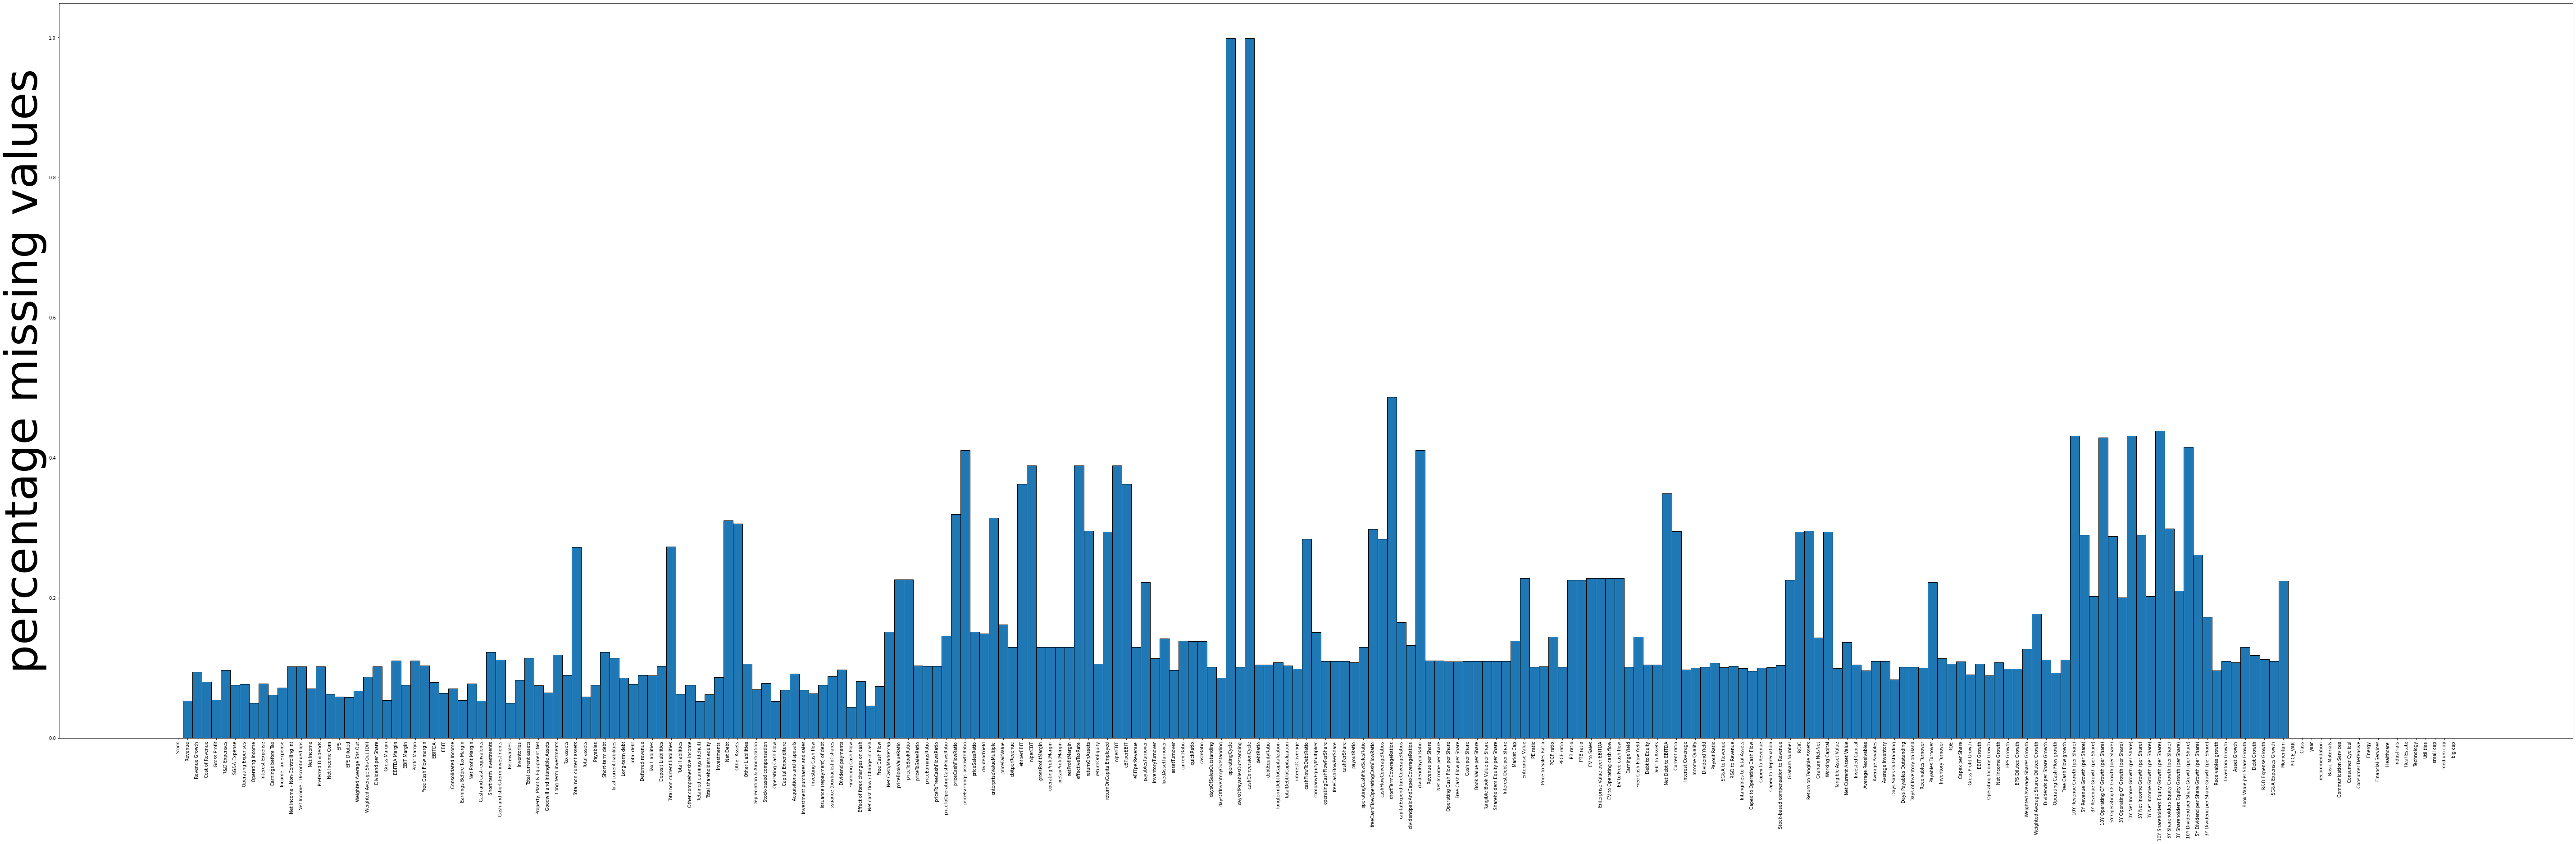

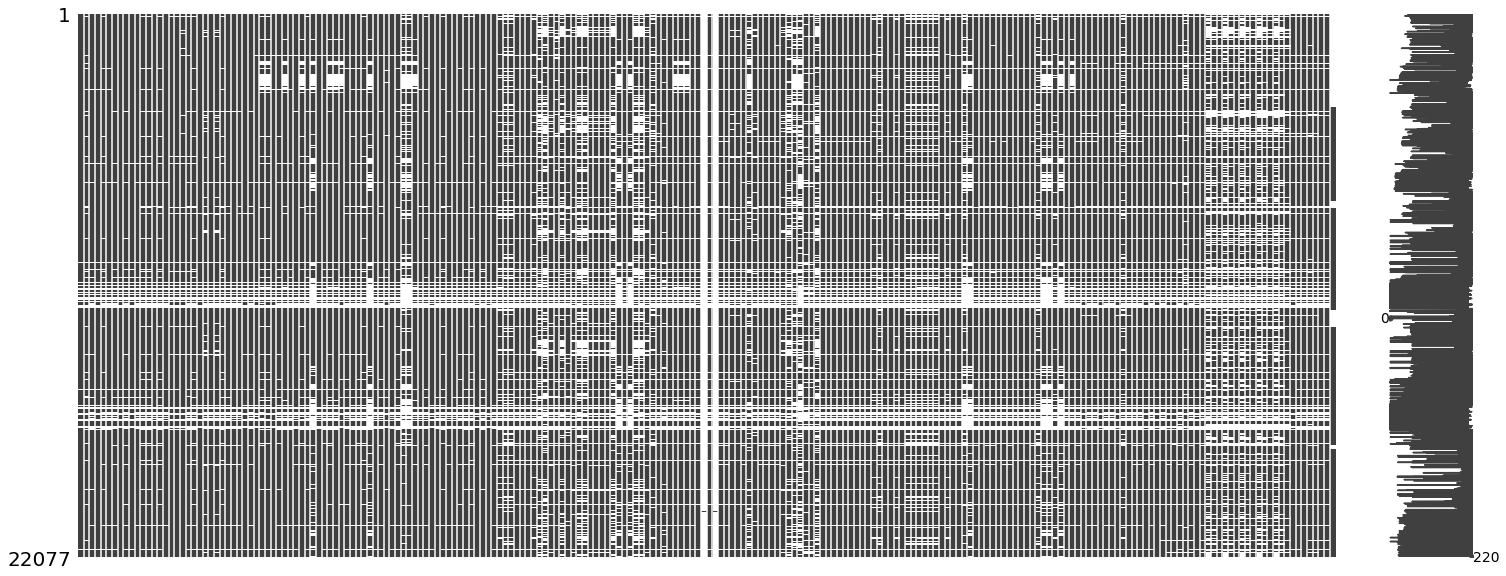

In [12]:
##### further exploration regarding NAs
#function to give back the column names and number of NAs of columns with more than a certain number of NAs
def name_gettr(data, treshold = 1500):
    res = {}
    for el in data[:1]:
        if data[el].isnull().sum() > treshold:
            res[el] = data[el].isnull().sum()
    return res

#apply function defined above
df14_outl = name_gettr(df14)
df15_outl = name_gettr(df15)
df16_outl = name_gettr(df16)
df17_outl = name_gettr(df17)
df18_outl = name_gettr(df18)


#create a list with dictionaries in order to run another function on them 
df_all_outl = [df14_outl, df15_outl, df16_outl, df17_outl, df18_outl]

#function which creates a list with all unique variables that have more than a certain number of NAs for at least one of the years of interest
def unique_high_NA (data):
    res = []
    for el in data:
        for e in el.keys():
            if not e in res:
                res.append(e)
    return(res)

#apply function and count number of variables to be retired from df
high_NA_vars = unique_high_NA(df_all_outl)
print(high_NA_vars)
len(unique_high_NA(df_all_outl)) #36 (out of 225, i.e. ~16%) variables


#graph showing percentages of values missing 
ratio_NA = df_all.isnull().sum()/len(df_all)
pd.Series.sort_values(ratio_NA)
plt.figure(figsize=(100, 30))
plt.bar(np.arange(1,len(ratio_NA)+1), height = ratio_NA, width = 1, ec = 'black')
plt.ylabel('percentage missing values', fontsize = 100)
plt.rc('ytick', labelsize=80)
plt.rc('xtick', labelsize=5)
plt.xticks(np.arange(1,len(ratio_NA)+1), list(df_all.columns), rotation = 90)


#missing value matrix where white lines indicate missing values
missingdata = df_all.columns[df_all.isnull().any()].tolist()
msno.matrix(df_all[missingdata])
    #we clearly see that e.g. for operatingCylce and cashConversionCycle we have a huge amount of NAs 
    #this is in harmony with the barplot above where we've seen this as well
    #what is also interesting is that some firms seem to have no or almost no data
    
    

#gives out the percentage of rows with an NA count of more than 150
high_col_nas = [ x for x in df_all.isnull().sum(axis=1) if x > 150]
len(high_col_nas)/len(df_all)
#high_col_nas

0.09802056438827739

63

4980

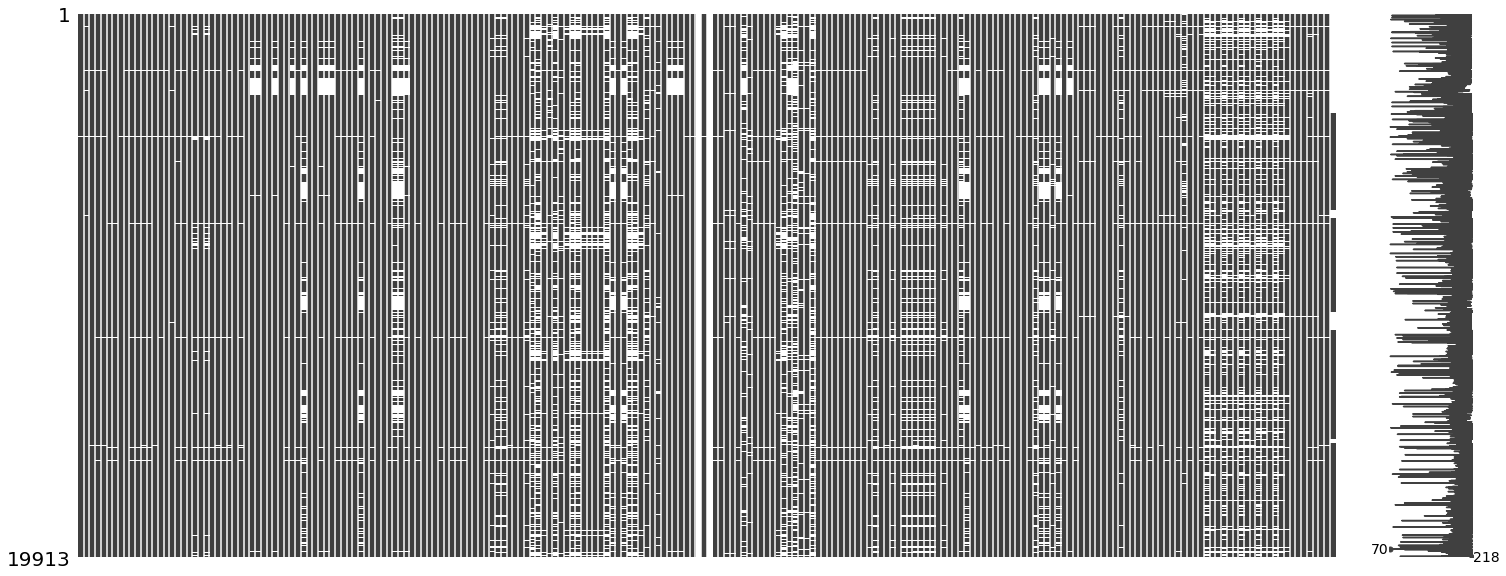

In [13]:
#gives out the percentage of rows with an NA count of more than 150
high_row_nas = [ x for x in df_all.isnull().sum(axis=1) if x > 150]
len(high_row_nas)/len(df_all)
    #we have an approximate 10% of firms with many missing values
len(set(high_row_nas))
    #63 different 'amounts' of NA values
# set(high_row_nas)


#gives out the indices of the rows with an NA count of more than 150
high_na_indices = []
for x,y in enumerate(df_all.isnull().sum(axis=1)):
    if y > 150:
        high_na_indices.append(x)
        
        
#gives out the unique names of the companies with an NA count of more than 150
# df_all["Stock"][high_na_indices]  #uncomment for names of the firms
high_na_names = set(df_all["Stock"][high_na_indices])
len(set(df_all["Stock"]))


#drop the firms with over 150 missing values from the dataframe
df_all = df_all.drop(df_all.index[high_na_indices])
df_all.index = np.arange(len(df_all))
    #re-numeration of the index
    
    
#missing value matrix where white lines indicate missing values
missingdata_after_removal = df_all.columns[df_all.isnull().any()].tolist()
msno.matrix(df_all[missingdata_after_removal])
    #we clearly see that the rows which had almost no data have been removed

In [14]:
##### implementing a KNN imputation for the whole dataset
imputer = KNNImputer(n_neighbors=20, weights='distance', metric='nan_euclidean', copy=True)


#for df_all
df_all_Stock = df_all['Stock']
#careful with the following line as it has to be commented out if you were to run this chunk for a second time (since once we've dropped the variable 'Sector' we can obviously not drop it a second time)
df_all.drop(['Stock'], axis = 1, inplace = True) 

df_all_imputed = imputer.fit_transform(df_all)
df_all_imputed = pd.DataFrame(df_all_imputed)
df_all_imputed.columns = list(df_all)
df_all_imputed.isnull().sum().sum()

0

In [15]:
##### implementing a KNN imputation for each individual year
imputer = KNNImputer(n_neighbors=20, weights='distance', metric='nan_euclidean', copy=True)


# df14
df14_Sector = df14['Sector'] # defined above
df14_Stock = df14['Stock']
#careful with the following line as it has to be commented out if you were to run this chunk for a second time (since once we've dropped the variable 'Sector' we can obviously not drop it a second time)
df14.drop(['Sector', 'Stock'], axis = 1, inplace = True) 

df14_imputed = imputer.fit_transform(df14)
df14_imputed = pd.DataFrame(df14_imputed)
df14_imputed.columns = list(df14)
df14_imputed.isnull().sum().sum()


# df15
df15_Sector = df15['Sector']
df15_Stock = df15['Stock']
#careful with the following line as it has to be commented out if you were to run this chunk for a second time (since once we've dropped the variable 'Sector' we can obviously not drop it a second time)
df15.drop(['Sector', 'Stock'], axis = 1, inplace = True)

df15_imputed = imputer.fit_transform(df15)
df15_imputed = pd.DataFrame(df15_imputed)
df15_imputed.columns = list(df15)
df15_imputed.isnull().sum().sum()


# df16
df16_Sector = df16['Sector']
df16_Stock = df16['Stock']
#careful with the following line as it has to be commented out if you were to run this chunk for a second time (since once we've dropped the variable 'Sector' we can obviously not drop it a second time)
df16.drop(['Sector', 'Stock'], axis = 1, inplace = True)

df16_imputed = imputer.fit_transform(df16)
df16_imputed = pd.DataFrame(df16_imputed)
df16_imputed.columns = list(df16)
df16_imputed.isnull().sum().sum()


# df17
df17_Sector = df17['Sector']
df17_Stock = df17['Stock']
#careful with the following line as it has to be commented out if you were to run this chunk for a second time (since once we've dropped the variable 'Sector' we can obviously not drop it a second time)
df17.drop(['Sector', 'Stock'], axis = 1, inplace = True)

df17_imputed = imputer.fit_transform(df17)
df17_imputed = pd.DataFrame(df17_imputed)
df17_imputed.columns = list(df17)
df17_imputed.isnull().sum().sum()


# df18
df18_Sector = df18['Sector']
df18_Stock = df18['Stock']
#careful with the following line as it has to be commented out if you were to run this chunk for a second time (since once we've dropped the variable 'Sector' we can obviously not drop it a second time)
df18.drop(['Sector', 'Stock'], axis = 1, inplace = True)

df18_imputed = imputer.fit_transform(df18)
df18_imputed = pd.DataFrame(df18_imputed)
df18_imputed.columns = list(df18)
df18_imputed.isnull().sum().sum()

0

0

0

0

0

<Figure size 3600x1440 with 0 Axes>

[Text(1395.0, 978.48, 'X[50] <= 92302224.0\ngini = 0.49\nsamples = 3808\nvalue = [2174, 1634]'),
 Text(697.5, 761.0400000000001, 'X[128] <= 2.727\ngini = 0.475\nsamples = 3333\nvalue = [2036, 1297]'),
 Text(348.75, 543.6, 'X[18] <= 7382377.0\ngini = 0.449\nsamples = 2134\nvalue = [1407, 727]'),
 Text(174.375, 326.1600000000001, 'X[40] <= 17948.5\ngini = 0.336\nsamples = 327\nvalue = [257, 70]'),
 Text(87.1875, 108.72000000000003, 'gini = 0.261\nsamples = 227\nvalue = [192, 35]'),
 Text(261.5625, 108.72000000000003, 'gini = 0.455\nsamples = 100\nvalue = [65, 35]'),
 Text(523.125, 326.1600000000001, 'X[81] <= 7.74\ngini = 0.463\nsamples = 1807\nvalue = [1150, 657]'),
 Text(435.9375, 108.72000000000003, 'gini = 0.382\nsamples = 494\nvalue = [367, 127]'),
 Text(610.3125, 108.72000000000003, 'gini = 0.481\nsamples = 1313\nvalue = [783, 530]'),
 Text(1046.25, 543.6, 'X[48] <= 445779008.0\ngini = 0.499\nsamples = 1199\nvalue = [629, 570]'),
 Text(871.875, 326.1600000000001, 'X[204] <= 0.003\n

|--- Deposit Liabilities <= 92302224.00
|   |--- capitalExpenditureCoverageRatios <= 2.73
|   |   |--- Weighted Average Shs Out <= 7382377.00
|   |   |   |--- Tax assets <= 17948.50
|   |   |   |   |--- class: 0.0
|   |   |   |--- Tax assets >  17948.50
|   |   |   |   |--- class: 0.0
|   |   |--- Weighted Average Shs Out >  7382377.00
|   |   |   |--- priceCashFlowRatio <= 7.74
|   |   |   |   |--- class: 0.0
|   |   |   |--- priceCashFlowRatio >  7.74
|   |   |   |   |--- class: 0.0
|   |--- capitalExpenditureCoverageRatios >  2.73
|   |   |--- Deferred revenue <= 445779008.00
|   |   |   |--- 3Y Operating CF Growth (per Share) <= 0.00
|   |   |   |   |--- class: 0.0
|   |   |   |--- 3Y Operating CF Growth (per Share) >  0.00
|   |   |   |   |--- class: 1.0
|   |   |--- Deferred revenue >  445779008.00
|   |   |   |--- Capital Expenditure <= -205000000.00
|   |   |   |   |--- class: 0.0
|   |   |   |--- Capital Expenditure >  -205000000.00
|   |   |   |   |--- class: 1.0
|--- Deposit

array([ 50, 128,  18,  40,  81,  48, 204,  63,   3,  59,  12,  61, 141,
        78, 137], dtype=int64)

features with high NA values (in at least one year) that are important according to the classification tree:


priceCashFlowRatio    1053
dtype: int64

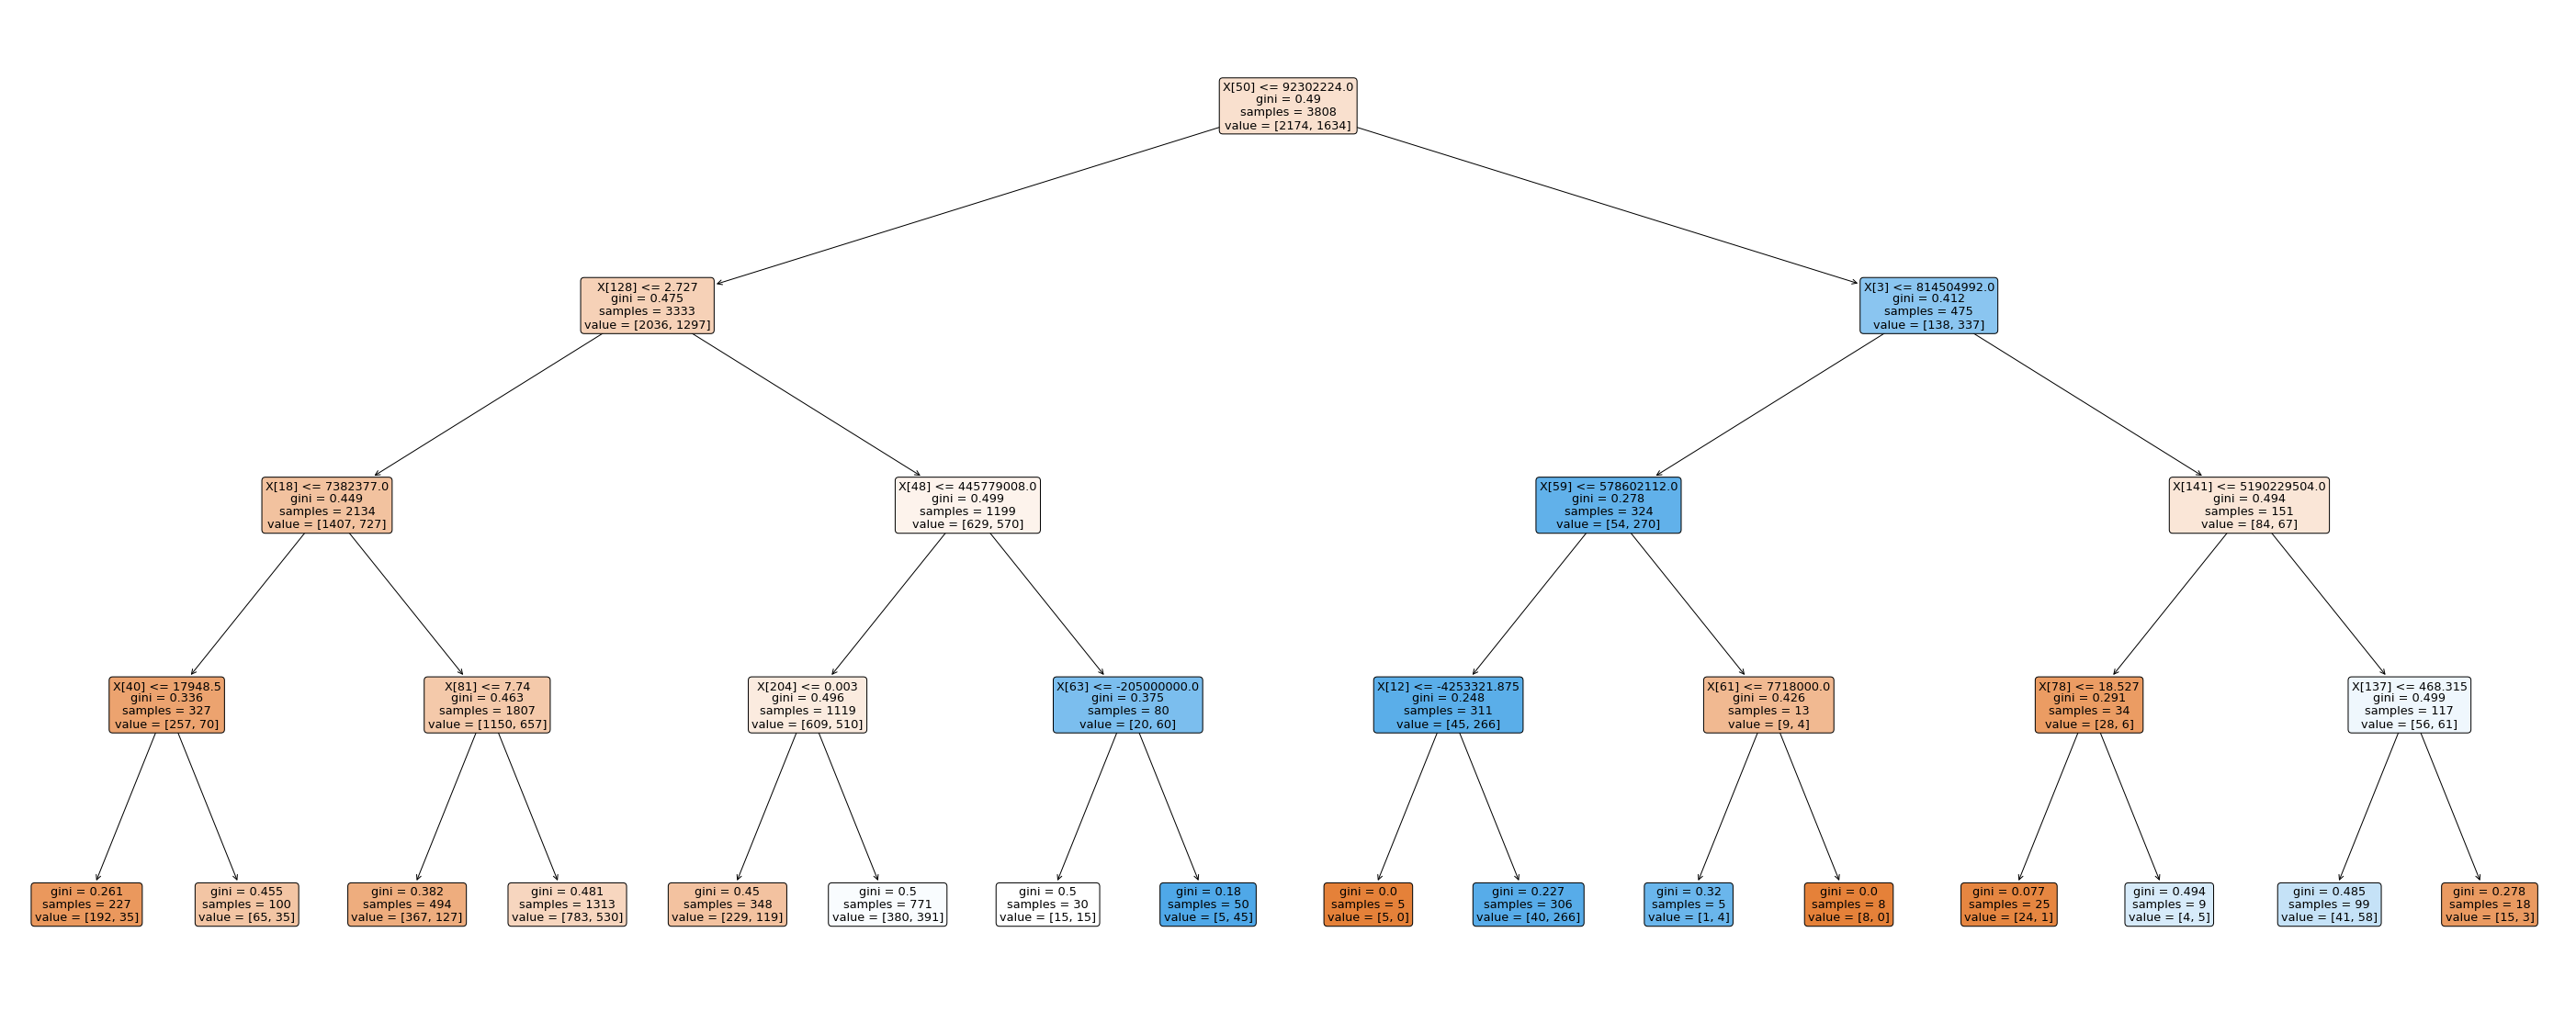

In [16]:
##### naive classification tree in order to see whether one of the variables ommitted is able to explain the dependent variable
Y = df14_imputed['Class']
X = df14_imputed.drop(['Class', 'PRICE_VAR'], axis = 1)

#fit the tree
tree = DecisionTreeClassifier(random_state = 0 , max_depth = 4)
tree_fit_df14 = tree.fit(X, Y)
plt.figure(figsize = (50, 20))
plot_tree(tree_fit_df14, filled = True, rounded = True)

#tree in text form
tree_text_df14 = export_text(tree_fit_df14, feature_names=list(X))
print(tree_text_df14)

#extract splitting features
tree_features_df14 = tree_fit_df14.tree_.feature
tree_features_df14 = tree_features_df14[tree_features_df14 != -2]
tree_features_df14



##### interpretation of the results from the desicion tree
#for df14:

#function to get the column names of the variables which were used to fit the decision tree
def imp_feat(data, idx): #imp_feat: important features
    res = []
    for el in idx:
        res.append(data.columns[el])
    return(res)

#apply above function to the data set
imp_feat_list_df14 = imp_feat(data = df14_imputed, idx = tree_features_df14)

#gives back a list of features which were used in the classification tree but have "a lot of" NAs
misfits_df14 = []
for el in imp_feat_list_df14:
    if el in high_NA_vars:
        misfits_df14.append(el)

print('features with high NA values (in at least one year) that are important according to the classification tree:')
df14[misfits_df14].isna().sum()
    #we see that apparently the variable 'priceCashFlowRatio' in the list 'misfits' does NOT have more than the treshold value of NAs for the year 2014 (but for some other year)

In [17]:
#####for 15-18 and df_all

#df15
Y = df15_imputed['Class']
X = df15_imputed.drop(['Class', 'PRICE_VAR'], axis = 1)

#fit the tree
tree = DecisionTreeClassifier(random_state = 0 , max_depth = 4) #not necessary but for rigour's sake
tree_fit_df15 = tree.fit(X, Y)

#extract splitting features
tree_features_df15 = tree_fit_df15.tree_.feature
tree_features_df15 = tree_features_df15[tree_features_df15 != -2]
tree_features_df15

#apply function to get col names
imp_feat_list_df15 = imp_feat(data = df15_imputed, idx = tree_features_df15)

misfits_df15 = []
for el in imp_feat_list_df15:
    if el in high_NA_vars:
        misfits_df15.append(el)

print('features with high NA values (in at least one year) that are important according to the classification tree (year 15):')
df15[misfits_df15].isna().sum()


####################################################################################################
#df16
Y = df16_imputed['Class']
X = df16_imputed.drop(['Class', 'PRICE_VAR'], axis = 1)

#fit the tree
tree = DecisionTreeClassifier(random_state = 0 , max_depth = 4) #not necessary but for rigour's sake
tree_fit_df16 = tree.fit(X, Y)

#extract splitting features
tree_features_df16 = tree_fit_df16.tree_.feature
tree_features_df16 = tree_features_df16[tree_features_df16 != -2]
tree_features_df16

#apply function to get col names
imp_feat_list_df16 = imp_feat(data = df16_imputed, idx = tree_features_df16)

misfits_df16 = []
for el in imp_feat_list_df16:
    if el in high_NA_vars:
        misfits_df16.append(el)

print('features with high NA values (in at least one year) that are important according to the classification tree (year 16):')
df16[misfits_df16].isna().sum()


####################################################################################################
#df17
Y = df17_imputed['Class']
X = df17_imputed.drop(['Class', 'PRICE_VAR'], axis = 1)

#fit the tree
tree = DecisionTreeClassifier(random_state = 0 , max_depth = 4) #not necessary but for rigour's sake
tree_fit_df17 = tree.fit(X, Y)

#extract splitting features
tree_features_df17 = tree_fit_df17.tree_.feature
tree_features_df17 = tree_features_df17[tree_features_df17 != -2]
tree_features_df17

#apply function to get col names
imp_feat_list_df17 = imp_feat(data = df17_imputed, idx = tree_features_df17)

misfits_df17 = []
for el in imp_feat_list_df17:
    if el in high_NA_vars:
        misfits_df17.append(el)

print('features with high NA values (in at least one year) that are important according to the classification tree (year 17):')
df17[misfits_df17].isna().sum()


####################################################################################################
#df18
Y = df18_imputed['Class']
X = df18_imputed.drop(['Class', 'PRICE_VAR'], axis = 1)

#fit the tree
tree = DecisionTreeClassifier(random_state = 0 , max_depth = 4) #not necessary but for rigour's sake
tree_fit_df18 = tree.fit(X, Y)

#extract splitting features
tree_features_df18 = tree_fit_df18.tree_.feature
tree_features_df18 = tree_features_df18[tree_features_df18 != -2]
tree_features_df18

#apply function to get col names
imp_feat_list_df18 = imp_feat(data = df18_imputed, idx = tree_features_df18)

misfits_df18 = []
for el in imp_feat_list_df18:
    if el in high_NA_vars:
        misfits_df18.append(el)

print('features with high NA values (in at least one year) that are important according to the classification tree (year 18):')
df18[misfits_df18].isna().sum()



####################################################################################################
#for all the data

Y = df_all_imputed['Class']
X = df_all_imputed.drop(['Class', 'PRICE_VAR'], axis = 1)

#fit the tree
tree = DecisionTreeClassifier(random_state = 0 , max_depth = 4) #not necessary but for rigour's sake
tree_fit_all = tree.fit(X, Y)
#plt.figure(figsize = (50, 20))
#plot_tree(tree_fit_all, filled = True, rounded = True)

#tree in text form
tree_text_all = export_text(tree_fit_all, feature_names=list(X))
#print(tree_text_all)

#extract splitting features
tree_features_all = tree_fit_all.tree_.feature
tree_features_all = tree_features_all[tree_features_all != -2]
tree_features_all


#apply function to get col names
imp_feat_list_all = imp_feat(data = df_all_imputed, idx = tree_features_all)

misfits = []
for el in imp_feat_list_all:
    if el in high_NA_vars:
        misfits.append(el)


array([ 22, 133,  69, 185,  96,  86,  65,  81, 160,  68, 127, 181, 104,
        30,  90], dtype=int64)

features with high NA values (in at least one year) that are important according to the classification tree (year 15):


priceCashFlowRatio         1197
shortTermCoverageRatios    1925
dtype: int64

array([  7,  87, 139,  31, 170, 140,  17, 113,  39,  15, 164, 107, 206,
       216,  20], dtype=int64)

features with high NA values (in at least one year) that are important according to the classification tree (year 16):


ROIC                                1602
5Y Net Income Growth (per Share)    1680
dtype: int64

array([ 86, 110, 156, 182,  12,  20,  23, 144, 151,  85,   3, 163,  25,
       215], dtype=int64)

features with high NA values (in at least one year) that are important according to the classification tree (year 17):


operatingCycle             4955
Net Debt to EBITDA         2201
enterpriseValueMultiple    1800
dtype: int64

array([174, 195, 143,  61,  38,  16,  68, 208,  81,  65,  16, 210,  24,
         8,  41], dtype=int64)

features with high NA values (in at least one year) that are important according to the classification tree (year 18):


10Y Shareholders Equity Growth (per Share)    1695
priceCashFlowRatio                            1256
Total non-current assets                      1041
dtype: int64

array([223, 161,  73, 222, 222,  83, 222, 188, 223, 222, 222, 222, 169],
      dtype=int64)

In [18]:
#consolidate all variables which are important for any of the five years
misfits_all = list(set(misfits_df14 + misfits_df15 + misfits_df16 + misfits_df17 + misfits_df18)) #set() in order to remove dublicates
misfits_all

df_temporary = [df14, df15, df16, df17, df18]
for el in df_temporary:
    print(el[misfits_all].isnull().sum(), "\n")

#from this output we conclude that:
    #even if operatingCycle would be able to predict future return, we have way too many NAs
    #also shortTermCoverageRatios and 10y Shareholder Equity Growth has too few values over all years, hence we remove it from the data set
    #we leave in the dataset the following:
        #priceCashFlowRatio
        #5Y Net Income Growth (per Share)
        #enterpriseValueMultiple
        #ROIC
        #Total non-current assets
        
        
        
##### dropping variables with too many NAs

#high_NA_vars #uncomment to see variables that have many NAs

notdrop = ['priceCashFlowRatio', '5Y Net Income Growth (per Share)', 'enterpriseValueMultiple', 'ROIC', 'Total non-current assets']
drop = [x for x in high_NA_vars if x not in notdrop]

df14_imputed.drop(drop, axis = 1, inplace = True)
df15_imputed.drop(drop, axis = 1, inplace = True)
df16_imputed.drop(drop, axis = 1, inplace = True)
df17_imputed.drop(drop, axis = 1, inplace = True)
df18_imputed.drop(drop, axis = 1, inplace = True)
df_all_imputed.drop(drop, axis = 1, inplace = True)

['5Y Net Income Growth (per Share)',
 'priceCashFlowRatio',
 'operatingCycle',
 'ROIC',
 'shortTermCoverageRatios',
 'enterpriseValueMultiple',
 '10Y Shareholders Equity Growth (per Share)',
 'Total non-current assets',
 'Net Debt to EBITDA']

5Y Net Income Growth (per Share)              1037
priceCashFlowRatio                            1053
operatingCycle                                3807
ROIC                                           987
shortTermCoverageRatios                       1956
enterpriseValueMultiple                        944
10Y Shareholders Equity Growth (per Share)    1585
Total non-current assets                       908
Net Debt to EBITDA                            1424
dtype: int64 

5Y Net Income Growth (per Share)              1214
priceCashFlowRatio                            1197
operatingCycle                                4118
ROIC                                          1125
shortTermCoverageRatios                       1925
enterpriseValueMultiple                       1224
10Y Shareholders Equity Growth (per Share)    1766
Total non-current assets                      1029
Net Debt to EBITDA                            1596
dtype: int64 

5Y Net Income Growth (per Share)              1680
p

### 3.2 Further Imputing Methods (took about forever)
* as the title suggests, here we tried to use different methods
* the first one is a method that is often used in R
* the second imputation here is based on the (still experimental) iterative imputer from the sklearn package

\
some links that we have found to be useful\
for the MissForest imputer: \
https://github.com/epsilon-machine/missingpy/blob/master/missingpy/missforest.py \
https://towardsdatascience.com/how-to-use-python-and-missforest-algorithm-to-impute-missing-data-ed45eb47cb9a

for the MICE imputer (quite similar to the iterative imputer, that we tried to implement but we couldn't get to work): \
https://www.statsmodels.org/stable/generated/statsmodels.imputation.mice.MICEData.html \
https://towardsdatascience.com/stop-using-mean-to-fill-missing-data-678c0d396e22

general:\
https://www.analyticsvidhya.com/blog/2016/03/tutorial-powerful-packages-imputing-missing-values/

In [19]:
'''
##### MissForest imputer

#drop Stock column for df_all
df_all.drop(drop, axis=1, inplace=True)

#make an instance and perform an imputation
imputer2 = MissForest(max_iter = 4, n_estimators = 10, max_depth = 5, n_jobs = -1, random_state = 3)
    #we have (rather dramatically) reduced some input parameters due to the high time complexity of this algorithm (a single iteration with those takes about 10mins on our laptops)

#df 14    
df14_imputed_ver2 = imputer2.fit_transform(df14)
df14_imputed_ver2 = pd.DataFrame(df14_imputed_ver2)
df14_imputed_ver2.columns = list(df14)
df14_imputed_ver2.isnull().sum().sum()


#df 15  
df15_imputed_ver2 = imputer2.fit_transform(df15)
df15_imputed_ver2 = pd.DataFrame(df15_imputed_ver2)
df15_imputed_ver2.columns = list(df15)
df15_imputed_ver2.isnull().sum().sum()


#df 16
df16_imputed_ver2 = imputer2.fit_transform(df16)
df16_imputed_ver2 = pd.DataFrame(df16_imputed_ver2)
df16_imputed_ver2.columns = list(df16)
df16_imputed_ver2.isnull().sum().sum()


#df 17
df17_imputed_ver2 = imputer2.fit_transform(df17)
df17_imputed_ver2 = pd.DataFrame(df17_imputed_ver2)
df17_imputed_ver2.columns = list(df17)
df17_imputed_ver2.isnull().sum().sum()


#df 18
df18_imputed_ver2 = imputer2.fit_transform(df18)
df18_imputed_ver2 = pd.DataFrame(df18_imputed_ver2)
df18_imputed_ver2.columns = list(df18)
df18_imputed_ver2.isnull().sum().sum()


#df_all
df_all_imputed_ver2 = imputer2.fit_transform(df_all)
df_all_imputed_ver2 = pd.DataFrame(df_all_imputed_ver2)
df_all_imputed_ver2.columns = list(df_all)
df_all_imputed_ver2.isnull().sum().sum()
'''

'\n##### MissForest imputer\n\n#drop Stock column for df_all\ndf_all.drop(drop, axis=1, inplace=True)\n\n#make an instance and perform an imputation\nimputer2 = MissForest(max_iter = 4, n_estimators = 10, max_depth = 5, n_jobs = -1, random_state = 3)\n    #we have (rather dramatically) reduced some input parameters due to the high time complexity of this algorithm (a single iteration with those takes about 10mins on our laptops)\n\n#df 14    \ndf14_imputed_ver2 = imputer2.fit_transform(df14)\ndf14_imputed_ver2 = pd.DataFrame(df14_imputed_ver2)\ndf14_imputed_ver2.columns = list(df14)\ndf14_imputed_ver2.isnull().sum().sum()\n\n\n#df 15  \ndf15_imputed_ver2 = imputer2.fit_transform(df15)\ndf15_imputed_ver2 = pd.DataFrame(df15_imputed_ver2)\ndf15_imputed_ver2.columns = list(df15)\ndf15_imputed_ver2.isnull().sum().sum()\n\n\n#df 16\ndf16_imputed_ver2 = imputer2.fit_transform(df16)\ndf16_imputed_ver2 = pd.DataFrame(df16_imputed_ver2)\ndf16_imputed_ver2.columns = list(df16)\ndf16_imputed_ver2

In [20]:
'''
##### iterative imputer
iter_imp = IterativeImputer(estimator =  ExtraTreesRegressor(n_estimators=10, random_state=0), max_iter=4, verbose=False)
iter_imp.fit(df_all)
df_all_imputed_ver3 = iter_imp.transform(df_all)
df_all_imputed_ver3 = pd.DataFrame(df_all_imputed_ver3, columns=df_all.columns)
    #only ran this code once (took about 4.5h)
'''

'\n##### iterative imputer\niter_imp = IterativeImputer(estimator =  ExtraTreesRegressor(n_estimators=10, random_state=0), max_iter=4, verbose=False)\niter_imp.fit(df_all)\ndf_all_imputed_ver3 = iter_imp.transform(df_all)\ndf_all_imputed_ver3 = pd.DataFrame(df_all_imputed_ver3, columns=df_all.columns)\n    #only ran this code once (took about 4.5h)\n'

## 4. Zero Values
when going though the data one thing that came to attention was the many zeroes \
the question is how to handle those zeroes as some make more sense (e.g. 0 R&D Expenses for a gold mining company) while others are more ambiguous (e.g. revenue of 0, very few firms have negative revenues for the year 2014)

In [19]:
##### inspection of 0-values

def name_gettr_zeroes(data, treshold = 500):
    res = {}
    for el in data[:1]:
        if data[el].isin([0]).sum() > treshold:
            res[el] = data[el].isin([0]).sum()
    return res


df14_zero_vals = list(df14.isin([0]).sum())
df14_zeroes = name_gettr_zeroes(df14)
print(df14_zeroes, '\n' ,'length =', len(df14_zeroes))


df15_zero_vals = df15.isin([0]).sum()
#df15_zero_vals

df16_zero_vals = df16.isin([0]).sum()
#df16_zero_vals

df17_zero_vals = df17.isin([0]).sum()
#df17_zero_vals

df18_zero_vals = df18.isin([0]).sum()
#df18_zero_vals

{'Cost of Revenue': 801, 'R&D Expenses': 2342, 'Interest Expense': 967, 'Income Tax Expense': 528, 'Net Income - Non-Controlling int': 2451, 'Net Income - Discontinued ops': 3046, 'Preferred Dividends': 3187, 'Dividend per Share': 1916, 'Short-term investments': 1812, 'Receivables': 608, 'Inventories': 1673, 'Goodwill and Intangible Assets': 1050, 'Long-term investments': 1771, 'Tax assets': 1725, 'Short-term debt': 1002, 'Long-term debt': 798, 'Total debt': 683, 'Deferred revenue': 2377, 'Tax Liabilities': 1652, 'Deposit Liabilities': 3032, 'Other comprehensive income': 933, 'Investments': 1360, 'Stock-based compensation': 598, 'Acquisitions and disposals': 1854, 'Investment purchases and sales': 1589, 'Issuance (repayment) of debt': 676, 'Issuance (buybacks) of shares': 618, 'Dividend payments': 1879, 'Effect of forex changes on cash': 1956, 'priceToBookRatio': 610, 'priceEarningsRatio': 1103, 'priceToFreeCashFlowsRatio': 1371, 'dividendYield': 1515, 'inventoryTurnover': 1571, 'daysO

companyEquityMultiplier    0.000000
Enterprise Value           0.000000
operatingProfitMargin      0.000000
operatingCycle             0.000000
EBITDA                     0.000000
                             ...   
Real Estate                0.942048
Energy                     0.944057
Consumer Defensive         0.956360
Utilities                  0.975293
Communication Services     0.980917
Length: 240, dtype: float64

<Figure size 7200x2160 with 0 Axes>

<BarContainer object of 240 artists>

Text(0, 0.5, 'percentage zero values')

([<matplotlib.axis.XTick at 0x7f84b5077880>,
 [Text(0, 0, 'Revenue'),
  Text(0, 0, 'Revenue Growth'),
  Text(0, 0, 'Cost of Revenue'),
  Text(0, 0, 'Gross Profit'),
  Text(0, 0, 'R&D Expenses'),
  Text(0, 0, 'SG&A Expense'),
  Text(0, 0, 'Operating Expenses'),
  Text(0, 0, 'Operating Income'),
  Text(0, 0, 'Interest Expense'),
  Text(0, 0, 'Earnings before Tax'),
  Text(0, 0, 'Income Tax Expense'),
  Text(0, 0, 'Net Income - Non-Controlling int'),
  Text(0, 0, 'Net Income - Discontinued ops'),
  Text(0, 0, 'Net Income'),
  Text(0, 0, 'Preferred Dividends'),
  Text(0, 0, 'Net Income Com'),
  Text(0, 0, 'EPS'),
  Text(0, 0, 'EPS Diluted'),
  Text(0, 0, 'Weighted Average Shs Out'),
  Text(0, 0, 'Weighted Average Shs Out (Dil)'),
  Text(0, 0, 'Dividend per Share'),
  Text(0, 0, 'Gross Margin'),
  Text(0, 0, 'EBITDA Margin'),
  Text(0, 0, 'EBIT Margin'),
  Text(0, 0, 'Profit Margin'),
  Text(0, 0, 'Free Cash Flow margin'),
  Text(0, 0, 'EBITDA'),
  Text(0, 0, 'EBIT'),
  Text(0, 0, 'Consolid

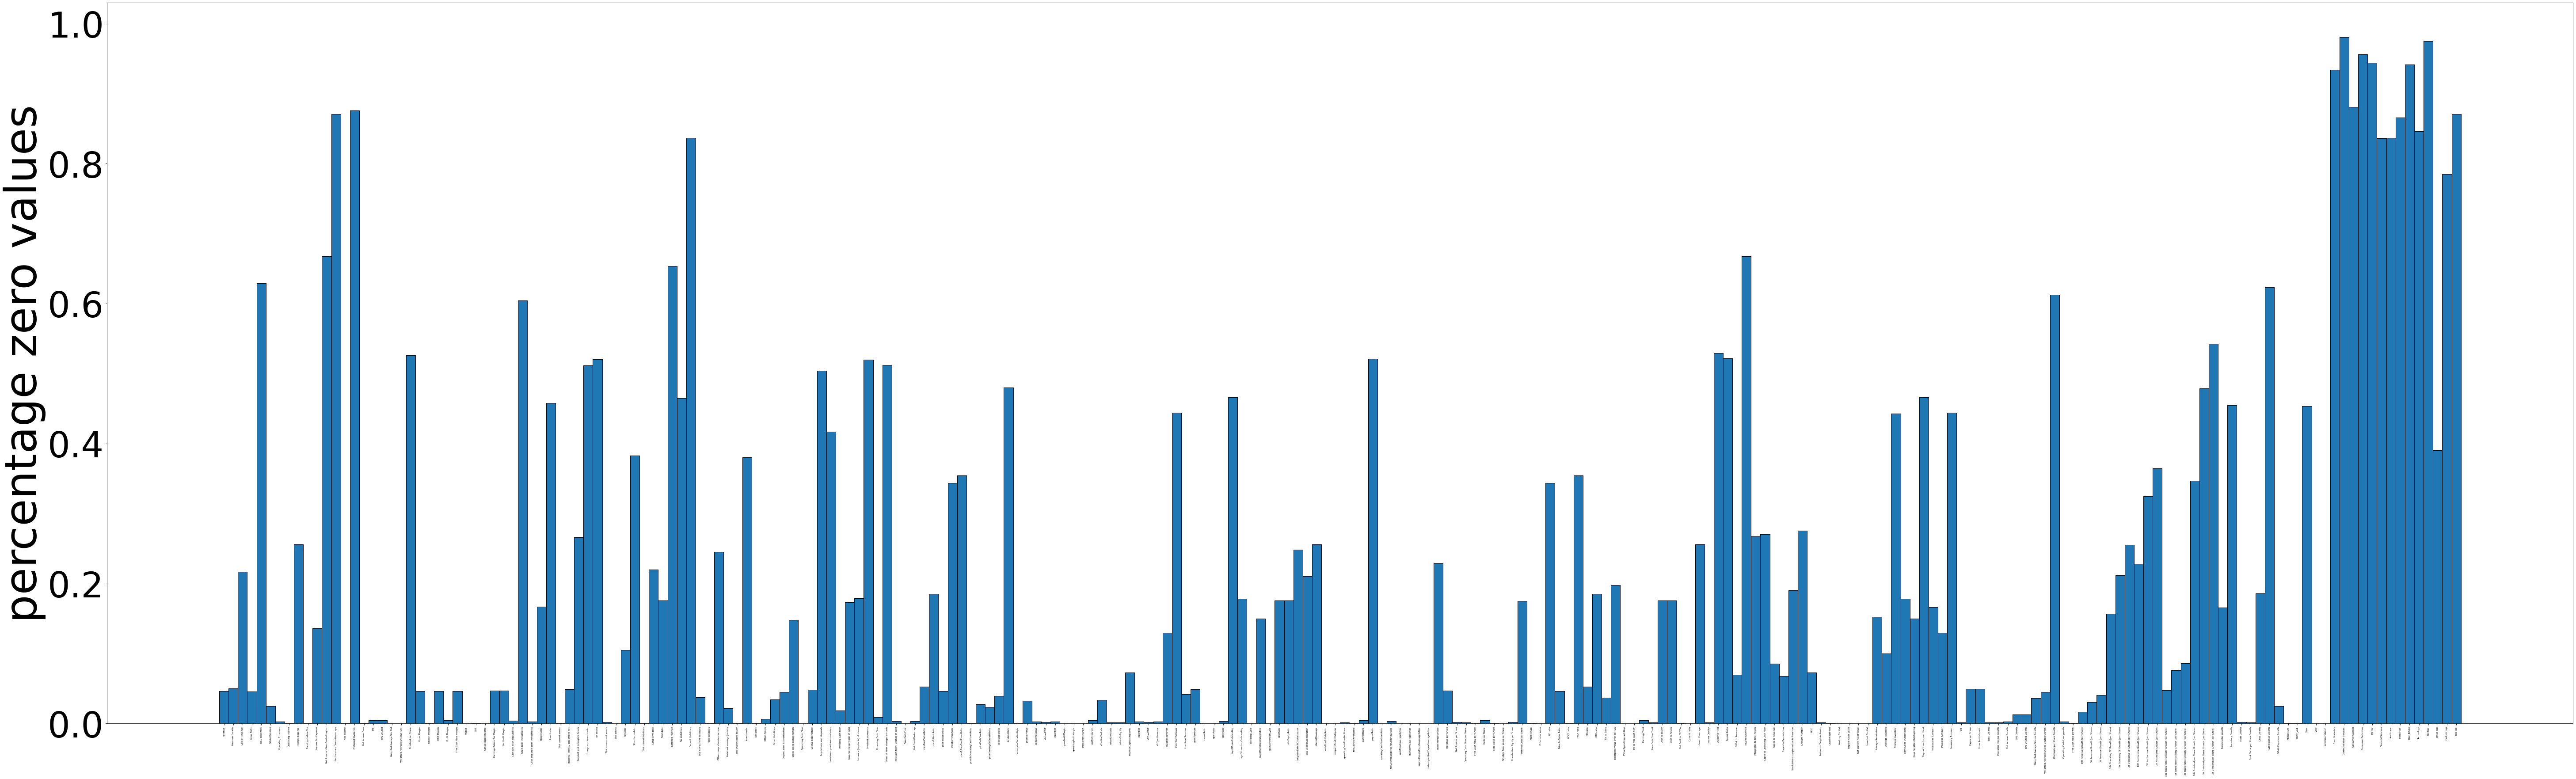

In [20]:
#graph showing percentages of zero values

ratio_zeroes = df_all.isin([0]).sum()/len(df_all)
pd.Series.sort_values(ratio_zeroes)
plt.figure(figsize=(100, 30))
plt.bar(np.arange(1,len(ratio_zeroes)+1), height = ratio_zeroes, width = 1, ec = 'black')
plt.ylabel('percentage zero values', fontsize = 100)
plt.rc('ytick', labelsize=80)
plt.rc('xtick', labelsize=5)
plt.xticks(np.arange(1,len(ratio_zeroes)+1), list(df_all.columns), rotation = 90)


In [21]:
df_all.iloc[:, 223:]
test = df_all.iloc[:, :223]
test

,Class,year,recommendation,Basic Materials,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Real Estate,Technology,Utilities,small cap,medium cap,big cap
0,0,2014,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,0,2014,-1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,1,2014,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,1,2014,-1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,1,2014,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19908,0,2018,-1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
19909,0,2018,-1,1,0,0,0,0,0,0,0,0,0,0,1,0,0
19910,0,2018,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
19911,0,2018,-1,0,0,0,0,0,0,0,1,0,0,0,1,0,0


,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Momentum,PRICE_VAR
0,7.440100e+10,-0.0713,3.903000e+10,3.537100e+10,0.000000e+00,2.146100e+10,2.146100e+10,1.391000e+10,7.090000e+08,1.449400e+10,...,0.0751,-0.0187,-0.0217,0.0359,0.0316,0.1228,0.0000,-0.1746,NaN,-9.323276
1,3.734148e+09,1.1737,2.805625e+09,9.285226e+08,1.083303e+08,3.441414e+08,7.939267e+08,1.345959e+08,1.214869e+07,1.753823e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,1.6484,1.7313,NaN,-25.512193
2,9.837500e+10,0.0182,7.813800e+10,2.023700e+10,0.000000e+00,1.519600e+10,1.751200e+10,2.725000e+09,4.430000e+08,2.270000e+09,...,0.1633,0.0618,0.0981,0.1886,0.3268,0.2738,0.0000,0.0234,NaN,33.118297
3,2.552641e+10,0.0053,1.820268e+10,7.323734e+09,0.000000e+00,6.561162e+09,6.586482e+09,7.372520e+08,4.245910e+08,2.502180e+08,...,0.0000,0.0211,-0.0510,-0.0189,0.1963,-0.0458,0.0000,-0.0060,NaN,2.752291
4,1.790960e+10,0.0076,1.153980e+10,6.369800e+09,0.000000e+00,3.474300e+09,3.412400e+09,2.957400e+09,3.024000e+08,2.707700e+09,...,0.1144,0.0257,0.0090,0.0215,0.0274,0.1025,0.0000,-0.0220,NaN,12.897715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19908,0.000000e+00,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,3.755251e+06,3.755251e+06,-3.755251e+06,1.105849e+07,-1.482451e+07,...,0.0000,0.0000,0.0000,-0.0508,-0.1409,-0.0152,0.0000,-0.2602,-35.647526,-90.962099
19909,5.560000e+05,-0.4110,0.000000e+00,5.560000e+05,4.759000e+06,5.071000e+06,9.830000e+06,-9.274000e+06,0.000000e+00,-9.170000e+06,...,0.0000,0.3445,0.0000,-0.2323,-0.8602,0.0000,0.0352,-0.0993,-41.956061,-77.922077
19910,5.488438e+07,0.2210,3.659379e+07,1.829059e+07,1.652633e+06,7.020320e+06,8.672953e+06,9.617636e+06,1.239170e+06,8.416324e+06,...,0.0000,0.1605,0.7706,0.2489,0.4074,-0.0968,0.2415,0.8987,9.175340,-17.834400
19911,0.000000e+00,0.0000,0.000000e+00,0.000000e+00,1.031715e+07,4.521349e+06,1.664863e+07,-1.664863e+07,0.000000e+00,-1.664769e+07,...,NaN,0.8980,0.0000,0.1568,-0.2200,0.0000,2.7499,0.1457,12.165180,-73.520000


<Figure size 360x144 with 0 Axes>

<BarContainer object of 20 artists>

([<matplotlib.axis.XTick at 0x7f84dbc41760>,
 [Text(0, 0, 'Preferred Dividends'),
  Text(0, 0, 'Net Income - Discontinued ops'),
  Text(0, 0, 'Deposit Liabilities'),
  Text(0, 0, 'Net Income - Non-Controlling int'),
  Text(0, 0, 'R&D to Revenue'),
  Text(0, 0, 'Deferred revenue'),
  Text(0, 0, 'R&D Expenses'),
  Text(0, 0, 'R&D Expense Growth'),
  Text(0, 0, 'Dividends per Share Growth'),
  Text(0, 0, 'Short-term investments'),
  Text(0, 0, '3Y Dividend per Share Growth (per Share)'),
  Text(0, 0, 'Dividend Yield'),
  Text(0, 0, 'Dividend per Share'),
  Text(0, 0, 'Payout Ratio'),
  Text(0, 0, 'payoutRatio'),
  Text(0, 0, 'Tax assets'),
  Text(0, 0, 'Dividend payments'),
  Text(0, 0, 'Effect of forex changes on cash'),
  Text(0, 0, 'Long-term investments'),
  Text(0, 0, 'Acquisitions and disposals')])

Text(0, 0.5, 'percentage zero values (ordered)')

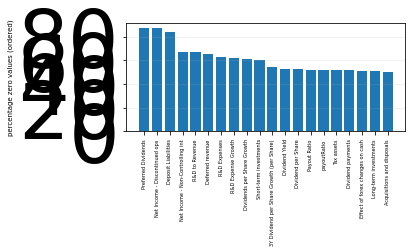

In [22]:
#plotting only the 20 columns with the most zero-values

total_zeroes = df_all.iloc[:, :223].isin([0]).sum().sort_values(ascending=False)
    #disregarded the dummy variables since they naturally contain a lot of zero values
percent_zeroes = (df_all.iloc[:, :223].isin([0]).sum()/df_all.iloc[:, :223].isin([0]).count()*100).sort_values(ascending=False)
df_zeroes = pd.concat([total_zeroes, percent_zeroes], axis = 1, keys = ['total zeroes', 'percent zeroes'])

plt.figure(figsize=(5, 2))
plt.bar(np.arange(20), df_zeroes['percent zeroes'].iloc[:20].values.tolist())
plt.xticks(np.arange(20), df_zeroes['percent zeroes'].iloc[:20].index.values.tolist(), rotation = 90)
plt.ylabel('percentage zero values (ordered)', fontsize = 7)
plt.rc('ytick', labelsize = 10)
plt.rc('xtick', labelsize = 5)
plt.grid(alpha = 0.2, axis = 'y')
plt.show()

#we see that most features with a high percentage of zero values are plausable to be zero (e.g. Dividend/ R&D Expenses)
#we assume that those are not measurement errors/ missing values and hence we decide that those values should not be omitted
#note: however, this says nothing about the importance of these values

## 5. Feature Engineering (Part 2)
### 5.1 Creation of Macroeconomic Factor / Inflation Interaction Term
We can now create the interaction terms with the inflation since we have imputed all the missing values in our data set. First we have to store the inflation data:

In [23]:
#We first have to load the data, yearly data from 2014 to 2018
Inflation_14 = 0.0162
Inflation_15 = 0.0012
Inflation_16 = 0.0126
Inflation_17 = 0.0214
Inflation_18 = 0.0244

The next step is to think about which interaction terms could have a significant influence on the stock performance. We will create some interaction terms and test them later on in the Feature Selection part.

According to Investopedia (https://www.investopedia.com/articles/investing/052913/inflations-impact-stock-returns.asp) Value stocks perform better in high inflation periods while growth stocks perfrom better during low inflation periods. We can make use of this information and try to add this effect into our model through an interaction term. 

Value Stocks are characterized by a high dividend yield, a low P/B Ratio and a low P/E Ratio (https://www.investopedia.com/terms/v/valuestock.asp). Growth Stocks are characterized by a high P/E Ratio and typically pay no dividend.

It would therefore make sense to test some interaction terms like inflation* dividend yield, inflation * P/E ratio and inflation * P/B ratio.

In [24]:
#####Inflation Dividend Yield Interaction Terms

Inflation_DY_14 = np.empty(shape = df14_imputed.shape[0])
Inflation_DY_15 = np.empty(shape = df15_imputed.shape[0])
Inflation_DY_16 = np.empty(shape = df16_imputed.shape[0])
Inflation_DY_17 = np.empty(shape = df17_imputed.shape[0])
Inflation_DY_18 = np.empty(shape = df18_imputed.shape[0])

Inflation_DY_14[:] = np.NAN
Inflation_DY_15[:] = np.NAN
Inflation_DY_16[:] = np.NAN
Inflation_DY_17[:] = np.NAN
Inflation_DY_18[:] = np.NAN

#df14
for idx, dy in enumerate(df14_imputed["Dividend Yield"]):
    Inflation_DY_14[idx] = (Inflation_14 * dy)
    
#df15
for idx, dy in enumerate(df15_imputed["Dividend Yield"]):
    Inflation_DY_15[idx] = (Inflation_15 * dy)
    
#df16
for idx, dy in enumerate(df16_imputed["Dividend Yield"]):
    Inflation_DY_16[idx] = (Inflation_16 * dy)
    
#df17
for idx, dy in enumerate(df17_imputed["Dividend Yield"]):
    Inflation_DY_17[idx] = (Inflation_17 * dy)
    
#df18
for idx, dy in enumerate(df18_imputed["Dividend Yield"]):
    Inflation_DY_18[idx] = (Inflation_18 * dy)
    
Inflation_DY_14 = pd.Series(Inflation_DY_14)
Inflation_DY_15 = pd.Series(Inflation_DY_15)
Inflation_DY_16 = pd.Series(Inflation_DY_16)
Inflation_DY_17 = pd.Series(Inflation_DY_17)
Inflation_DY_18 = pd.Series(Inflation_DY_18)


Inflation_DY = pd.concat([Inflation_DY_14, Inflation_DY_15, Inflation_DY_16, Inflation_DY_17, Inflation_DY_18], ignore_index = True)

#Add it to df_all_imputed
df_all_imputed["Inflation_DY"] = Inflation_DY

print(df_all_imputed.columns)

Index(['Revenue', 'Revenue Growth', 'Cost of Revenue', 'Gross Profit',
       'R&D Expenses', 'SG&A Expense', 'Operating Expenses',
       'Operating Income', 'Interest Expense', 'Earnings before Tax',
       ...
       'Financial Services', 'Healthcare', 'Industrials', 'Real Estate',
       'Technology', 'Utilities', 'small cap', 'medium cap', 'big cap',
       'Inflation_DY'],
      dtype='object', length=210)


In [25]:
###Inflation Price-Earnings Ratio Interaction Terms

Inflation_PER_14 = np.empty(shape = df14_imputed.shape[0])
Inflation_PER_15 = np.empty(shape = df15_imputed.shape[0])
Inflation_PER_16 = np.empty(shape = df16_imputed.shape[0])
Inflation_PER_17 = np.empty(shape = df17_imputed.shape[0])
Inflation_PER_18 = np.empty(shape = df18_imputed.shape[0])

Inflation_PER_14[:] = np.NAN
Inflation_PER_15[:] = np.NAN
Inflation_PER_16[:] = np.NAN
Inflation_PER_17[:] = np.NAN
Inflation_PER_18[:] = np.NAN

#df14
for idx, PER in enumerate(df14_imputed["priceEarningsRatio"]):
    Inflation_PER_14[idx] = (Inflation_14 * PER)
    
#df15
for idx, PER in enumerate(df15_imputed["priceEarningsRatio"]):
    Inflation_PER_15[idx] = (Inflation_15 * PER)
    
#df16
for idx, PER in enumerate(df16_imputed["priceEarningsRatio"]):
    Inflation_PER_16[idx] = (Inflation_16 * PER)
    
#df17
for idx, PER in enumerate(df17_imputed["priceEarningsRatio"]):
    Inflation_PER_17[idx] = (Inflation_17 * PER)
    
#df18
for idx, PER in enumerate(df18_imputed["priceEarningsRatio"]):
    Inflation_PER_18[idx] = (Inflation_18 * PER)
    
Inflation_PER_14 = pd.Series(Inflation_PER_14)
Inflation_PER_15 = pd.Series(Inflation_PER_15)
Inflation_PER_16 = pd.Series(Inflation_PER_16)
Inflation_PER_17 = pd.Series(Inflation_PER_17)
Inflation_PER_18 = pd.Series(Inflation_PER_18)


Inflation_PER = pd.concat([Inflation_PER_14, Inflation_PER_15, Inflation_PER_16, Inflation_PER_17, Inflation_PER_18], ignore_index = True)

#Add it to df_all_imputed
df_all_imputed["Inflation_PER"] = Inflation_PER

print(df_all_imputed.columns)

Index(['Revenue', 'Revenue Growth', 'Cost of Revenue', 'Gross Profit',
       'R&D Expenses', 'SG&A Expense', 'Operating Expenses',
       'Operating Income', 'Interest Expense', 'Earnings before Tax',
       ...
       'Healthcare', 'Industrials', 'Real Estate', 'Technology', 'Utilities',
       'small cap', 'medium cap', 'big cap', 'Inflation_DY', 'Inflation_PER'],
      dtype='object', length=211)


In [26]:
###Inflation Price-Book Ratio Interaction Terms

Inflation_PBR_14 = np.empty(shape = df14_imputed.shape[0])
Inflation_PBR_15 = np.empty(shape = df15_imputed.shape[0])
Inflation_PBR_16 = np.empty(shape = df16_imputed.shape[0])
Inflation_PBR_17 = np.empty(shape = df17_imputed.shape[0])
Inflation_PBR_18 = np.empty(shape = df18_imputed.shape[0])

Inflation_PBR_14[:] = np.NAN
Inflation_PBR_15[:] = np.NAN
Inflation_PBR_16[:] = np.NAN
Inflation_PBR_17[:] = np.NAN
Inflation_PBR_18[:] = np.NAN

#df14
for idx, PBR in enumerate(df14_imputed["priceToBookRatio"]):
    Inflation_PBR_14[idx] = (Inflation_14 * PBR)
    
#df15
for idx, PBR in enumerate(df15_imputed["priceToBookRatio"]):
    Inflation_PBR_15[idx] = (Inflation_15 * PBR)
    
#df16
for idx, PBR in enumerate(df16_imputed["priceToBookRatio"]):
    Inflation_PBR_16[idx] = (Inflation_16 * PBR)
    
#df17
for idx, PBR in enumerate(df17_imputed["priceToBookRatio"]):
    Inflation_PBR_17[idx] = (Inflation_17 * PBR)
    
#df18
for idx, PBR in enumerate(df18_imputed["priceToBookRatio"]):
    Inflation_PBR_18[idx] = (Inflation_18 * PBR)
    
Inflation_PBR_14 = pd.Series(Inflation_PBR_14)
Inflation_PBR_15 = pd.Series(Inflation_PBR_15)
Inflation_PBR_16 = pd.Series(Inflation_PBR_16)
Inflation_PBR_17 = pd.Series(Inflation_PBR_17)
Inflation_PBR_18 = pd.Series(Inflation_PBR_18)


Inflation_PBR = pd.concat([Inflation_PBR_14, Inflation_PBR_15, Inflation_PBR_16, Inflation_PBR_17, Inflation_PBR_18], ignore_index = True)

#Add it to df_all_imputed
df_all_imputed["Inflation_PBR"] = Inflation_PBR

## 6. Outliers
one more thing to consider before jumping into the process of fitting models are outliers \
the first and probably most prominent method is to cut off at some multiple of the stdv which however, requires the variables to follow a normal distribution (which is rather unlikely if I had to take an a priori guess)
another possibility is to work with the IQR method which is not in need of such a strong assumption

In [27]:
##### checking for multivariate normality (Heinze-Zirkler test)
    #note: if we only had a handful of features we could use common methods like the Shapiro-Wilk test or even simple QQ-plots
print(pg.multivariate_normality(df14_imputed))


#Thus we see that the data is not multivariate normal, according to the Heinze-Zirkler test
#i.e., we can not apply functions which are meant for Gaussian data

HZResults(hz=15232, pval=nan, normal=False)


In [28]:
#### IQR (https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/)

#function that returns the IQR for each column of our data set
def IQR_gettr(data):
    IQR = {}
    for el in data.columns:
        q25 = np.percentile(np.array(data[el]), 25)
        q75 = np.percentile(np.array(data[el]), 75)
        IQR[el] = round(q75 - q25, 4)
    return IQR

#function that returns which variables have an IQR equal to 0, input must be a dictionary
def IQR_zeroes(dictionary):
    res = {}
    for key, val in dictionary.items():
        if not val:
            res[key] = dictionary[key]
    return res



df14_IQR = IQR_gettr(df14_imputed) #dictionary
df14_IQR_zeroes = IQR_zeroes(df14_IQR) #dictionary
        
df15_IQR = IQR_gettr(df15_imputed)
df15_IQR_zeroes = IQR_zeroes(df15_IQR)

df16_IQR = IQR_gettr(df16_imputed)
df16_IQR_zeroes = IQR_zeroes(df16_IQR)

df17_IQR = IQR_gettr(df17_imputed)
df17_IQR_zeroes = IQR_zeroes(df17_IQR)

df18_IQR = IQR_gettr(df18_imputed)
df18_IQR_zeroes = IQR_zeroes(df18_IQR)


In [29]:
#input = imputed dataframe
#desired output = dataframe which took care of outliers, i.e., it restricts outliers to the IQR distance times 1.5

def IQR_outlier_manager(data):
    upper_lower_bound = {}
    
    for el in data.columns:
        q25 = np.percentile(np.array(data[el]), 25)
        q75 = np.percentile(np.array(data[el]), 75)
        IQR = (q75 - q25)
        
        upper_lower_bound[el] = [q75 + IQR * 1.5, q25 - IQR * 1.5]
        
    
    #until here we created a dictionary with the column name as the key and the
    #Interquantile distance (upper and lower borders), times a threshold (1.5) as value
    
    outlier_count_lower = 0
    outlier_count_upper = 0
    
    res = {}
    
    for el in data.columns:
        upper = upper_lower_bound[el][0]
        lower = upper_lower_bound[el][1]
        res[el] = []
        #here we extract the upper and lower bound per column of the dataframe:
                
        for e in data[el]:
            if e > upper:
                res[el].append(upper)
                outlier_count_upper += 1
            elif e < lower:
                res[el].append(lower)
                outlier_count_lower += 1
            else:
                res[el].append(e)
        #then we check whether the entries of the columns are larger or smaller than our borders, if so
        #we reset them to lie on the border, furthermore we count the amount of outliers overall
    
    res = pd.DataFrame.from_dict(res)
    #print(f"Amount of outliers below: {outlier_count_lower}\nAmount of outliers above: {outlier_count_upper}")
    return res

#finally we return our new modified dataframe and the amount of outliers we counted (upper and lower separated)
    

In [30]:
#apply the function to our data set

df14_imputed_outliercorrected = IQR_outlier_manager(df14_imputed)
df15_imputed_outliercorrected = IQR_outlier_manager(df15_imputed)
df16_imputed_outliercorrected = IQR_outlier_manager(df16_imputed)
df17_imputed_outliercorrected = IQR_outlier_manager(df17_imputed)
df18_imputed_outliercorrected = IQR_outlier_manager(df18_imputed)

In [31]:
#convert df_all_imputed to a dataframe
df_all_imputed = pd.DataFrame(df_all_imputed)

#we create a oultier-corrected dataframe over all five years (IQR Method)
df_all_imputed_outliercorrected = IQR_outlier_manager(df_all_imputed)
df_all_imputed_outliercorrected

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,Industrials,Real Estate,Technology,Utilities,small cap,medium cap,big cap,Inflation_DY,Inflation_PER,Inflation_PBR
0,5.719213e+09,-0.0713,2.856237e+09,2.198403e+09,0.0,8.833008e+08,1.488835e+09,6.551135e+08,1.203800e+08,5.157761e+08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000504,0.303857,0.000000
1,3.734148e+09,0.4772,2.805625e+09,9.285226e+08,30215000.0,3.441414e+08,7.939267e+08,1.345959e+08,1.214869e+07,1.753823e+08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.007314,0.175556
2,5.719213e+09,0.0182,2.856237e+09,2.198403e+09,0.0,8.833008e+08,1.488835e+09,6.551135e+08,1.203800e+08,5.157761e+08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000282,0.194951,0.114991
3,5.719213e+09,0.0053,2.856237e+09,2.198403e+09,0.0,8.833008e+08,1.488835e+09,6.551135e+08,1.203800e+08,2.502180e+08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.463461,0.000000
4,5.719213e+09,0.0076,2.856237e+09,2.198403e+09,0.0,8.833008e+08,1.488835e+09,6.551135e+08,1.203800e+08,5.157761e+08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000463,0.302995,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19908,0.000000e+00,0.0000,0.000000e+00,0.000000e+00,0.0,3.755251e+06,3.755251e+06,-3.755251e+06,1.105849e+07,-1.482451e+07,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.323625,0.133012
19909,5.560000e+05,-0.3060,0.000000e+00,5.560000e+05,4759000.0,5.071000e+06,9.830000e+06,-9.274000e+06,0.000000e+00,-9.170000e+06,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.489081,0.189765
19910,5.488438e+07,0.2210,3.659379e+07,1.829059e+07,1652633.0,7.020320e+06,8.672953e+06,9.617636e+06,1.239170e+06,8.416324e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000376,0.323527,0.027631
19911,0.000000e+00,0.0000,0.000000e+00,0.000000e+00,10317153.0,4.521349e+06,1.664863e+07,-1.664863e+07,0.000000e+00,-1.664769e+07,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000374,0.553505,0.136557


In [32]:
#another method for outlier handling
#idea: reset top 5% and bottom 5% to the 5. and 95. percentile (90%-Winsorization)
#conceptionally the same approach with a less radical cut-off

df14_top5_outliers = df14_imputed.quantile(.95)
df14_bottom5_outliers = df14_imputed.quantile(.05)

df14_imputed_outliercorrected_ver2 = df14_imputed.mask(df14_imputed > df14_top5_outliers, df14_top5_outliers, axis=1)
df14_imputed_outliercorrected_ver2 = df14_imputed.mask(df14_imputed < df14_bottom5_outliers, df14_bottom5_outliers, axis=1)

# df14_imputed_outliercorrected_ver2.describe()
# df14_imputed_outliercorrected.describe()

#for df15
df15_top5_outliers = df15_imputed.quantile(.95)
df15_bottom5_outliers = df15_imputed.quantile(.05)

df15_imputed_outliercorrected_ver2 = df15_imputed.mask(df15_imputed > df15_top5_outliers, df15_top5_outliers, axis=1)
df15_imputed_outliercorrected_ver2 = df15_imputed.mask(df15_imputed < df15_bottom5_outliers, df15_bottom5_outliers, axis=1)


#for df16
df16_top5_outliers = df16_imputed.quantile(.95)
df16_bottom5_outliers = df16_imputed.quantile(.05)

df16_imputed_outliercorrected_ver2 = df16_imputed.mask(df16_imputed > df16_top5_outliers, df16_top5_outliers, axis=1)
df16_imputed_outliercorrected_ver2 = df16_imputed.mask(df16_imputed < df16_bottom5_outliers, df16_bottom5_outliers, axis=1)


#for df17
df17_top5_outliers = df17_imputed.quantile(.95)
df17_bottom5_outliers = df17_imputed.quantile(.05)

df17_imputed_outliercorrected_ver2 = df17_imputed.mask(df17_imputed > df17_top5_outliers, df17_top5_outliers, axis=1)
df17_imputed_outliercorrected_ver2 = df17_imputed.mask(df17_imputed < df17_bottom5_outliers, df17_bottom5_outliers, axis=1)


#for df18
df18_top5_outliers = df18_imputed.quantile(.95)
df18_bottom5_outliers = df18_imputed.quantile(.05)

df18_imputed_outliercorrected_ver2 = df18_imputed.mask(df18_imputed > df18_top5_outliers, df18_top5_outliers, axis=1)
df18_imputed_outliercorrected_ver2 = df18_imputed.mask(df18_imputed < df18_bottom5_outliers, df18_bottom5_outliers, axis=1)


## 7. Feature Selection



In [33]:
#rename the df
df = df_all_imputed_outliercorrected
#drop variables that cannot be used
df = df.drop(['PRICE_VAR', 'Class', 'year'], axis=1, inplace = False)
#column names as a list
feat_labels = df.columns.tolist()
feat_labels.remove('recommendation')
#column names as an array
feat_labels = np.array(feat_labels)
#dimensions of the df that we use for fitting
df.shape

(19913, 209)

### 7.1 Class Imbalance 

(After testing some models we saw that the class imbalance did not affect the accuracy significantly but most of the models performed slightly better on balnced data)

BEFORE UPSAMPLING:
Number of titels to sell: 10092, 50.68%
Number of titels to hold: 851, 4.27%
Number of titels to buy: 8970, 45.05%



<Figure size 360x360 with 0 Axes>

<BarContainer object of 3 artists>

([<matplotlib.axis.XTick at 0x7f84e4fd42e0>,
 [Text(0, 0, '# sell'), Text(0, 0, '# hold'), Text(0, 0, '# buy')])

Text(0, 0.5, 'Amount')

(19913, 208)
(19913,)
Shape of X_bal after: (27913, 208)

AFTER UPSAMPLING:
Number of titels to sell: 10092, 36.16%
Number of titels to hold: 8851, 31.71%
Number of titels to buy: 8970, 32.14%


<Figure size 360x360 with 0 Axes>

<BarContainer object of 3 artists>

([<matplotlib.axis.XTick at 0x7f84e4f20b80>,
 [Text(0, 0, '# sell'), Text(0, 0, '# hold'), Text(0, 0, '# buy')])

Text(0, 0.5, 'Amount')

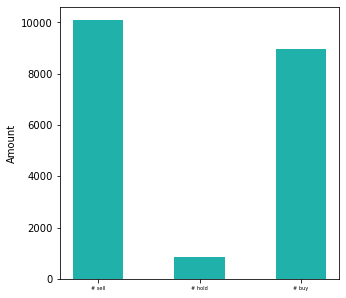

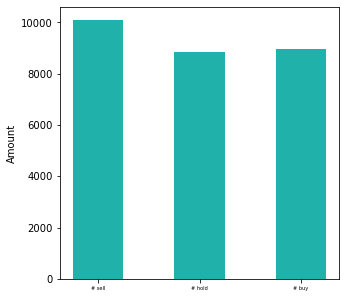

In [34]:
##### Checking for class imbalance

# nr of rows with recommendation -1
n_sell = len(df[df['recommendation'] == -1])

# nr of rows with recommendation 0 
n_hold = len(df[df['recommendation'] == 0])

# nr of rows with recommendation 1
n_buy = len(df[df['recommendation'] == 1])

sum_n = n_sell + n_hold + n_buy

print('BEFORE UPSAMPLING:')
print('Number of titels to sell: {}, {:.2%}'.format(n_sell, n_sell/sum_n))
print('Number of titels to hold: {}, {:.2%}'.format(n_hold, n_hold/sum_n))
print('Number of titels to buy: {}, {:.2%}\n'.format(n_buy, n_buy/sum_n))

# plot amounts
plt.figure(figsize=(5, 5))
plt.bar(range(3), [n_sell, n_hold, n_buy], width=0.5, align ='center', color='lightseagreen')
plt.xticks(range(3), ['# sell', '# hold', '# buy'])
plt.ylabel('Amount')


# since there is class imbalance:
# function that is used for upsampling

def upsampling(X, y):
    # upsampling of class "hold" (# = 8000)
    X_upsampled, y_upsampled = resample(X[y==0], y[y==0], replace=True, n_samples=8000, random_state=0)
    X_bal = np.vstack((X, X_upsampled))
    y_bal = np.hstack((y, y_upsampled))
    return X_bal, y_bal
                                        
# only show new balance that will be used later
X_show = df.drop(['recommendation'], axis=1, inplace=False)
y_show = df['recommendation']
print(X_show.shape)
print(y_show.shape)

X_bal = upsampling(X_show, y_show)[0]
y_bal = upsampling(X_show, y_show)[1]

print('Shape of X_bal after: {}\n'.format(X_bal.shape))

n_hold_new = np.sum(y_bal == 0)
sum_new = n_sell+n_hold_new+n_buy

print('AFTER UPSAMPLING:')
print('Number of titels to sell: {}, {:.2%}'.format(n_sell, n_sell/sum_new))
print('Number of titels to hold: {}, {:.2%}'.format(n_hold_new, n_hold_new/sum_new))
print('Number of titels to buy: {}, {:.2%}'.format(n_buy, n_buy/sum_new))

# plot amounts
plt.figure(figsize=(5, 5))
plt.bar(range(3), [n_sell, n_hold_new, n_buy], width=0.5, align ='center', color='lightseagreen')
plt.xticks(range(3), ['# sell', '# hold', '# buy'])
plt.ylabel('Amount')


### 7.2 Removing Constant Features

Features that have the same value for all stocks provide no inforamtion that helps the classifiaction. Therefore we remove those features from the dataset.

In [35]:
##### Removing Constant Features using Variance Threshold


# not including the dummy variables (only until 'Momentum')
# Momentum is last not-dummy column: [...'SG&A Expenses Growth', 'Momentum', 'recommendation', 'Basic Materials',...]
pos_mom = df.columns.get_loc("Momentum")+1
X_num = df.iloc[:, :pos_mom]

feat_labels_num = feat_labels[:pos_mom]

# get constant features
constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(X_num)
feat_labels_num = np.array(feat_labels_num) 
print('Out of {} features {} are constant \n'.format(len(feat_labels), len(feat_labels_num)-len(feat_labels_num[constant_filter.get_support()])))

constant_features = [f for f in feat_labels_num if f not in feat_labels_num[constant_filter.get_support()]]

print('Constant features: \n' + 30*'-')
for feature in constant_features: print(feature)

# remove constant features   
feat_labels = [f for f in feat_labels if f not in constant_features]
print(len(feat_labels))


df.drop(labels=constant_features, axis=1, inplace=True)


VarianceThreshold(threshold=0)

Out of 208 features 5 are constant 

Constant features: 
------------------------------
Net Income - Non-Controlling int
Net Income - Discontinued ops
Preferred Dividends
Deposit Liabilities
operatingProfitMargin
203


### 7.3 Removing Highly Correlated Features

If two or more features are highly correlated, they convey redundant information to the model. Therefore, we retain only one of the correlated features to reduce the number of features.

In [36]:
##### remove highly correlated features

# use df without response column and without dummy columns
# Momentum is last not-dummy column
df_num = df.iloc[:,:pos_mom]

correlated_features = set()   # empty set that will contain names of all correlated features
correlation_matrix = df_num.corr()   # corr matrix

# loop through all col in corr matrix and add col with corr value > 0.8 to set
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if correlation_matrix.iloc[i, j] > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print('{} of {} features have a correlation > 0.8  ({:.2%})'.format(len(correlated_features), len(feat_labels), len(correlated_features)/len(feat_labels)))



# remove correlated features
feat_labels = [f for f in feat_labels if f not in correlated_features]
print(len(feat_labels))
df.drop(labels=correlated_features, axis=1, inplace=True)


print('#Features new: {}'.format(len(feat_labels)))

75 of 203 features have a correlation > 0.8  (36.95%)
128
#Features new: 128


## 8. Model fitting

In [102]:
#We store all the test scores to visualize and compare them in the conclusion
test_scores = [] 
#We store the final dataset that we use for fitting the models
%store df

Stored 'df' (DataFrame)


### 8.1 Random Forest Classifier for Feature Selection

Random forest model needs to be trained on the balanced data set!

Since Gini index and cross-entropy usually produce similar results (Raschka (2015), we use directly the gini index which is computationally faster 


Instead of selecting the top n features we select only those features whose combined importance is greater or equal to the median.

In [1]:
#####preparing the dependent and independent variables

X_ns = df.drop(['recommendation'], axis=1, inplace=False)
y_ns = df['recommendation']

X_ns = pd.DataFrame.to_numpy(X_ns)
y_ns = pd.DataFrame.to_numpy(y_ns)
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(X_ns, y_ns, test_size=0.2, random_state=0, stratify=y_ns)
print('Old shape:\n')
print(X_ns.shape)
print(y_ns.shape)

# upsampling with defined function
X = upsampling(X_ns, y_ns)[0]
y = upsampling(X_ns, y_ns)[1]

print('\nNew shape:')
print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
print('\nTrain/Test:')
print(X_train.shape, X_test.shape)

#create 10-fold CV object
kFold = StratifiedKFold(n_splits=10)


NameError: name 'df' is not defined

RandomForestClassifier()

RandomForestClassifier()

test accuracy:  0.8082
test accuracy:  0.6264
Selected Features:
 1) Momentum                                           0.0284
 2) Inflation_PBR                                      0.0201
 3) Inflation_PER                                      0.0152
 4) Earnings Yield                                     0.0124
 5) Weighted Average Shares Growth                     0.0118
 6) Weighted Average Shs Out                           0.0117
 7) SG&A Expenses Growth                               0.0113
 8) enterpriseValueMultiple                            0.0113
 9) Book Value per Share Growth                        0.0111
10) 3Y Revenue Growth (per Share)                      0.0110
11) priceToOperatingCashFlowsRatio                     0.0110
12) Free Cash Flow growth                              0.0109
13) priceFairValue                                     0.0109
14) SG&A to Revenue                                    0.0109
15) Operating Cash Flow growth                         0.0108
16) R

<Figure size 1200x800 with 0 Axes>

<BarContainer object of 64 artists>

([<matplotlib.axis.XTick at 0x7f82a53525b0>,
 [Text(0, 0, 'Momentum'),
  Text(0, 0, 'Inflation_PBR'),
  Text(0, 0, 'Inflation_PER'),
  Text(0, 0, 'Earnings Yield'),
  Text(0, 0, 'Weighted Average Shares Growth'),
  Text(0, 0, 'Weighted Average Shs Out'),
  Text(0, 0, 'SG&A Expenses Growth'),
  Text(0, 0, 'enterpriseValueMultiple'),
  Text(0, 0, 'Book Value per Share Growth'),
  Text(0, 0, '3Y Revenue Growth (per Share)'),
  Text(0, 0, 'priceToOperatingCashFlowsRatio'),
  Text(0, 0, 'Free Cash Flow growth'),
  Text(0, 0, 'priceFairValue'),
  Text(0, 0, 'SG&A to Revenue'),
  Text(0, 0, 'Operating Cash Flow growth'),
  Text(0, 0, 'Revenue Growth'),
  Text(0, 0, 'EV to Free cash flow'),
  Text(0, 0, 'Asset Growth'),
  Text(0, 0, 'cashPerShare'),
  Text(0, 0, '3Y Shareholders Equity Growth (per Share)'),
  Text(0, 0, 'priceBookValueRatio'),
  Text(0, 0, 'operatingCashFlowPerShare'),
  Text(0, 0, 'assetTurnover'),
  Text(0, 0, 'EPS'),
  Text(0, 0, 'Effect of forex changes on cash'),
  Text(0

(-1.0, 64.0)

Text(0.5, 0, 'Feature')

Text(0, 0.5, 'Relative Feature Importance')

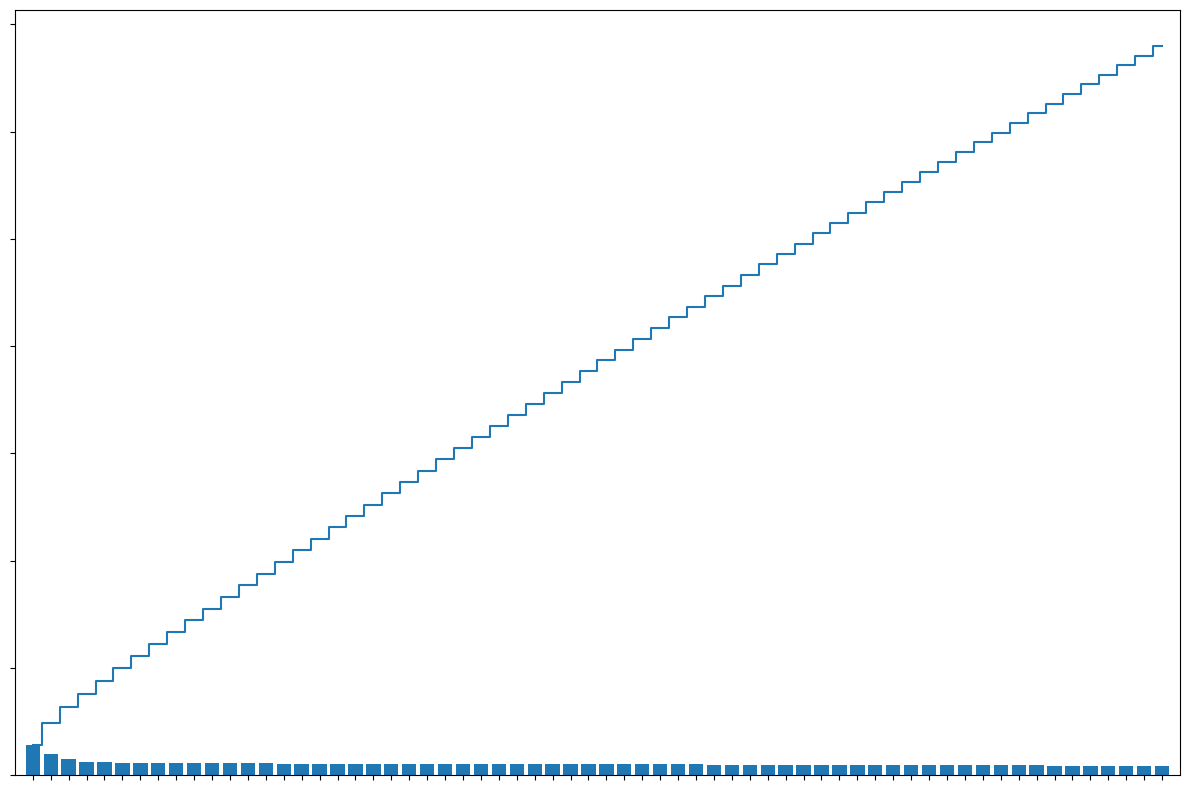

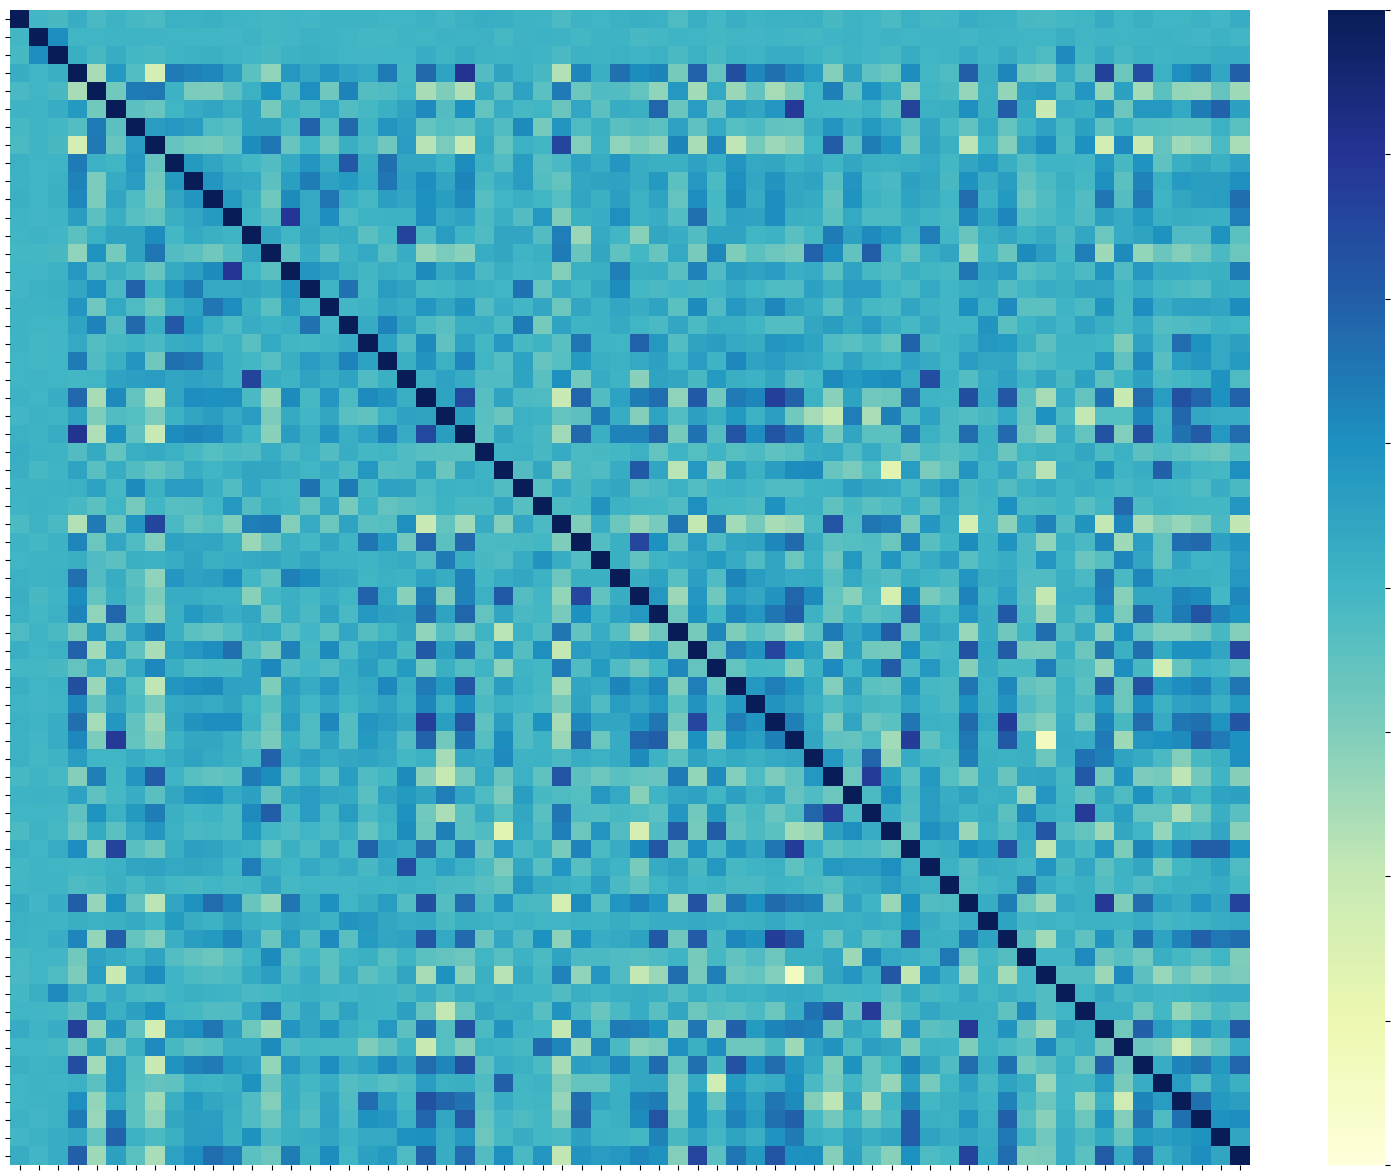

In [114]:
##### Feature Selection with Random Forest Classifier
# this is used later directly in the pipeline
# this part is only to show which features are kept and to show their cumulative importance

rf_fs = RandomForestClassifier()   
rf_fs.fit(X_train, y_train)
rf_fs.fit(X_train_ns, y_train_ns)
print('test accuracy: {0: .4f}'.format(rf_fs.score(X_test, y_test)))
print('test accuracy: {0: .4f}'.format(rf_fs.score(X_test_ns, y_test_ns)))

# if you want top n features:
importances = rf_fs.feature_importances_
indices = np.argsort(importances)[::-1]

# if you want importance > median:
feature_selection = SelectFromModel(rf_fs, threshold='median', prefit=True)  # prefit=True because fitted above
feat_labels = np.array(feat_labels)
selected_feat = feat_labels[(feature_selection.get_support())]
print('Selected Features:')

for i in range(len(selected_feat)):
    print('{0:2d}) {1:50s} {2:6.4f}'.format(i+1, feat_labels[indices[i]], importances[indices[i]]))

# plot result
n = len(selected_feat)
feat_imp = np.sort(importances)[::-1]
sum_feat_imp = np.cumsum(feat_imp)[:n]

print('Cumulated importance: {}'.format(sum(feat_imp[:n])))

plt.figure(figsize=(12, 8))
plt.bar(range(n), importances[indices[:n]], align ='center')
plt.xticks(range(n), feat_labels[indices[:n]], rotation =90)
plt.xlim([-1, n])
plt.xlabel('Feature')
plt.ylabel('Relative Feature Importance')
plt.step(range(n), sum_feat_imp , where ='mid', label = 'Cumulative importance')
plt.tight_layout();

##### Correlation matrix
# check if there are still highly correlated features
s_f = []
for i in range(len(selected_feat)):
    s_f.append(feat_labels[indices[i]])
    
fs_df = df[[f for f in s_f]]

fig1, ax1 = plt.subplots(figsize=(20,15)) 
sns.heatmap(fs_df.corr(), annot=False, cmap='YlGnBu', vmin=-1, vmax=1, center=0, ax=ax1)
plt.show()

**Remark:** After removing the highly correlated and the constant features, the importance values increased significantly

In [115]:
##### Definition of functions for performance measures

### ROC Curve
def plot_roc_curve(clf, X, y):
    
    cl = [-1, 0, 1]
    y_bin = label_binarize(y, classes=cl)
    n_classes = len(cl)
    
    X_train_roc, X_test_roc, y_train_roc, y_test_roc = train_test_split(X, y_bin, test_size=0.2, random_state=0, stratify=y)

    # OnceVsRestClassifier because ROC Curve only fro binary classification
    ovr_clf = OneVsRestClassifier(clf)
    y_score = ovr_clf.fit(X_train_roc, y_train_roc).decision_function(X_test_roc)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_roc[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    ## Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_roc.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    ## Compute macro-average ROC curve and ROC area
    # aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='darkorange', linestyle=':', linewidth=2)

    plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='deeppink', linestyle=':', linewidth=2)


    colors = ['aqua', 'mediumblue', 'cornflowerblue']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, linewidth=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(cl[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

### Plot Confusion Matrix
#defining a plot function for a fancy confusion matrix
plt.style.use('default')
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print('normalized confusion matrix')
    else :
        print ('Confusion matrix , without normalization ')
    print (cm)

    plt.imshow (cm , interpolation ='nearest', cmap = cmap )
    plt.title ( title )
    plt.colorbar ()
    tick_marks = np. arange (len( classes ))
    plt.xticks ( tick_marks , classes , rotation =45)
    plt.yticks ( tick_marks , classes )
    fmt = '.2f' if normalize else 'd'
    thresh = cm. max () / 2.
    for i, j in itertools.product ( range (cm. shape [0]), range (cm. shape [1 ])):
        plt.text (j, i, format (cm[i, j], fmt ), horizontalalignment ="center", color ="white" if cm[i, j] > thresh else "black")
    plt.tight_layout ()
    plt.ylabel ('True label')
    plt.xlabel ('Predicted label')
    
# Precision
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()

# Recall
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

### 8.2 Decision tree

In [116]:
#####grid search for UNBALANCED data
#max depth
max_depth = np.array([5]) 
    #first iteration with (1, 5, 10): 10 was best
    #second iteration with (5, 10, 15): 5 was still best
    #third iteration with (4, 5, 6): 5 was still best
#min #samples required to split any internal node
minSamplesNode = np.array([20]) 
    #first iteration with (2, 10, 50): 50 was best 
    #second iteration with (40, 50, 60), 40 was best
    #third iteration with (30, 40, 50), 30 was best
    #fourth iteration with (20, 30, 40) 20 was best
    #after fifth iterartion with (10, 20, 30) 20 was still best
#min #samples required to be at a leaf/terminal node
minSamplesLeaf = np.array([10])
    #first iteration with (2, 10, 50): 10 was best 


pipe_dt_ns = Pipeline([('feature_selection', SelectFromModel(RandomForestClassifier(), threshold='median')),
                     ('DT', DecisionTreeClassifier(random_state=0))])

#define hyperparameter values
param_grid = {'DT__criterion': ['gini'], 
                  #when running this the first time gini resulted in the best accuarcy and hence for faster execution we only use gini
                  #first iteration with (gini, entropy) gini was best
                  #second iteration gini was still best
             'DT__max_depth': max_depth,
             'DT__min_samples_split': minSamplesNode,
             'DT__min_samples_leaf': minSamplesLeaf}

#initialize brute force grid search
gs = GridSearchCV(estimator=pipe_dt_ns,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=kFold,
                 n_jobs=-1)
#run brute force grid search
gs=gs.fit(X_train_ns, y_train_ns)
print(gs.best_score_)
print(gs.best_params_)
    #this trains and tunes a DecisionTreeClassifier on the given parameter grid

    
#extract best params
extr_bp = gs.best_estimator_ #extr_bp: extract best parameters
#fit with best params
extr_bp.fit(X_train_ns, y_train_ns)
#print score
print('test accuracy: {0: .4f}'.format(extr_bp.score(X_test_ns, y_test_ns)))

y_pred_gs = gs.predict(X_test_ns)

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}

In [104]:
%store gs
%store extr_bp

Stored 'gs' (GridSearchCV)
Stored 'extr_bp' (Pipeline)


In [42]:
#####grid search for BALANCED data
#max depth
max_depth = np.array([30]) 
    #first iteration with (1, 5, 10), 10 was best
    #second iteration with (5, 10, 15), 15 was best
    #third iteration with (10, 15, 20), 20 was best
    #fourth iteration with (15, 20, 25), 25 was best
    #fifth iteration with (20, 30, 40), 30 was best
#min samples required to split any internal node
minSamplesNode = np.array([5]) 
    #first iteration with (2, 10, 50): 2 was best 
    #second iteration with (2, 5), 5 was best
    #third iteration with (2, 5, 10),  5 was best
#min samples required to be at a leaf/terminal node
minSamplesLeaf = np.array([2])
    #first iteration with (2, 5, 10), 2 was best
    #second iteration with (2, 5), 2 was best
    #third iteration with (2, 5), 2 was best
    
pipe_dt = Pipeline([('feature_selection', SelectFromModel(RandomForestClassifier(), threshold='median')),
                     ('DT', DecisionTreeClassifier(random_state=0))])

#define hyperparameter values
param_grid = {'DT__criterion': ['gini'], 
                  #when running this the first time gini resulted in the best accuarcy and hence for faster execution we only use gini
                  #first iteration with (gini, entropy) gini was best
                  #second iteration gini was still best
             'DT__max_depth': max_depth,
             'DT__min_samples_split': minSamplesNode,
             'DT__min_samples_leaf': minSamplesLeaf}

#initialize brute force grid search
gs = GridSearchCV(estimator=pipe_dt,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=kFold,
                 n_jobs=-1)
#run brute force grid search
gs=gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)
    #this trains and tunes a DecisionTreeClassifier on the given parameter grid

    
#extract best params
extr_bp = gs.best_estimator_ #extr_bp: extract best parameters
#fit with best params
extr_bp.fit(X_train, y_train)
#print score
print('test accuracy: {0: .4f}'.format(extr_bp.score(X_test, y_test)))

y_pred_gs = gs.predict(X_test)

0.6756829377519032
{'DT__criterion': 'gini', 'DT__max_depth': 30, 'DT__min_samples_leaf': 2, 'DT__min_samples_split': 5}


Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier(),
                                 threshold='median')),
                ('DT',
                 DecisionTreeClassifier(max_depth=30, min_samples_leaf=2,
                                        min_samples_split=5, random_state=0))])

test accuracy:  0.6790


In [43]:
test_scores.append(('Decision Tree', extr_bp.score(X_test, y_test)))

In [44]:
#####grid search for BALANCED data
#WITHOUT FEATURE SELECTION
#max depth
max_depth = np.array([30]) 
    #first iteration with (1, 5, 10), 10 was best
    #second iteration with (5, 10, 15), 15 was best
    #third iteration with (10, 15, 20), 20 was best
    #fourth iteration with (15, 20, 25), 25 was best
    #fifth iteration with (20, 30, 40), 30 was best
#min samples required to split any internal node
minSamplesNode = np.array([5]) 
    #first iteration with (2, 10, 50): 2 was best 
    #second iteration with (2, 5), 5 was best
    #third iteration with (2, 5, 10),  5 was best
#min samples required to be at a leaf/terminal node
minSamplesLeaf = np.array([2])
    #first iteration with (2, 5, 10), 2 was best
    #second iteration with (2, 5), 2 was best
    #third iteration with (2, 5), 2 was best

#define hyperparameter values
param_grid = {'criterion': ['gini'], 
                  #when running this the first time gini resulted in the best accuarcy and hence for faster execution we only use gini
                  #first iteration with (gini, entropy) gini was best
                  #second iteration gini was still best
             'max_depth': max_depth,
             'min_samples_split': minSamplesNode,
             'min_samples_leaf': minSamplesLeaf}

#initialize brute force grid search
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=kFold,
                 n_jobs=-1)
#run brute force grid search
gs=gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)
    #this trains and tunes a DecisionTreeClassifier on the given parameter grid

    
#extract best params
extr_bp_nfs = gs.best_estimator_ #extr_bp: extract best parameters
#fit with best params
extr_bp_nfs.fit(X_train, y_train)
#print score
print('test accuracy: {0: .4f}'.format(extr_bp_nfs.score(X_test, y_test)))

y_pred_gs = gs.predict(X_test)

0.6770712046574114
{'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5}


DecisionTreeClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=5,
                       random_state=0)

test accuracy:  0.6767


In [45]:
test_scores.append(('Decision Tree (without feature slection)', extr_bp_nfs.score(X_test, y_test)))

In [46]:
#####randomized parameter search
#WITHOUT FEATURE SELECTION

#build classifier
#clf = SGDClassifier()
clf = RandomForestClassifier()


#specify parameters and distribution to sample from
param_dist = {'criterion': ['gini', 'entropy'],
             'max_depth': stats.uniform(1,15),
             'min_samples_split': [2, 5, 10, 15, 20, 30, 50],
             'min_samples_leaf': [2, 5, 10, 15, 20, 30, 50]}

#initialize random search
random_search = RandomizedSearchCV(clf,
                                  param_distributions = param_dist,
                                  n_iter = 10, cv = kFold, n_jobs=-1, random_state = 0, return_train_score = True)

random_search_ns = RandomizedSearchCV(clf,
                                  param_distributions = param_dist,
                                  n_iter = 10, cv = kFold, n_jobs=-1, random_state = 0, return_train_score = True)

#run random search for train set
random_search_ns.fit(X_train_ns, y_train_ns) #unbalanced
random_search.fit(X_train, y_train) #balanced

# utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

report(random_search.cv_results_)

#results
print('\n\nresults on unbalanced data:')
report(random_search_ns.cv_results_)
print('\n\nresults on balanced data:')
report(random_search.cv_results_)

print('results on test set (unbalanced): {0: .4f}'.format(random_search_ns.score(X_test_ns, y_test_ns)))
print('results on test set (balanced): {0: .4f}'.format(random_search.score(X_test, y_test)))

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f83a6696730>,
                                        'min_samples_leaf': [2, 5, 10, 15, 20,
                                                             30, 50],
                                        'min_samples_split': [2, 5, 10, 15, 20,
                                                              30, 50]},
                   random_state=0, return_train_score=True)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f83a6696730>,
                                        'min_samples_leaf': [2, 5, 10, 15, 20,
                                                             30, 50],
                                        'min_samples_split': [2, 5, 10, 15, 20,
                                                              30, 50]},
                   random_state=0, return_train_score=True)

Model with rank: 1
Mean validation score: 0.752 (std: 0.005)
Parameters: {'criterion': 'entropy', 'max_depth': 13.541181453060663, 'min_samples_leaf': 2, 'min_samples_split': 5}

Model with rank: 2
Mean validation score: 0.744 (std: 0.005)
Parameters: {'criterion': 'entropy', 'max_depth': 12.987378463250854, 'min_samples_leaf': 15, 'min_samples_split': 30}

Model with rank: 3
Mean validation score: 0.743 (std: 0.005)
Parameters: {'criterion': 'entropy', 'max_depth': 11.183192951784404, 'min_samples_leaf': 2, 'min_samples_split': 5}



results on unbalanced data:
Model with rank: 1
Mean validation score: 0.633 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': 9.173247744953454, 'min_samples_leaf': 5, 'min_samples_split': 15}

Model with rank: 2
Mean validation score: 0.630 (std: 0.010)
Parameters: {'criterion': 'entropy', 'max_depth': 12.987378463250854, 'min_samples_leaf': 15, 'min_samples_split': 30}

Model with rank: 3
Mean validation score: 0.630 (std: 0.008)
Parameters

In [47]:
##### random forest
#initialize rf - we initiate two different Class invariants one for the balanced and one for the unbalanced data
rf_ns_fs = RandomForestClassifier(criterion = 'gini', random_state=0, n_jobs=-1)
rf_fs = RandomForestClassifier(criterion = 'gini', random_state=0, n_jobs=-1)

rf_ns_fs = Pipeline([('feature_selection', SelectFromModel(RandomForestClassifier(), threshold='median')),
                     ('RF', rf_ns_fs)])
rf_fs = Pipeline([('feature_selection', SelectFromModel(RandomForestClassifier(), threshold='median')),
                     ('RF', rf_fs)])

###for unbalanced data
#fit rf
rf_ns_fs.fit(X_train_ns, y_train_ns)
#test score
print('test accuracy: {0: .4f}'.format(rf_ns_fs.score(X_test_ns, y_test_ns)))

###for balanced data
#fit rf
rf_fs.fit(X_train, y_train)
#test score
print('test accuracy: {0: .4f}'.format(rf_fs.score(X_test, y_test)))

#as one can see, the accuracy is much higher for the balanced data set (.75 vs. .63)

Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier(),
                                 threshold='median')),
                ('RF', RandomForestClassifier(n_jobs=-1, random_state=0))])

test accuracy:  0.6329


Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier(),
                                 threshold='median')),
                ('RF', RandomForestClassifier(n_jobs=-1, random_state=0))])

test accuracy:  0.7539


In [48]:
test_scores.append(('Random Forest', rf_fs.score(X_test, y_test)))

In [49]:
##### random forest
#WITHOUT FEATURE SELECTION
#initialize rf - we initiate two different Class invariants one for the balanced and one for the unbalanced data
rf_ns = RandomForestClassifier(criterion = 'gini', random_state=0, n_jobs=-1)
rf = RandomForestClassifier(criterion = 'gini', random_state=0, n_jobs=-1)

###for unbalanced data
#fit rf
rf_ns.fit(X_train_ns, y_train_ns)
#test score
print('test accuracy: {0: .4f}'.format(rf_ns.score(X_test_ns, y_test_ns)))

###for balanced data
#fit rf
rf.fit(X_train, y_train)
#test score
print('test accuracy: {0: .4f}'.format(rf.score(X_test, y_test)))

#as one can see, the accuracy is much higher for the balanced data set (.75 vs. .63)

RandomForestClassifier(n_jobs=-1, random_state=0)

test accuracy:  0.6332


RandomForestClassifier(n_jobs=-1, random_state=0)

test accuracy:  0.7550


In [50]:
test_scores.append(('Random Forest (without feature selection)', rf.score(X_test, y_test)))

number of predictions for buy, sell and hold respectively (unbalanced):


1674

2308

1



basic confusion matrix for our prediction (unbalanced):


array([[1474,    0,  545],
       [  87,    1,   82],
       [ 747,    0, 1047]])



non-normalized confusion matrix (unbalanced):


<Figure size 640x480 with 0 Axes>

Confusion matrix , without normalization 
[[1474    0  545]
 [  87    1   82]
 [ 747    0 1047]]


normalized confusion matrix (unbalanced):


<Figure size 640x480 with 0 Axes>

normalized confusion matrix
[[0.73 0.   0.27]
 [0.51 0.01 0.48]
 [0.42 0.   0.58]]


true proportions of buy, hold and sell for our test sample (unbalanced):


0.4504142606075822

0.042681395932714035

0.5069043434597037



for unbalanced data:
      PRECISION  RECALL
    0     0.639  0.730
    1     1.000  0.006
    2     0.625  0.584


number of predictions for buy, sell and hold respectively (balanced):


1495

2314

1774



basic confusion matrix for our prediction (balanced):


array([[1483,    3,  533],
       [   0, 1770,    0],
       [ 831,    1,  962]])



non-normalized confusion matrix (balanced):


<Figure size 640x480 with 0 Axes>

Confusion matrix , without normalization 
[[1483    3  533]
 [   0 1770    0]
 [ 831    1  962]]


normalized confusion matrix (balanced):


<Figure size 640x480 with 0 Axes>

normalized confusion matrix
[[7.35e-01 1.49e-03 2.64e-01]
 [0.00e+00 1.00e+00 0.00e+00]
 [4.63e-01 5.57e-04 5.36e-01]]


true proportions of buy, hold and sell for our test sample (balanced):


0.32133261687264913

0.31703385276732937

0.3616335303600215



for balanced data:
      PRECISION  RECALL
    0     0.641  0.735
    1     0.998  1.000
    2     0.643  0.536


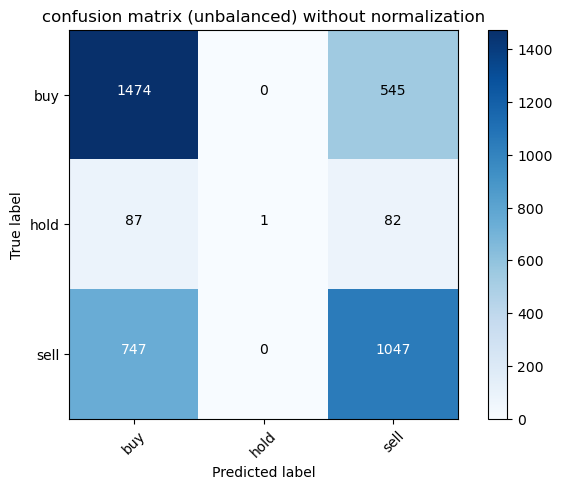

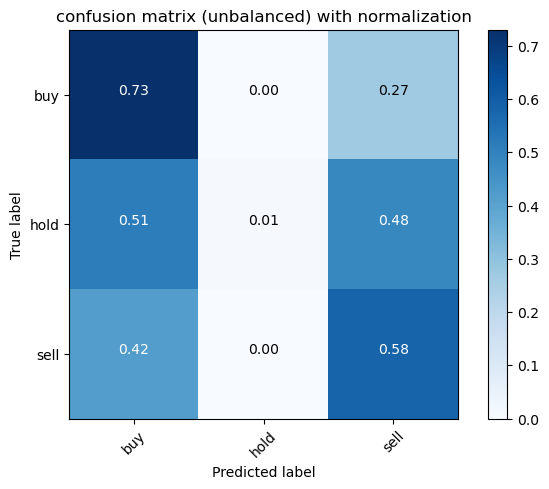

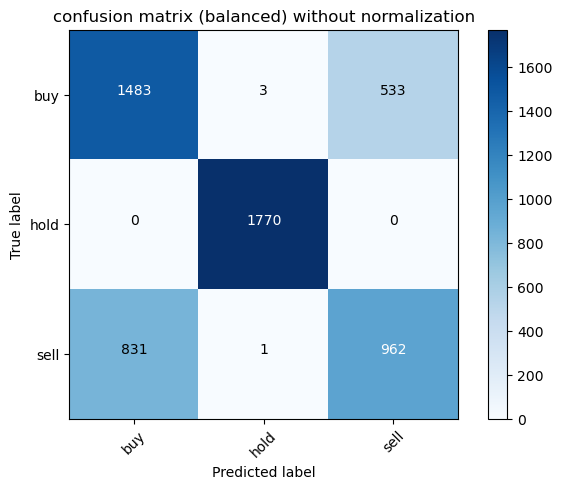

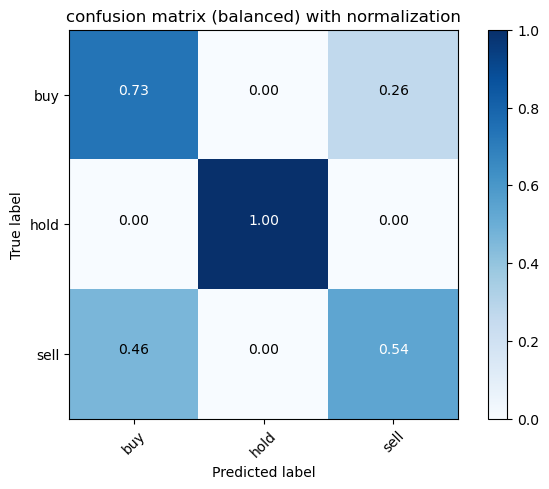

In [51]:
##### performance measures (for our random forest model with feature selection)
#WITHOUT FEATURE SELECTION

###for unbalanced data
y_pred_rf_ns = rf_ns.predict(X_test_ns)

#count the absolute number of predicitions for buy, hold and sell worthy stocks
print('number of predictions for buy, sell and hold respectively (unbalanced):')
len(y_pred_rf_ns[y_pred_rf_ns==1])
len(y_pred_rf_ns[y_pred_rf_ns==-1])
len(y_pred_rf_ns[y_pred_rf_ns==0])

#construct a basic confusion matrix for our prediction
print('\n\nbasic confusion matrix for our prediction (unbalanced):')
confusion_matrix(y_test_ns, y_pred_rf_ns)
    
#compute confusion matrix
cfm_matrix_rf_ns = confusion_matrix(y_test_ns, y_pred_rf_ns)
np.set_printoptions(precision = 2)

#plot non-normalized confusion matrix
print('\n\nnon-normalized confusion matrix (unbalanced):')
plt.figure()
plot_confusion_matrix(cfm_matrix_rf_ns, classes=['buy', 'hold', 'sell'], title = 'confusion matrix (unbalanced) without normalization')

#plot normalized confusion matrix
print('\n\nnormalized confusion matrix (unbalanced):')
plt.figure()
plot_confusion_matrix(cfm_matrix_rf_ns, classes=['buy', 'hold', 'sell'], normalize = True, title = 'confusion matrix (unbalanced) with normalization')

#true proportions of buy, hold and sell stock for our test sample
print('\n\ntrue proportions of buy, hold and sell for our test sample (unbalanced):')
len(y_test_ns[y_test_ns == 1])/len(y_test_ns)
len(y_test_ns[y_test_ns == 0])/len(y_test_ns)
len(y_test_ns[y_test_ns == -1])/len(y_test_ns)

#print precision and recall
print('\n\nfor unbalanced data:')
for label in np.arange(0,3):
    if not label:
        print("      PRECISION  RECALL")
    print(f"{label:5d} {precision(label, cfm_matrix_rf_ns):9.3f} {recall(label, cfm_matrix_rf_ns):6.3f}")

    
    

###for balanced data
#predict performance with our random forest model defined above
y_pred_rf = rf.predict(X_test)

#count the absolute number of predicitions for buy, hold and sell worthy stocks
print('\n\nnumber of predictions for buy, sell and hold respectively (balanced):')
len(y_pred_rf[y_pred_rf==1])
len(y_pred_rf[y_pred_rf==-1])
len(y_pred_rf[y_pred_rf==0])

#construct a basic confusion matrix for our prediction
print('\n\nbasic confusion matrix for our prediction (balanced):')
confusion_matrix(y_test, y_pred_rf)

    
#compute confusion matrix
cfm_matrix_rf = confusion_matrix(y_test, y_pred_rf)
np.set_printoptions(precision = 2)

#plot non-normalized confusion matrix
print('\n\nnon-normalized confusion matrix (balanced):')
plt.figure()
plot_confusion_matrix(cfm_matrix_rf, classes=['buy', 'hold', 'sell'], title = 'confusion matrix (balanced) without normalization')

#plot normaliized confusion matrix
print('\n\nnormalized confusion matrix (balanced):')
plt.figure()
plot_confusion_matrix(cfm_matrix_rf, classes=['buy', 'hold', 'sell'], normalize = True, title = 'confusion matrix (balanced) with normalization')

#true proportions of buy, hold and sell stock for our test sample
print('\n\ntrue proportions of buy, hold and sell for our test sample (balanced):')
len(y_test[y_test == 1])/len(y_test)
len(y_test[y_test == 0])/len(y_test)
len(y_test[y_test == -1])/len(y_test)

#print precision and recall
print('\n\nfor balanced data:')
for label in np.arange(0,3):
    if not label:
        print("      PRECISION  RECALL")
    print(f"{label:5d} {precision(label, cfm_matrix_rf):9.3f} {recall(label, cfm_matrix_rf):6.3f}")


#### interpretation random forest classifier (**unbalanced data**)
from the data set we have the following percentages of buy, hold and sell worthy stock respectively:
* buy: ca. 45%
* hold: ca. 5%
* sell: ca. 50%
according to our rf model we have the following precisions:

if we look at a buy, hold, sell worthy stock our model will recognize:
* a buy worthy stock 74 times out of 100
* a hold worthy stock 1 times out of 100
* a sell worthy stock 56 times out of 100

this tells us that:
* our model recognizes buy worthy stocks well, i.e., if we really do have a buy worthy stock chances of the model classifying it as such is higher as a naive(*) classification
* our model performs badly for hold worhty stocks which could be due to the fact that we've got a rather high class imbalance
* for sell worthy stocks our model performs on a good level but not as good as for buy worthy stocks

some other interesting findings include:
* not a single buy or sell worty stock has been wrongly calssified as hold worthy stock
* hold worthy stocks have been wrongly labled as buy or sell worthy almost perfectly even (84 as buy, 85 as sell)
* although the model performs better for buy and sell worthy stocks than a naive(*) classification we still have quite a lot of misclassifications

(*) by naive classification we mean a classification solely based on the percentage of buy, hold or sell worthy stock (as described above)

#### interpretation random forest classifier (**balanced data**)
from the data set we have the following percentages of buy, hold and sell worthy stock respectively:
* buy: ca. 32%
* hold: ca. 32%
* sell: ca. 36%
according to our rf model we have the following precisions:

if we look at a buy, hold, sell worthy stock our model will recognize:
* a buy worthy stock 73 times out of 100
* a hold worthy stock 100 times out of 100
* a sell worthy stock 54 times out of 100

this tells us that:
* our model recognizes buy worthy stocks well, i.e., if we really do have a buy worthy stock chances of the model classifying it as such is much higher as a naive(*) classification
* our model performs perfectly for hold worhty stocks
* for sell worthy stocks our model performs on a good level but not as good as for buy worthy stocks

some other interesting findings include:
* only two stocks which are actually buy worthy have been classified as hold worthy
* hold worthy stocks have been correctly labled every single time
* although the model performs better for buy and sell worthy stocks than a naive(*) classification we still have quite a lot of misclassifications

(*) by naive classification we mean a classification solely based on the percentage of buy, hold or sell worthy stock (as described above)


#### comparison unbalanced vs. balanced data
* the most obvious change when working with balanced data is that hold worthy stock is classified perfectly, in contrast to the unbalanced data, where hold worthy stock has (almost) always been misclassified
* the model performs slightly worse for buy and sell worthy stock when working with the balanced data
* what stays the same is that neither buy nor sell worthy stock will be classified as hold worthy stock almost every time

In [52]:
##### random forest (with values obtained from randomized search)
#initialize rf - we initiate two different Class invariants one for the balanced and one for the unbalanced data
rf_ns_rand_fs = RandomForestClassifier(criterion = 'entropy', max_depth = 9, min_samples_leaf = 5, min_samples_split = 15, random_state=0, n_jobs=-1)
rf_rand_fs = RandomForestClassifier(criterion = 'entropy', max_depth = 13, min_samples_leaf = 2, min_samples_split = 5, random_state=0, n_jobs=-1)

rf_ns_rand_fs = Pipeline([('feature_selection', SelectFromModel(RandomForestClassifier(), threshold='median')),
                     ('RF', rf_ns_rand_fs)])
rf_rand_fs = Pipeline([('feature_selection', SelectFromModel(RandomForestClassifier(), threshold='median')),
                     ('RF', rf_rand_fs)])

###for unbalanced data
#fit rf
rf_ns_rand_fs.fit(X_train_ns, y_train_ns)
#test score
print('test accuracy: {0: .4f}'.format(rf_ns_rand_fs.score(X_test_ns, y_test_ns)))

###for balanced data
#fit rf
rf_rand_fs.fit(X_train, y_train)
#test score
print('test accuracy: {0: .4f}'.format(rf_rand_fs.score(X_test, y_test)))

#as one can see, the accuracy is much higher for the balanced data set (.75 vs. .63)

Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier(),
                                 threshold='median')),
                ('RF',
                 RandomForestClassifier(criterion='entropy', max_depth=9,
                                        min_samples_leaf=5,
                                        min_samples_split=15, n_jobs=-1,
                                        random_state=0))])

test accuracy:  0.6367


Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier(),
                                 threshold='median')),
                ('RF',
                 RandomForestClassifier(criterion='entropy', max_depth=13,
                                        min_samples_leaf=2, min_samples_split=5,
                                        n_jobs=-1, random_state=0))])

test accuracy:  0.7546


In [53]:
##### random forest (with values obtained from randomized search)
#WITHOUT FEATURE SELECTION
#initialize rf - we initiate two different Class invariants one for the balanced and one for the unbalanced data
rf_ns_rand = RandomForestClassifier(criterion = 'entropy', max_depth = 9, min_samples_leaf = 5, min_samples_split = 15, random_state=0, n_jobs=-1)
rf_rand = RandomForestClassifier(criterion = 'entropy', max_depth = 13, min_samples_leaf = 2, min_samples_split = 5, random_state=0, n_jobs=-1)


###for unbalanced data
#fit rf
rf_ns_rand.fit(X_train_ns, y_train_ns)
#test score
print('test accuracy: {0: .4f}'.format(rf_ns_rand.score(X_test_ns, y_test_ns)))

###for balanced data
#fit rf
rf_rand.fit(X_train, y_train)
#test score
print('test accuracy: {0: .4f}'.format(rf_rand.score(X_test, y_test)))

#as one can see, the accuracy is much higher for the balanced data set (.75 vs. .63)

RandomForestClassifier(criterion='entropy', max_depth=9, min_samples_leaf=5,
                       min_samples_split=15, n_jobs=-1, random_state=0)

test accuracy:  0.6445


RandomForestClassifier(criterion='entropy', max_depth=13, min_samples_leaf=2,
                       min_samples_split=5, n_jobs=-1, random_state=0)

test accuracy:  0.7587


number of predictions for buy, sell and hold respectively (unbalanced):


1536

2447

0



basic confusion matrix for our prediction (unbalanced):


array([[1562,    0,  457],
       [  96,    0,   74],
       [ 789,    0, 1005]])



non-normalized confusion matrix (unbalanced):


<Figure size 640x480 with 0 Axes>

Confusion matrix , without normalization 
[[1562    0  457]
 [  96    0   74]
 [ 789    0 1005]]


normalized confusion matrix (unbalanced):


<Figure size 640x480 with 0 Axes>

normalized confusion matrix
[[0.77 0.   0.23]
 [0.56 0.   0.44]
 [0.44 0.   0.56]]


true proportions of buy, hold and sell for our test sample (unbalanced):


0.4504142606075822

0.042681395932714035

0.5069043434597037



for unbalanced data:
      PRECISION  RECALL
    0     0.638  0.774
    1       nan  0.000
    2     0.654  0.560


number of predictions for buy, sell and hold respectively (balanced):


<ipython-input-40-28ea05759623>:94: RuntimeWarning: invalid value encountered in long_scalars
  return confusion_matrix[label, label] / col.sum()


1495

2314

1774



basic confusion matrix for our prediction (balanced):


array([[1483,    3,  533],
       [   0, 1770,    0],
       [ 831,    1,  962]])



non-normalized confusion matrix (balanced):


<Figure size 640x480 with 0 Axes>

Confusion matrix , without normalization 
[[1483    3  533]
 [   0 1770    0]
 [ 831    1  962]]


normalized confusion matrix (balanced):


<Figure size 640x480 with 0 Axes>

normalized confusion matrix
[[7.35e-01 1.49e-03 2.64e-01]
 [0.00e+00 1.00e+00 0.00e+00]
 [4.63e-01 5.57e-04 5.36e-01]]


true proportions of buy, hold and sell for our test sample (balanced):


0.32133261687264913

0.31703385276732937

0.3616335303600215



for balanced data:
      PRECISION  RECALL
    0     0.641  0.735
    1     0.998  1.000
    2     0.643  0.536


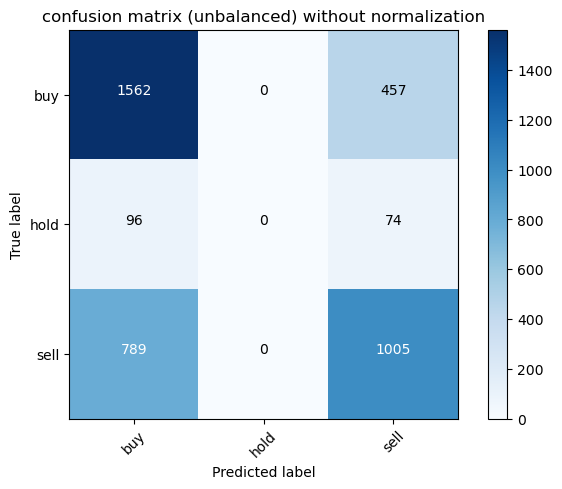

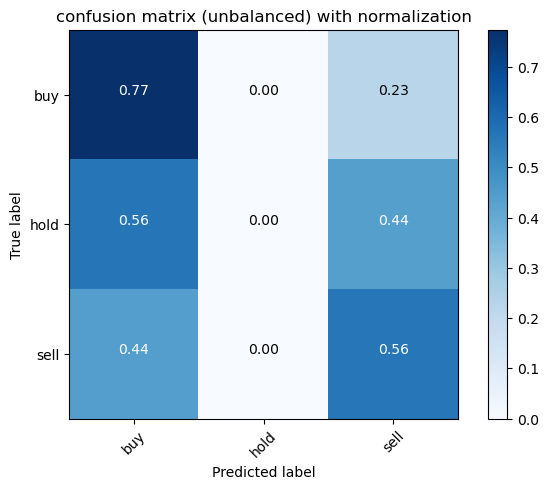

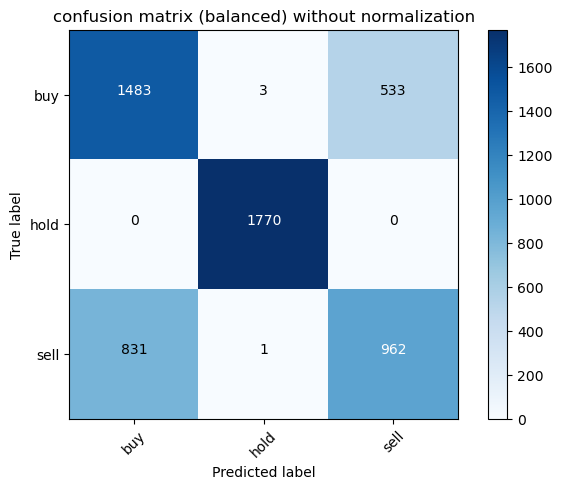

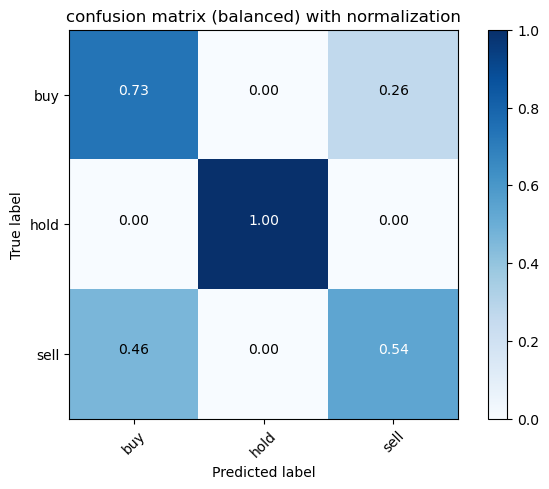

In [54]:
##### performance measures (for our random forest model with values obtained from randomized serach)
#WITHOUT FEATURE SELECTION

###for unbalanced data
y_pred_rf_ns_rand = rf_ns_rand.predict(X_test_ns)

#count the absolute number of predicitions for buy, hold and sell worthy stocks
print('number of predictions for buy, sell and hold respectively (unbalanced):')
len(y_pred_rf_ns_rand[y_pred_rf_ns_rand==1])
len(y_pred_rf_ns_rand[y_pred_rf_ns_rand==-1])
len(y_pred_rf_ns_rand[y_pred_rf_ns_rand==0])

#construct a basic confusion matrix for our prediction
print('\n\nbasic confusion matrix for our prediction (unbalanced):')
confusion_matrix(y_test_ns, y_pred_rf_ns_rand)
    
#compute confusion matrix
cfm_matrix_rf_ns_rand = confusion_matrix(y_test_ns, y_pred_rf_ns_rand)
np.set_printoptions(precision = 2)

#plot non-normalized confusion matrix
print('\n\nnon-normalized confusion matrix (unbalanced):')
plt.figure()
plot_confusion_matrix(cfm_matrix_rf_ns_rand, classes=['buy', 'hold', 'sell'], title = 'confusion matrix (unbalanced) without normalization')

#plot normalized confusion matrix
print('\n\nnormalized confusion matrix (unbalanced):')
plt.figure()
plot_confusion_matrix(cfm_matrix_rf_ns_rand, classes=['buy', 'hold', 'sell'], normalize = True, title = 'confusion matrix (unbalanced) with normalization')

#true proportions of buy, hold and sell stock for our test sample
print('\n\ntrue proportions of buy, hold and sell for our test sample (unbalanced):')
len(y_test_ns[y_test_ns == 1])/len(y_test_ns)
len(y_test_ns[y_test_ns == 0])/len(y_test_ns)
len(y_test_ns[y_test_ns == -1])/len(y_test_ns)

#print precision and recall
print('\n\nfor unbalanced data:')
for label in np.arange(0,3):
    if not label:
        print("      PRECISION  RECALL")
    print(f"{label:5d} {precision(label, cfm_matrix_rf_ns_rand):9.3f} {recall(label, cfm_matrix_rf_ns_rand):6.3f}")

    
    

###for balanced data
#predict performance with our random forest model defined above
y_pred_rf_rand = rf.predict(X_test)

#count the absolute number of predicitions for buy, hold and sell worthy stocks
print('\n\nnumber of predictions for buy, sell and hold respectively (balanced):')
len(y_pred_rf_rand[y_pred_rf_rand==1])
len(y_pred_rf_rand[y_pred_rf_rand==-1])
len(y_pred_rf_rand[y_pred_rf_rand==0])

#construct a basic confusion matrix for our prediction
print('\n\nbasic confusion matrix for our prediction (balanced):')
confusion_matrix(y_test, y_pred_rf_rand)

    
#compute confusion matrix
cfm_matrix_rf_rand = confusion_matrix(y_test, y_pred_rf_rand)
np.set_printoptions(precision = 2)

#plot non-normalized confusion matrix
print('\n\nnon-normalized confusion matrix (balanced):')
plt.figure()
plot_confusion_matrix(cfm_matrix_rf_rand, classes=['buy', 'hold', 'sell'], title = 'confusion matrix (balanced) without normalization')

#plot normaliized confusion matrix
print('\n\nnormalized confusion matrix (balanced):')
plt.figure()
plot_confusion_matrix(cfm_matrix_rf_rand, classes=['buy', 'hold', 'sell'], normalize = True, title = 'confusion matrix (balanced) with normalization')

#true proportions of buy, hold and sell stock for our test sample
print('\n\ntrue proportions of buy, hold and sell for our test sample (balanced):')
len(y_test[y_test == 1])/len(y_test)
len(y_test[y_test == 0])/len(y_test)
len(y_test[y_test == -1])/len(y_test)

#print precision and recall
print('\n\nfor balanced data:')
for label in np.arange(0,3):
    if not label:
        print("      PRECISION  RECALL")
    print(f"{label:5d} {precision(label, cfm_matrix_rf_rand):9.3f} {recall(label, cfm_matrix_rf_rand):6.3f}")


**Comparison rf with default values vs. with values from randomized search**

unbalanced:
- buy worthy stock is recognized better for the model with parameters obtained by the randomized search
- hold worthy stock is almost identically categorized for both models
- very minor changes for sell worthy stock

balanced:
- literally no changes whatsoever

### 8.3 Gradient Boosting Classifier
We fit a model for the unbalanced and one for the balanced dataset.

In [55]:
####GBClassifier with unbalanced dataset.

#We search for the optimal parameters:
pipe_gbc_ns = Pipeline([('Feature Selection', SelectFromModel(RandomForestClassifier(), threshold = 'median')),
                    ('scaler', StandardScaler()),
                    ('GBC', GBC())])

#param_grid_gbc_ns = {'GBC__loss': ['deviance', 'exponential'],
                  #'GBC__criterion': ['Friedman_mse', 'mse'],
                    #'GBC__max_depth' : [5,10],
                  #'GBC__n_estimators':[200,300]}
            
#We got the values loss = 'deviance', criterion = 'mse', max_depth = 10 and n_estimators = 300. 
#param_grid_gbc = {'GBC__loss': ['deviance'],
                  #'GBC__criterion': ['mse'],
                    #'GBC__max_depth' : [10,15],
                  #'GBC__n_estimators':[300,400]}

#We got max_depth = 10 and n_estimators = 300. We can take those values.
param_grid_gbc_ns = {'GBC__loss': ['deviance'],
                  'GBC__criterion': ['mse'],
                    'GBC__max_depth' : [10],
                  'GBC__n_estimators':[300]}

gbc_grid_ns = GridSearchCV(pipe_gbc_ns, param_grid_gbc_ns, scoring = 'accuracy', cv = kFold, n_jobs=-1)

#run brute force grid search
gbc_grid_ns.fit(X_train_ns, y_train_ns)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('Feature Selection',
                                        SelectFromModel(estimator=RandomForestClassifier(),
                                                        threshold='median')),
                                       ('scaler', StandardScaler()),
                                       ('GBC', GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'GBC__criterion': ['mse'], 'GBC__loss': ['deviance'],
                         'GBC__max_depth': [10], 'GBC__n_estimators': [300]},
             scoring='accuracy')

In [105]:
%store gbc_grid_ns

Stored 'gbc_grid_ns' (GridSearchCV)


In [56]:
####GBClassifier with balanced dataset

pipe_gbc = Pipeline([('Feature Selection', SelectFromModel(RandomForestClassifier(), threshold = 'median')),
                    ('scaler', StandardScaler()),
                    ('GBC', GBC())])
#We tested for the different loss functions, criterions, max_depth and n_estimators and found the best model.


#param_grid_gbc = {'GBC__loss': ['deviance', 'exponential'],
                  #'GBC__criterion': ['Friedman_mse', 'mse'],
                    #'GBC__max_depth' : [5,10],
                  #'GBC__n_estimators':[200,300]}
            
#We got loss = 'deviance', criterion = 'mse', max_depth = 10 and n_estimator = 300. We optimize again:
#param_grid_gbc = {'GBC__loss': ['deviance'],
                  #'GBC__criterion': ['mse'],
                    #'GBC__max_depth' : [10,15],
                  #'GBC__n_estimators':[300,400]}

#We got max_depth = 10 and n_estimators = 300. We can take those values.
param_grid_gbc = {'GBC__loss': ['deviance'],
                  'GBC__criterion': ['mse'],
                    'GBC__max_depth' : [10],
                  'GBC__n_estimators':[300]}


gbc_grid = GridSearchCV(pipe_gbc, param_grid_gbc, scoring = 'accuracy', cv = kFold, n_jobs=-1)

#run brute force grid search
gbc_grid.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('Feature Selection',
                                        SelectFromModel(estimator=RandomForestClassifier(),
                                                        threshold='median')),
                                       ('scaler', StandardScaler()),
                                       ('GBC', GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'GBC__criterion': ['mse'], 'GBC__loss': ['deviance'],
                         'GBC__max_depth': [10], 'GBC__n_estimators': [300]},
             scoring='accuracy')

In [106]:
%store gbc_grid

Stored 'gbc_grid' (GridSearchCV)


UNBALANCED DATA SET

Best score:  0.6368
train accuracy unbalanced:  1.0000
test accuracy undbalanced:  0.6465



Pipeline(steps=[('Feature Selection',
                 SelectFromModel(estimator=RandomForestClassifier(),
                                 threshold='median')),
                ('scaler', StandardScaler()),
                ('GBC',
                 GradientBoostingClassifier(criterion='mse', max_depth=10,
                                            n_estimators=300))])

              precision    recall  f1-score   support

        -1.0       0.66      0.74      0.70      2019
         0.0       1.00      0.01      0.01       170
         1.0       0.64      0.61      0.63      1794

    accuracy                           0.65      3983
   macro avg       0.77      0.45      0.45      3983
weighted avg       0.67      0.65      0.64      3983



<Figure size 640x480 with 0 Axes>

Confusion matrix , without normalization 
[[1493    0  526]
 [  87    1   82]
 [ 693    0 1101]]


<Figure size 640x480 with 0 Axes>

normalized confusion matrix
[[0.74 0.   0.26]
 [0.51 0.01 0.48]
 [0.39 0.   0.61]]


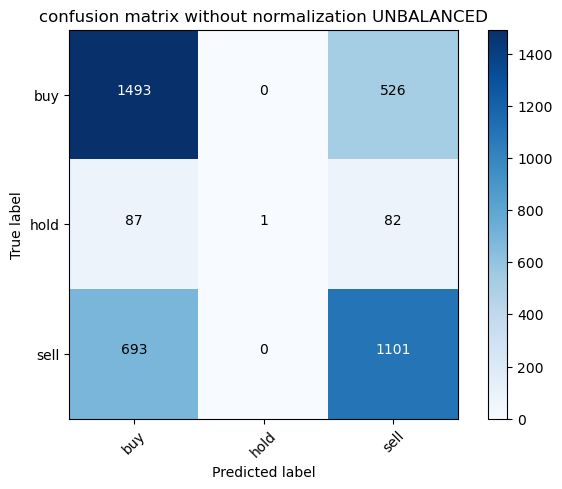

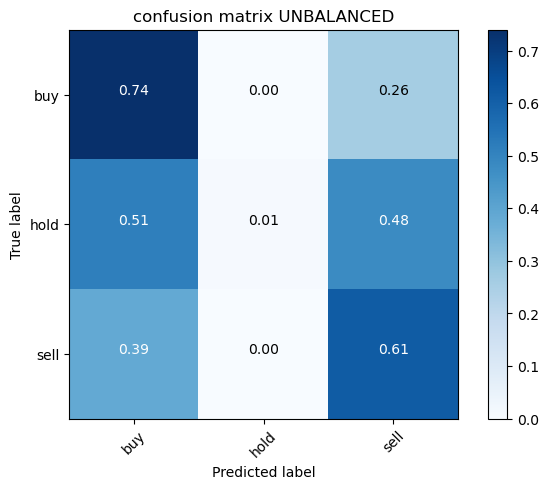

In [57]:
#### Results and Confusion matrices of the models
### UNBALANCED
print('UNBALANCED DATA SET\n')
print('Best score: {0: .4f}'.format(gbc_grid_ns.best_score_))
print('train accuracy unbalanced: {0: .4f}'.format(gbc_grid_ns.score(X_train_ns, y_train_ns)))
print('test accuracy undbalanced: {0: .4f}\n'.format(gbc_grid_ns.score(X_test_ns, y_test_ns)))

# extract best params
extr_bp_gbc_ns = gbc_grid_ns.best_estimator_ 

# fit with best params
extr_bp_gbc_ns.fit(X_train_ns, y_train_ns)

# Predict Classes
y_pred_gbc_ns = extr_bp_gbc_ns.predict(X_test_ns)

# Confusion Matrix
#print(metrics.confusion_matrix(y_test_ns, y_pred_gbc_ns))

# Classification report
print(metrics.classification_report(y_test_ns, y_pred_gbc_ns))


#construct a basic confusion matrix for our prediction
#confusion_matrix(y_test_ns, y_pred_gbc_ns)
#calculate accuracy by hand


#defining a plot function for a fancy confusion matrix
plt.style.use('default')

    
# confusion matrix fct from above
cfm_matrix_gbc_ns = confusion_matrix(y_test_ns, y_pred_gbc_ns)
np.set_printoptions(precision = 2)
    
#plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_gbc_ns, classes=['buy', 'hold', 'sell'], title = 'confusion matrix without normalization UNBALANCED')

#plot normaliized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_gbc_ns, classes=['buy', 'hold', 'sell'], normalize = True, title = 'confusion matrix UNBALANCED')


UNBALANCED DATA SET

Best score:  0.7706
train accuracy unbalanced:  1.0000
test accuracy undbalanced:  0.7659



Pipeline(steps=[('Feature Selection',
                 SelectFromModel(estimator=RandomForestClassifier(),
                                 threshold='median')),
                ('scaler', StandardScaler()),
                ('GBC',
                 GradientBoostingClassifier(criterion='mse', max_depth=10,
                                            n_estimators=300))])

[[1456    0  563]
 [   0 1770    0]
 [ 747    1 1046]]
              precision    recall  f1-score   support

        -1.0       0.66      0.72      0.69      2019
         0.0       1.00      1.00      1.00      1770
         1.0       0.65      0.58      0.61      1794

    accuracy                           0.77      5583
   macro avg       0.77      0.77      0.77      5583
weighted avg       0.76      0.77      0.76      5583



array([[1456,    0,  563],
       [   0, 1770,    0],
       [ 747,    1, 1046]])

<Figure size 640x480 with 0 Axes>

Confusion matrix , without normalization 
[[1456    0  563]
 [   0 1770    0]
 [ 747    1 1046]]


<Figure size 640x480 with 0 Axes>

normalized confusion matrix
[[7.21e-01 0.00e+00 2.79e-01]
 [0.00e+00 1.00e+00 0.00e+00]
 [4.16e-01 5.57e-04 5.83e-01]]


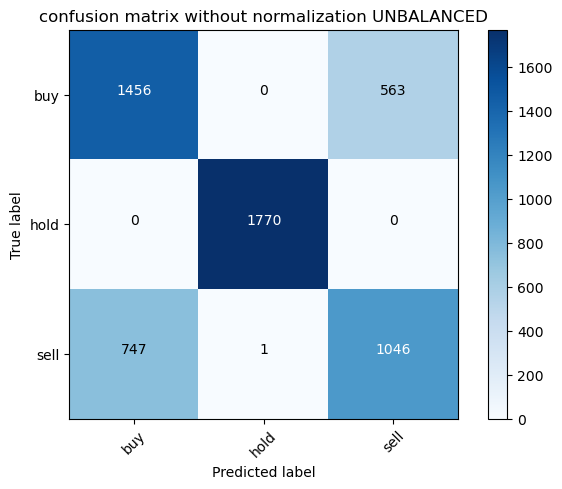

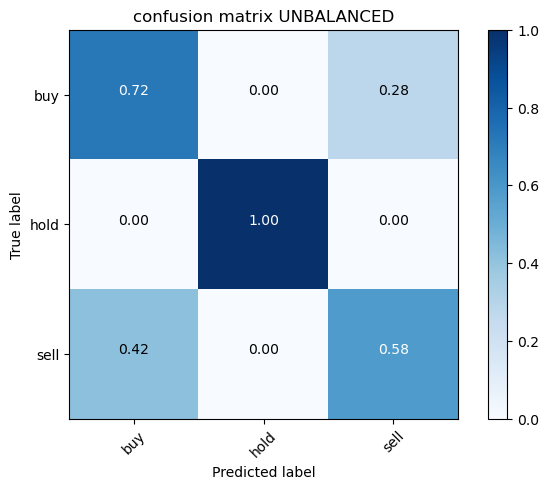

In [58]:
### BALANCED
print('BALANCED DATA SET\n')
print('Best score: {0: .4f}'.format(gbc_grid.best_score_))
print('train accuracy unbalanced: {0: .4f}'.format(gbc_grid.score(X_train, y_train)))
print('test accuracy undbalanced: {0: .4f}\n'.format(gbc_grid.score(X_test, y_test)))

# extract best params
extr_bp_gbc = gbc_grid.best_estimator_ 

# fit with best params
extr_bp_gbc.fit(X_train, y_train)

# Predict Classes
y_pred_gbc = extr_bp_gbc.predict(X_test)

# Confusion Matrix
print(metrics.confusion_matrix(y_test, y_pred_gbc))

# Classification report
print(metrics.classification_report(y_test, y_pred_gbc))


#construct a basic confusion matrix for our prediction
confusion_matrix(y_test, y_pred_gbc)
#calculate accuracy by hand


#defining a plot function for a fancy confusion matrix
plt.style.use('default')

    
# confusion matrix fct from above
cfm_matrix_gbc = confusion_matrix(y_test, y_pred_gbc)
np.set_printoptions(precision = 2)
    
#plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_gbc, classes=['buy', 'hold', 'sell'], title = 'confusion matrix without normalization UNBALANCED')

#plot normaliized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_gbc, classes=['buy', 'hold', 'sell'], normalize = True, title = 'confusion matrix UNBALANCED')

In [59]:
test_scores.append(('GBC', extr_bp_gbc.score(X_test, y_test)))

#### Interpretation Gradient Boosting Classifier
##### Unbalanced
if we look at a buy, hold, sell worthy stock our model will recognize:

* a buy worthy stock 67 times out of 100
* a hold worthy stock 0 times out of 100
* a sell worthy stock 58 times out of 100


##### Balanced
if we look at a buy, hold, sell worthy stock our model will recognize:

* a buy worthy stock 73 times out of 100
* a hold worthy stock 100 times out of 100
* a sell worthy stock 58 times out of 100



### 8.4 Logistic Regression

In [60]:
##### Logistic Regression Classifier
pipe_logreg_ns = Pipeline([('feature_selection', SelectFromModel(RandomForestClassifier(), threshold='median')),
                     ('scaler', StandardScaler()),
                     ('LogReg', LogisticRegression(multi_class = 'multinomial', class_weight = 'balanced'))])

#param_grid_logreg_ns = {'LogReg__penalty': ['l2', None],
             #'LogReg__C': [0.5, 1.0],
             #'LogReg__solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}

#We got penalty = 'l2', C = 1.0 and solver = 'saga'. We optimize again for C.

#param_grid_logreg_ns = {'LogReg__penalty': ['l2'],
             #'LogReg__C': [1.0, 2.0],
             #'LogReg__solver': ['saga']}

#We got again C = 1.0.

param_grid_logreg_ns = {'LogReg__penalty': ['l2'],
             'LogReg__C': [1.0],
             'LogReg__solver': ['saga']}

grid_logreg_ns = GridSearchCV(pipe_logreg_ns, param_grid = param_grid_logreg_ns, scoring = 'accuracy', cv = kFold, n_jobs = -1)

grid_logreg_ns.fit(X_train_ns, y_train_ns)

/Users/lukasdekker/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('feature_selection',
                                        SelectFromModel(estimator=RandomForestClassifier(),
                                                        threshold='median')),
                                       ('scaler', StandardScaler()),
                                       ('LogReg',
                                        LogisticRegression(class_weight='balanced',
                                                           multi_class='multinomial'))]),
             n_jobs=-1,
             param_grid={'LogReg__C': [1.0], 'LogReg__penalty': ['l2'],
                         'LogReg__solver': ['saga']},
             scoring='accuracy')

In [61]:
pipe_logreg = Pipeline([('feature_selection', SelectFromModel(RandomForestClassifier(), threshold='median')),
                     ('scaler', StandardScaler()),
                     ('LogReg', LogisticRegression(multi_class = 'multinomial', class_weight = 'balanced'))])

#param_grid_logreg = {'LogReg__penalty': ['l2', None],
             #'LogReg__C': [0.5, 1.0],
             #'LogReg__solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}

#We got penalty = 'l2', C = 1.0 and solver = 'saga'. We optimize again for C.

#param_grid_logreg = {'LogReg__penalty': ['l2'],
             #'LogReg__C': [1.0, 2.0],
             #'LogReg__solver': ['saga']}

#We got again C = 1.0. 

param_grid_logreg = {'LogReg__penalty': ['l2'],
             'LogReg__C': [1.0],
             'LogReg__solver': ['saga']}

grid_logreg = GridSearchCV(pipe_logreg, param_grid = param_grid_logreg, scoring = 'accuracy',cv = kFold, n_jobs = -1)

grid_logreg.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('feature_selection',
                                        SelectFromModel(estimator=RandomForestClassifier(),
                                                        threshold='median')),
                                       ('scaler', StandardScaler()),
                                       ('LogReg',
                                        LogisticRegression(class_weight='balanced',
                                                           multi_class='multinomial'))]),
             n_jobs=-1,
             param_grid={'LogReg__C': [1.0], 'LogReg__penalty': ['l2'],
                         'LogReg__solver': ['saga']},
             scoring='accuracy')

UNBALANCED DATA SET

Best score:  0.4366
train accuracy unbalanced:  0.4492
test accuracy undbalanced:  0.4419



/Users/lukasdekker/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier(),
                                 threshold='median')),
                ('scaler', StandardScaler()),
                ('LogReg',
                 LogisticRegression(class_weight='balanced',
                                    multi_class='multinomial',
                                    solver='saga'))])

[[950 573 496]
 [ 50  56  64]
 [493 508 793]]
              precision    recall  f1-score   support

        -1.0       0.64      0.47      0.54      2019
         0.0       0.05      0.33      0.09       170
         1.0       0.59      0.44      0.50      1794

    accuracy                           0.45      3983
   macro avg       0.42      0.41      0.38      3983
weighted avg       0.59      0.45      0.50      3983



array([[950, 573, 496],
       [ 50,  56,  64],
       [493, 508, 793]])

<Figure size 640x480 with 0 Axes>

Confusion matrix , without normalization 
[[950 573 496]
 [ 50  56  64]
 [493 508 793]]


<Figure size 640x480 with 0 Axes>

normalized confusion matrix
[[0.47 0.28 0.25]
 [0.29 0.33 0.38]
 [0.27 0.28 0.44]]


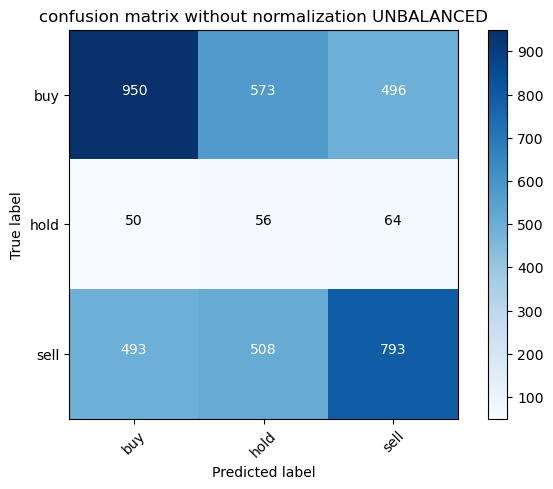

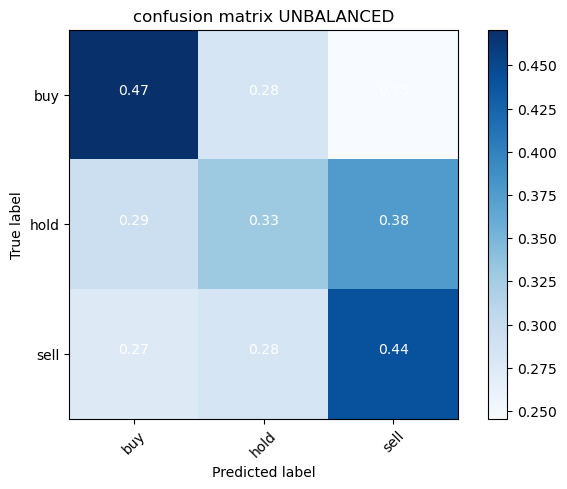

In [62]:
#### Results and Confusion Matrices of the models

##UNBALANCED
print('UNBALANCED DATA SET\n')
print('Best score: {0: .4f}'.format(grid_logreg_ns.best_score_))
print('train accuracy unbalanced: {0: .4f}'.format(grid_logreg_ns.score(X_train_ns, y_train_ns)))
print('test accuracy undbalanced: {0: .4f}\n'.format(grid_logreg_ns.score(X_test_ns, y_test_ns)))

# extract best params
extr_bp_logreg_ns = grid_logreg_ns.best_estimator_ 

# fit with best params
extr_bp_logreg_ns.fit(X_train_ns, y_train_ns)

# Predict Classes
y_pred_logreg_ns = extr_bp_logreg_ns.predict(X_test_ns)

# Confusion Matrix
print(metrics.confusion_matrix(y_test_ns, y_pred_logreg_ns))

# Classification report
print(metrics.classification_report(y_test_ns, y_pred_logreg_ns))


#construct a basic confusion matrix for our prediction
confusion_matrix(y_test_ns, y_pred_logreg_ns)
#calculate accuracy by hand


#defining a plot function for a fancy confusion matrix
plt.style.use('default')

    
# confusion matrix fct from above
cfm_matrix_logreg_ns = confusion_matrix(y_test_ns, y_pred_logreg_ns)
np.set_printoptions(precision = 2)
    
#plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_logreg_ns, classes=['buy', 'hold', 'sell'], title = 'confusion matrix without normalization UNBALANCED')

#plot normaliized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_logreg_ns, classes=['buy', 'hold', 'sell'], normalize = True, title = 'confusion matrix UNBALANCED')



BALANCED DATA SET

Best score:  0.4357
train accuracy balanced:  0.4425
test accuracy balanced:  0.4295



Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier(),
                                 threshold='median')),
                ('scaler', StandardScaler()),
                ('LogReg',
                 LogisticRegression(class_weight='balanced',
                                    multi_class='multinomial',
                                    solver='saga'))])

[[896 584 539]
 [449 726 595]
 [483 562 749]]
              precision    recall  f1-score   support

        -1.0       0.49      0.44      0.47      2019
         0.0       0.39      0.41      0.40      1770
         1.0       0.40      0.42      0.41      1794

    accuracy                           0.42      5583
   macro avg       0.43      0.42      0.42      5583
weighted avg       0.43      0.42      0.43      5583



array([[896, 584, 539],
       [449, 726, 595],
       [483, 562, 749]])

<Figure size 640x480 with 0 Axes>

Confusion matrix , without normalization 
[[896 584 539]
 [449 726 595]
 [483 562 749]]


<Figure size 640x480 with 0 Axes>

normalized confusion matrix
[[0.44 0.29 0.27]
 [0.25 0.41 0.34]
 [0.27 0.31 0.42]]


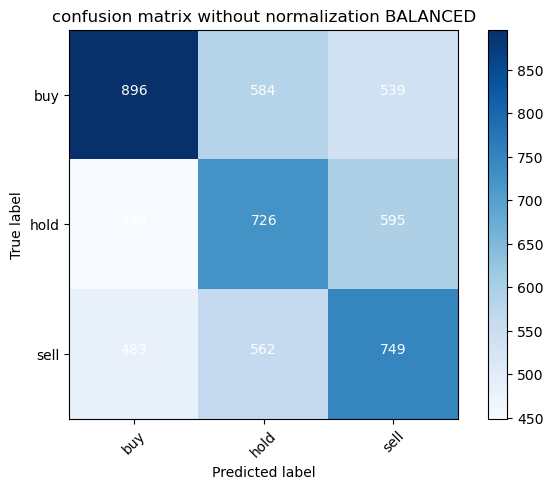

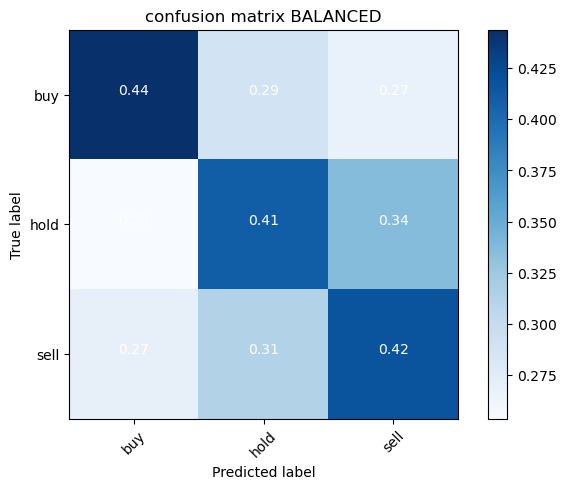

In [63]:
##BALANCED
print('BALANCED DATA SET\n')
print('Best score: {0: .4f}'.format(grid_logreg.best_score_))
print('train accuracy balanced: {0: .4f}'.format(grid_logreg.score(X_train, y_train)))
print('test accuracy balanced: {0: .4f}\n'.format(grid_logreg.score(X_test, y_test)))

# extract best params
extr_bp_logreg = grid_logreg.best_estimator_ 

# fit with best params
extr_bp_logreg.fit(X_train, y_train)

# Predict Classes
y_pred_logreg = extr_bp_logreg.predict(X_test)

# Confusion Matrix
print(metrics.confusion_matrix(y_test, y_pred_logreg))

# Classification report
print(metrics.classification_report(y_test, y_pred_logreg))


#construct a basic confusion matrix for our prediction
confusion_matrix(y_test, y_pred_logreg)
#calculate accuracy by hand


#defining a plot function for a fancy confusion matrix
plt.style.use('default')

    
# confusion matrix fct from above
cfm_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
np.set_printoptions(precision = 2)
    
#plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_logreg, classes=['buy', 'hold', 'sell'], title = 'confusion matrix without normalization BALANCED')

#plot normaliized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_logreg, classes=['buy', 'hold', 'sell'], normalize = True, title = 'confusion matrix BALANCED')

In [64]:
test_scores.append(('LogReg', extr_bp_logreg.score(X_test, y_test)))

#### Interpretation Gradien Boosting Classifier
##### Unbalanced
if we look at a buy, hold, sell worthy stock our model will recognize:

* a buy worthy stock 47 times out of 100
* a hold worthy stock 33 times out of 100
* a sell worthy stock 45 times out of 100


##### Balanced
if we look at a buy, hold, sell worthy stock our model will recognize:

* a buy worthy stock 44 times out of 100
* a hold worthy stock 41 times out of 100
* a sell worthy stock 42 times out of 100

this tells us that:
* our model does not perform very well since we have many missclassifications
* the model perfroms almost the same for every type of stock

some other interesting findings include:
* Logistic Regression performed almost the same on the balanced and the unbalanced data set
* With the balanced data set every of the nine groups has almost the same amount of classified stocks

### 8.5 Linear Discriminant Analysis
After hyperparameter tuning we found for the balanced dataset the optimal parameters: solver = eigen and shrinkage = auto. 

In [65]:
#### LDA with UNBALANCED data set

pipe_lda_ns = Pipeline([('Feature Selection', SelectFromModel(RandomForestClassifier(), threshold = 'median')),
                    ('scaler', StandardScaler()),
                    ('lda', LDA())])

#param_grid_lda_ns = {
    #'lda__solver': ['svd', 'lsqr','eigen'],
    #'lda__shrinkage': ['auto', None]}
    
#We got the optimal values: solver = 'eigen' and shrinkage = 'auto'

param_grid_lda_ns = {
    'lda__solver': ['eigen'],
    'lda__shrinkage': ['auto']
}

lda_ns_grid = GridSearchCV(pipe_lda_ns, param_grid_lda_ns, scoring = 'accuracy', cv = kFold, n_jobs=-1)
lda_ns_grid.fit(X_train_ns, y_train_ns)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('Feature Selection',
                                        SelectFromModel(estimator=RandomForestClassifier(),
                                                        threshold='median')),
                                       ('scaler', StandardScaler()),
                                       ('lda', LinearDiscriminantAnalysis())]),
             n_jobs=-1,
             param_grid={'lda__shrinkage': ['auto'], 'lda__solver': ['eigen']},
             scoring='accuracy')

In [66]:
#### LDA with BALANCED Data set

pipe_lda = Pipeline([('Feature Selection', SelectFromModel(RandomForestClassifier(), threshold = 'median')),
                    ('scaler', StandardScaler()),
                    ('lda', LDA())])

#param_grid_lda = {
    #'lda__solver': ['svd', 'lsqr','eigen'],
    #'lda__shrinkage': ['auto', None]}
    
#We got the optimal values: solver = 'eigen' and shrinkage = 'auto'

param_grid_lda = {
    'lda__solver': ['eigen'],
    'lda__shrinkage': ['auto']
}

lda_grid = GridSearchCV(pipe_lda, param_grid = param_grid_lda, scoring = 'accuracy',cv = kFold, n_jobs = -1)
lda_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('Feature Selection',
                                        SelectFromModel(estimator=RandomForestClassifier(),
                                                        threshold='median')),
                                       ('scaler', StandardScaler()),
                                       ('lda', LinearDiscriminantAnalysis())]),
             n_jobs=-1,
             param_grid={'lda__shrinkage': ['auto'], 'lda__solver': ['eigen']},
             scoring='accuracy')

UNBALANCED DATA SET

Best score:  0.5860
train accuracy unbalanced:  0.5920
test accuracy undbalanced:  0.5905



Pipeline(steps=[('Feature Selection',
                 SelectFromModel(estimator=RandomForestClassifier(),
                                 threshold='median')),
                ('scaler', StandardScaler()),
                ('lda',
                 LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen'))])

[[1342    0  677]
 [  81    0   89]
 [ 780    0 1014]]
              precision    recall  f1-score   support

        -1.0       0.61      0.66      0.64      2019
         0.0       0.00      0.00      0.00       170
         1.0       0.57      0.57      0.57      1794

    accuracy                           0.59      3983
   macro avg       0.39      0.41      0.40      3983
weighted avg       0.57      0.59      0.58      3983



/Users/lukasdekker/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lukasdekker/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lukasdekker/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1342,    0,  677],
       [  81,    0,   89],
       [ 780,    0, 1014]])

<Figure size 640x480 with 0 Axes>

Confusion matrix , without normalization 
[[1342    0  677]
 [  81    0   89]
 [ 780    0 1014]]


<Figure size 640x480 with 0 Axes>

normalized confusion matrix
[[0.66 0.   0.34]
 [0.48 0.   0.52]
 [0.43 0.   0.57]]


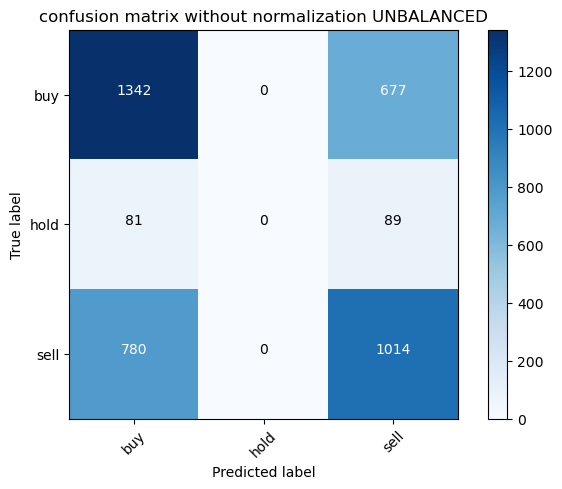

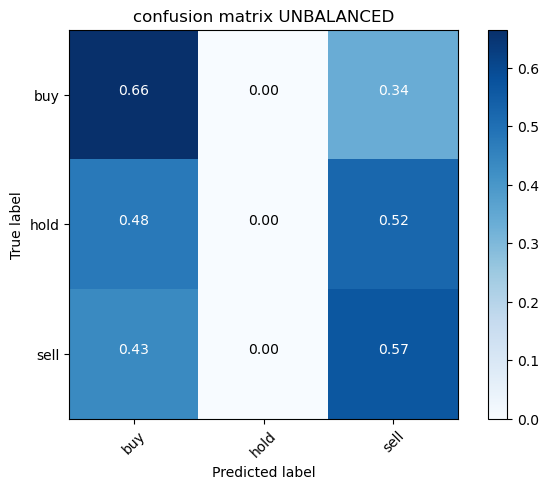

In [67]:
#### Confusion Matrices of the models

##UNBALANCED
print('UNBALANCED DATA SET\n')
print('Best score: {0: .4f}'.format(lda_ns_grid.best_score_))
print('train accuracy unbalanced: {0: .4f}'.format(lda_ns_grid.score(X_train_ns, y_train_ns)))
print('test accuracy undbalanced: {0: .4f}\n'.format(lda_ns_grid.score(X_test_ns, y_test_ns)))

# extract best params
extr_bp_lda_ns = lda_ns_grid.best_estimator_ 

# fit with best params
extr_bp_lda_ns.fit(X_train_ns, y_train_ns)

# Predict Classes
y_pred_lda_ns = extr_bp_lda_ns.predict(X_test_ns)

# Confusion Matrix
print(metrics.confusion_matrix(y_test_ns, y_pred_lda_ns))

# Classification report
print(metrics.classification_report(y_test_ns, y_pred_lda_ns))


#construct a basic confusion matrix for our prediction
confusion_matrix(y_test_ns, y_pred_lda_ns)
#calculate accuracy by hand


#defining a plot function for a fancy confusion matrix
plt.style.use('default')

    
# confusion matrix fct from above
cfm_matrix_lda_ns = confusion_matrix(y_test_ns, y_pred_lda_ns)
np.set_printoptions(precision = 2)
    
#plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_lda_ns, classes=['buy', 'hold', 'sell'], title = 'confusion matrix without normalization UNBALANCED')

#plot normaliized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_lda_ns, classes=['buy', 'hold', 'sell'], normalize = True, title = 'confusion matrix UNBALANCED')



BALANCED DATA SET

Best score:  0.4402
train accuracy balanced:  0.4459
test accuracy balanced:  0.4369



Pipeline(steps=[('Feature Selection',
                 SelectFromModel(estimator=RandomForestClassifier(),
                                 threshold='median')),
                ('scaler', StandardScaler()),
                ('lda',
                 LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen'))])

[[1084  455  480]
 [ 593  653  524]
 [ 590  495  709]]
              precision    recall  f1-score   support

        -1.0       0.48      0.54      0.51      2019
         0.0       0.41      0.37      0.39      1770
         1.0       0.41      0.40      0.40      1794

    accuracy                           0.44      5583
   macro avg       0.43      0.43      0.43      5583
weighted avg       0.44      0.44      0.44      5583



array([[1084,  455,  480],
       [ 593,  653,  524],
       [ 590,  495,  709]])

<Figure size 640x480 with 0 Axes>

Confusion matrix , without normalization 
[[1084  455  480]
 [ 593  653  524]
 [ 590  495  709]]


<Figure size 640x480 with 0 Axes>

normalized confusion matrix
[[0.54 0.23 0.24]
 [0.34 0.37 0.3 ]
 [0.33 0.28 0.4 ]]


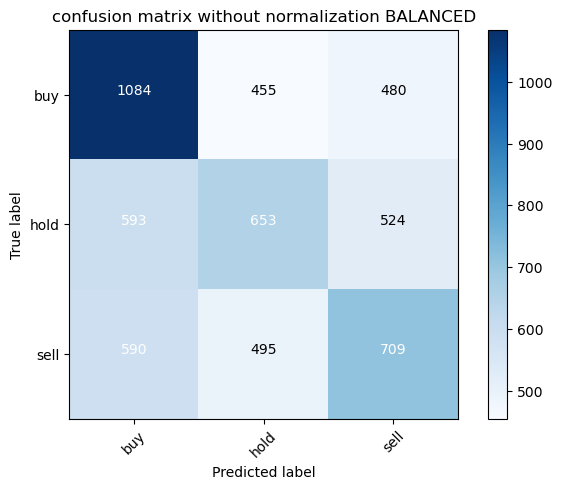

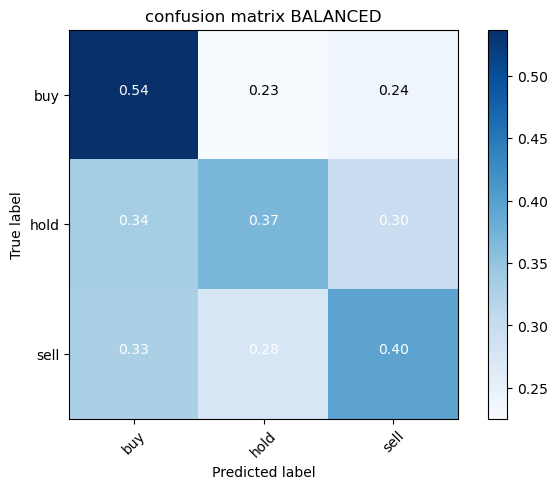

In [68]:
##BALANCED
print('BALANCED DATA SET\n')
print('Best score: {0: .4f}'.format(lda_grid.best_score_))
print('train accuracy balanced: {0: .4f}'.format(lda_grid.score(X_train, y_train)))
print('test accuracy balanced: {0: .4f}\n'.format(lda_grid.score(X_test, y_test)))

# extract best params
extr_bp_lda = lda_grid.best_estimator_ 

# fit with best params
extr_bp_lda.fit(X_train, y_train)

# Predict Classes
y_pred_lda = extr_bp_lda.predict(X_test)

# Confusion Matrix
print(metrics.confusion_matrix(y_test, y_pred_lda))

# Classification report
print(metrics.classification_report(y_test, y_pred_lda))


#construct a basic confusion matrix for our prediction
confusion_matrix(y_test, y_pred_lda)
#calculate accuracy by hand


#defining a plot function for a fancy confusion matrix
plt.style.use('default')

    
# confusion matrix fct from above
cfm_matrix_lda = confusion_matrix(y_test, y_pred_lda)
np.set_printoptions(precision = 2)
    
#plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_lda, classes=['buy', 'hold', 'sell'], title = 'confusion matrix without normalization BALANCED')

#plot normaliized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_lda, classes=['buy', 'hold', 'sell'], normalize = True, title = 'confusion matrix BALANCED')



In [69]:
test_scores.append(('LDA', extr_bp_lda.score(X_test, y_test)))

Since the performance of our Model is very poor we try to optimize it via bagging.

In [70]:
#### BAGGING the LDA model with UNBALANCED data set

pipe_bagged_lda_ns = Pipeline([('Feature Selection', SelectFromModel(RandomForestClassifier(), threshold = 'median')),
                    ('scaler', StandardScaler()),
                    ('bagged_lda', BaggingClassifier(LDA(solver = 'eigen', shrinkage = 'auto'), random_state = 0))])

#param_grid_bagged_lda_ns = {
    #'bagged_lda__bootstrap': [True, False],
    #'bagged_lda__bootstrap_features': [True, False]}

#We got False for both parameters. 
param_grid_bagged_lda_ns = {
    'bagged_lda__bootstrap': [False],
    'bagged_lda__bootstrap_features': [False]}



bagged_lda_grid_ns = GridSearchCV(pipe_bagged_lda_ns, param_grid = param_grid_bagged_lda_ns, scoring = 'accuracy', cv = kFold, n_jobs = -1)
bagged_lda_grid_ns.fit(X_train_ns, y_train_ns)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('Feature Selection',
                                        SelectFromModel(estimator=RandomForestClassifier(),
                                                        threshold='median')),
                                       ('scaler', StandardScaler()),
                                       ('bagged_lda',
                                        BaggingClassifier(base_estimator=LinearDiscriminantAnalysis(shrinkage='auto',
                                                                                                    solver='eigen'),
                                                          random_state=0))]),
             n_jobs=-1,
             param_grid={'bagged_lda__bootstrap': [False],
                         'bagged_lda__bootstrap_features': [False]},
             scoring='accuracy')

In [71]:
#### BAGGING the LDA model with BALANCED data set

pipe_bagged_lda = Pipeline([('Feature Selection', SelectFromModel(RandomForestClassifier(), threshold = 'median')),
                    ('scaler', StandardScaler()),
                    ('bagged_lda', BaggingClassifier(LDA(solver = 'eigen', shrinkage = 'auto'), random_state = 0))])

#param_grid_bagged_lda = {
    #'bagged_lda__bootstrap': [True, False],
    #'bagged_lda__bootstrap_features': [True, False]}
    
#We got False for both parameters. 
param_grid_bagged_lda = {
    'bagged_lda__bootstrap': [False],
    'bagged_lda__bootstrap_features': [False]}


bagged_lda_grid = GridSearchCV(pipe_bagged_lda, param_grid = param_grid_bagged_lda, scoring = 'accuracy', cv = kFold, n_jobs = 1)
bagged_lda_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('Feature Selection',
                                        SelectFromModel(estimator=RandomForestClassifier(),
                                                        threshold='median')),
                                       ('scaler', StandardScaler()),
                                       ('bagged_lda',
                                        BaggingClassifier(base_estimator=LinearDiscriminantAnalysis(shrinkage='auto',
                                                                                                    solver='eigen'),
                                                          random_state=0))]),
             n_jobs=1,
             param_grid={'bagged_lda__bootstrap': [False],
                         'bagged_lda__bootstrap_features': [False]},
             scoring='accuracy')

UNBALANCED DATA SET

Best score:  0.5869
train accuracy unbalanced:  0.5942
test accuracy undbalanced:  0.5905



Pipeline(steps=[('Feature Selection',
                 SelectFromModel(estimator=RandomForestClassifier(),
                                 threshold='median')),
                ('scaler', StandardScaler()),
                ('bagged_lda',
                 BaggingClassifier(base_estimator=LinearDiscriminantAnalysis(shrinkage='auto',
                                                                             solver='eigen'),
                                   bootstrap=False, random_state=0))])

              precision    recall  f1-score   support

        -1.0       0.61      0.66      0.64      2019
         0.0       0.00      0.00      0.00       170
         1.0       0.57      0.57      0.57      1794

    accuracy                           0.59      3983
   macro avg       0.39      0.41      0.40      3983
weighted avg       0.57      0.59      0.58      3983





/Users/lukasdekker/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lukasdekker/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lukasdekker/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

Confusion matrix , without normalization 
[[1341    0  678]
 [  81    0   89]
 [ 767    0 1027]]


<Figure size 640x480 with 0 Axes>

normalized confusion matrix
[[0.66 0.   0.34]
 [0.48 0.   0.52]
 [0.43 0.   0.57]]


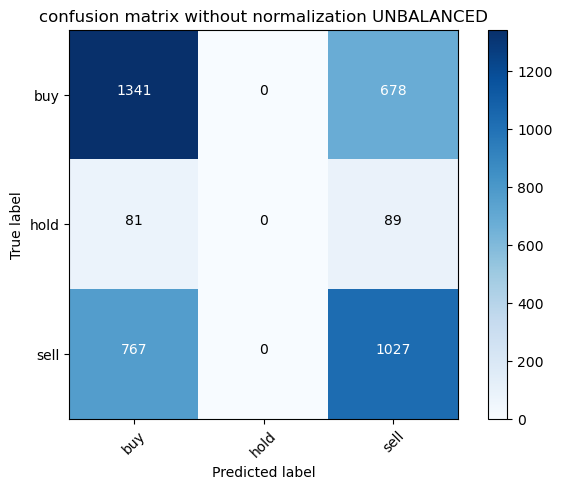

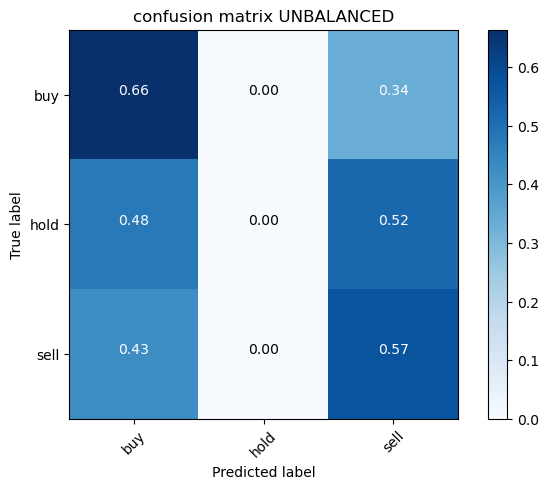

In [72]:
#### Results and Confusion Matrices of the bagged models
##UNBALANCED
print('UNBALANCED DATA SET\n')
print('Best score: {0: .4f}'.format(bagged_lda_grid_ns.best_score_))
print('train accuracy unbalanced: {0: .4f}'.format(bagged_lda_grid_ns.score(X_train_ns, y_train_ns)))
print('test accuracy undbalanced: {0: .4f}\n'.format(bagged_lda_grid_ns.score(X_test_ns, y_test_ns)))

# extract best params
extr_bp_bagged_lda_ns = bagged_lda_grid_ns.best_estimator_ 

# fit with best params
extr_bp_bagged_lda_ns.fit(X_train_ns, y_train_ns)

# Predict Classes
y_pred_bagged_lda_ns = extr_bp_bagged_lda_ns.predict(X_test_ns)

# Confusion Matrix
#print(metrics.confusion_matrix(y_test_ns, y_pred_lda_ns))

# Classification report
print(metrics.classification_report(y_test_ns, y_pred_lda_ns))


#construct a basic confusion matrix for our prediction
#confusion_matrix(y_test_ns, y_pred_bagged_lda_ns)
#calculate accuracy by hand


#defining a plot function for a fancy confusion matrix
plt.style.use('default')

    
# confusion matrix fct from above
cfm_matrix_bagged_lda_ns = confusion_matrix(y_test_ns, y_pred_bagged_lda_ns)
np.set_printoptions(precision = 2)
print('\n')
    
#plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_bagged_lda_ns, classes=['buy', 'hold', 'sell'], title = 'confusion matrix without normalization UNBALANCED')

#plot normaliized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_bagged_lda_ns, classes=['buy', 'hold', 'sell'], normalize = True, title = 'confusion matrix UNBALANCED')


BALANCED DATA SET

Best score:  0.4402
train accuracy balanced:  0.4434
test accuracy balanced:  0.4381



Pipeline(steps=[('Feature Selection',
                 SelectFromModel(estimator=RandomForestClassifier(),
                                 threshold='median')),
                ('scaler', StandardScaler()),
                ('bagged_lda',
                 BaggingClassifier(base_estimator=LinearDiscriminantAnalysis(shrinkage='auto',
                                                                             solver='eigen'),
                                   bootstrap=False, random_state=0))])

              precision    recall  f1-score   support

        -1.0       0.48      0.53      0.50      2019
         0.0       0.40      0.36      0.38      1770
         1.0       0.41      0.40      0.40      1794

    accuracy                           0.43      5583
   macro avg       0.43      0.43      0.43      5583
weighted avg       0.43      0.43      0.43      5583



<Figure size 640x480 with 0 Axes>

Confusion matrix , without normalization 
[[1067  482  470]
 [ 575  639  556]
 [ 595  489  710]]


<Figure size 640x480 with 0 Axes>

normalized confusion matrix
[[0.53 0.24 0.23]
 [0.32 0.36 0.31]
 [0.33 0.27 0.4 ]]


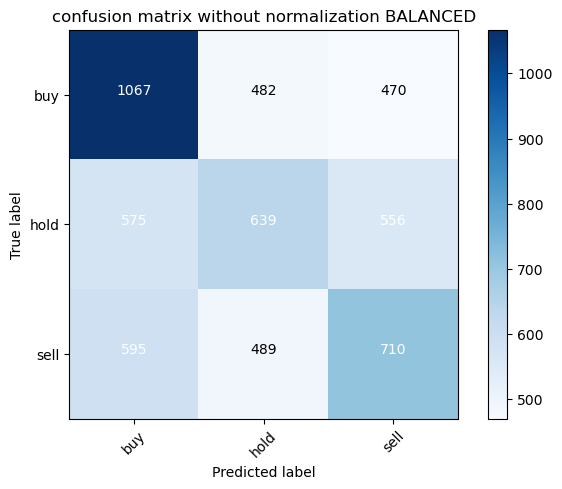

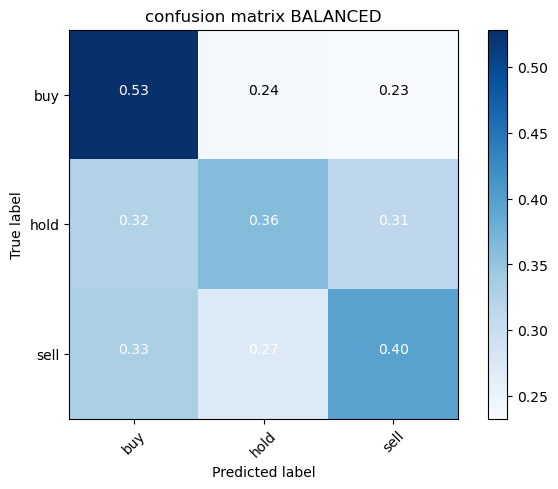

In [73]:
##BALANCED
print('BALANCED DATA SET\n')
print('Best score: {0: .4f}'.format(lda_grid.best_score_))
print('train accuracy balanced: {0: .4f}'.format(lda_grid.score(X_train, y_train)))
print('test accuracy balanced: {0: .4f}\n'.format(lda_grid.score(X_test, y_test)))

# extract best params
extr_bp_bagged_lda = bagged_lda_grid.best_estimator_ 

# fit with best params
extr_bp_bagged_lda.fit(X_train, y_train)

# Predict Classes
y_pred_bagged_lda = extr_bp_bagged_lda.predict(X_test)

# Confusion Matrix
#print(metrics.confusion_matrix(y_test, y_pred_bagged_lda))

# Classification report
print(metrics.classification_report(y_test, y_pred_bagged_lda))


#construct a basic confusion matrix for our prediction
#confusion_matrix(y_test, y_pred_bagged_lda)
#calculate accuracy by hand


#defining a plot function for a fancy confusion matrix
plt.style.use('default')

    
# confusion matrix fct from above
cfm_matrix_bagged_lda = confusion_matrix(y_test, y_pred_bagged_lda)
np.set_printoptions(precision = 2)
    
#plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_bagged_lda, classes=['buy', 'hold', 'sell'], title = 'confusion matrix without normalization BALANCED')

#plot normaliized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_bagged_lda, classes=['buy', 'hold', 'sell'], normalize = True, title = 'confusion matrix BALANCED')

In [74]:
test_scores.append(('LDA bagged', extr_bp_bagged_lda.score(X_test, y_test)))

#### Interpretation Linear Discriminant Analysis (unbalanced data set)

according to our model we have the following precisions:

##### whithout bagging
if we look at a buy, hold, sell worthy stock our model will recognize:

* a buy worthy stock 67 times out of 100
* a hold worthy stock 0 times out of 100
* a sell worthy stock 58 times out of 100

##### with bagging
if we look at a buy, hold, sell worthy stock our model will recognize:

* a buy worthy stock 67 times out of 100
* a hold worthy stock 0 times out of 100
* a sell worthy stock 57 times out of 100

this tells us that:
* our model recognizes buy worthy stocks well, i.e., if we really do have a buy worthy stock chances of the model classifying it as such is higher as a naive(*) classification
* our model performs badly for hold worhty stocks which could be due to the fact that we've got a rather high class imbalance
* for sell worthy stocks our model performs on a good level but not as good as for buy worthy stocks

some other interesting findings include:
* not a single buy or sell worty stock has been wrongly calssified as hold worthy stock
* although the model performs better for buy and sell worthy stocks than a naive(*) classification we still have quite a lot of misclassifications
* the model did not improve though bagging

One can see that these findings are pretty similar to the ones of the ranfom forest model.

#### Interpretation Linear Discriminant Analysis (balanced data set)
##### without bagging
if we look at a buy, hold, sell worthy stock our model will recognize:

* a buy worthy stock 53 times out of 100
* a hold worthy stock 36 times out of 100
* a sell worthy stock 39 times out of 100

##### with bagging
if we look at a buy, hold, sell worthy stock our model will recognize:

* a buy worthy stock 53 times out of 100
* a hold worthy stock 37 times out of 100
* a sell worthy stock 40 times out of 100

this tells us that:
* our model does not perform very well since we have many missclassifications
* especially for hild and sell worthy stocks our model nearly gives us any additional information if one compares it with the naive classification

some other interesting findings include:
* LDA did perform better with the unbalanced data set
* the model did improve improve very little through bagging

### 8.6 Quadratic Discriminant Analysis

In [75]:
#### QDA with UNBALANCED data set

pipe_qda_ns = Pipeline([('Feature Selection', SelectFromModel(RandomForestClassifier(), threshold = 'median')),
                    ('scaler', StandardScaler()),
                    ('qda', QDA())])

#param_grid_qda_ns = {
    #'qda__tol': [1.0e-4, 1.0e-3]}
# we got tol = 0.0001 and optimize again:

#param_grid_qda_ns = {
    #'qda__tol': [1.0e-4, 1.0e-5]}
#we got again tol = 0.0001 and use this value:

param_grid_qda_ns = {
    'qda__tol': [1.0e-4]}

qda_grid_ns = GridSearchCV(pipe_qda_ns, param_grid = param_grid_qda_ns, scoring = 'accuracy', cv = kFold, n_jobs=-1)

#run brute force grid search
qda_grid_ns.fit(X_train_ns, y_train_ns)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('Feature Selection',
                                        SelectFromModel(estimator=RandomForestClassifier(),
                                                        threshold='median')),
                                       ('scaler', StandardScaler()),
                                       ('qda',
                                        QuadraticDiscriminantAnalysis())]),
             n_jobs=-1, param_grid={'qda__tol': [0.0001]}, scoring='accuracy')

In [76]:
#### QDA with BALANCED data set
pipe_qda = Pipeline([('Feature Selection', SelectFromModel(RandomForestClassifier(), threshold = 'median')),
                    ('scaler', StandardScaler()),
                    ('qda', QDA())])

#param_grid_qda = {
    #'qda__tol': [1.0e-4, 1.0e-3]}
#We get tol = 0.001 as the optimal model and optimize again.

#param_grid_qda = {
    #'qda__tol': [1.0e-2, 1.0e-3]}
#We get again tol = 0.01 and use this value:

param_grid_qda = {
    'qda__tol': [1.0e-3]}

qda_grid = GridSearchCV(pipe_qda, param_grid = param_grid_qda, cv = kFold, n_jobs=-1)

#run brute force grid search
qda_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('Feature Selection',
                                        SelectFromModel(estimator=RandomForestClassifier(),
                                                        threshold='median')),
                                       ('scaler', StandardScaler()),
                                       ('qda',
                                        QuadraticDiscriminantAnalysis())]),
             n_jobs=-1, param_grid={'qda__tol': [0.001]})

UNBALANCED DATA SET

Best score:  0.5183
train accuracy unbalanced:  0.5653
test accuracy undbalanced:  0.5303



Pipeline(steps=[('Feature Selection',
                 SelectFromModel(estimator=RandomForestClassifier(),
                                 threshold='median')),
                ('scaler', StandardScaler()),
                ('qda', QuadraticDiscriminantAnalysis())])

              precision    recall  f1-score   support

        -1.0       0.62      0.47      0.53      2019
         0.0       0.07      0.12      0.09       170
         1.0       0.52      0.63      0.57      1794

    accuracy                           0.53      3983
   macro avg       0.40      0.41      0.40      3983
weighted avg       0.55      0.53      0.53      3983



<Figure size 640x480 with 0 Axes>

Confusion matrix , without normalization 
[[ 940  141  938]
 [  45   20  105]
 [ 524  134 1136]]


<Figure size 640x480 with 0 Axes>

normalized confusion matrix
[[0.47 0.07 0.46]
 [0.26 0.12 0.62]
 [0.29 0.07 0.63]]


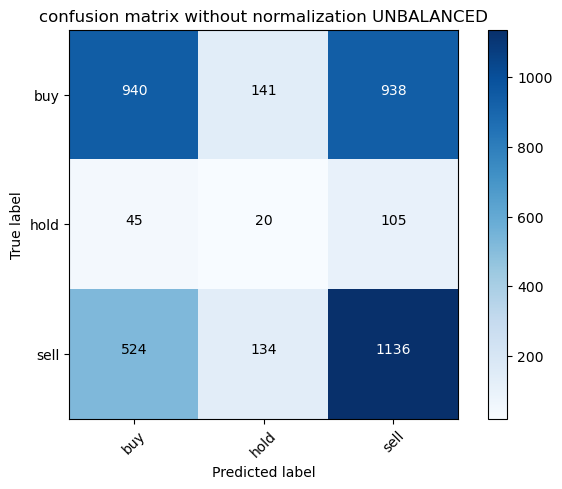

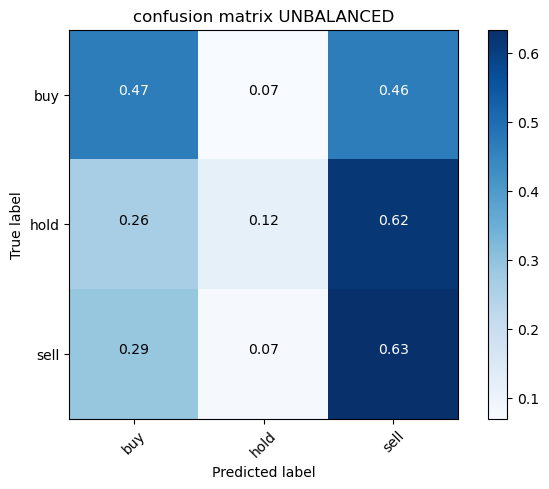

In [77]:
#### Results and Confusion matrices of the models
##UNBALANCED
print('UNBALANCED DATA SET\n')
print('Best score: {0: .4f}'.format(qda_grid_ns.best_score_))
print('train accuracy unbalanced: {0: .4f}'.format(qda_grid_ns.score(X_train_ns, y_train_ns)))
print('test accuracy undbalanced: {0: .4f}\n'.format(qda_grid_ns.score(X_test_ns, y_test_ns)))

# extract best params
extr_bp_qda_ns = qda_grid_ns.best_estimator_ 

# fit with best params
extr_bp_qda_ns.fit(X_train_ns, y_train_ns)

# Predict Classes
y_pred_qda_ns = extr_bp_qda_ns.predict(X_test_ns)

# Confusion Matrix
#print(metrics.confusion_matrix(y_test_ns, y_pred_qda_ns))

# Classification report
print(metrics.classification_report(y_test_ns, y_pred_qda_ns))


#construct a basic confusion matrix for our prediction
#confusion_matrix(y_test_ns, y_pred_qda_ns)
#calculate accuracy by hand


#defining a plot function for a fancy confusion matrix
plt.style.use('default')

    
# confusion matrix fct from above
cfm_matrix_qda_ns = confusion_matrix(y_test_ns, y_pred_qda_ns)
np.set_printoptions(precision = 2)
    
#plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_qda_ns, classes=['buy', 'hold', 'sell'], title = 'confusion matrix without normalization UNBALANCED')

#plot normaliized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_qda_ns, classes=['buy', 'hold', 'sell'], normalize = True, title = 'confusion matrix UNBALANCED')


BALANCED DATA SET

Best score:  0.4826
train accuracy balanced:  0.5198
test accuracy balanced:  0.4884



Pipeline(steps=[('Feature Selection',
                 SelectFromModel(estimator=RandomForestClassifier(),
                                 threshold='median')),
                ('scaler', StandardScaler()),
                ('qda', QuadraticDiscriminantAnalysis(tol=0.001))])

              precision    recall  f1-score   support

        -1.0       0.52      0.43      0.47      2019
         0.0       0.47      0.67      0.55      1770
         1.0       0.46      0.35      0.39      1794

    accuracy                           0.48      5583
   macro avg       0.48      0.48      0.47      5583
weighted avg       0.48      0.48      0.47      5583



<Figure size 640x480 with 0 Axes>

Confusion matrix , without normalization 
[[ 873  662  484]
 [ 322 1191  257]
 [ 485  687  622]]


<Figure size 640x480 with 0 Axes>

normalized confusion matrix
[[0.43 0.33 0.24]
 [0.18 0.67 0.15]
 [0.27 0.38 0.35]]


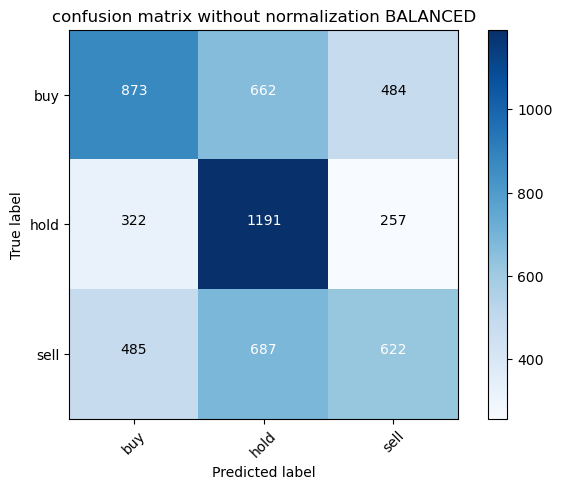

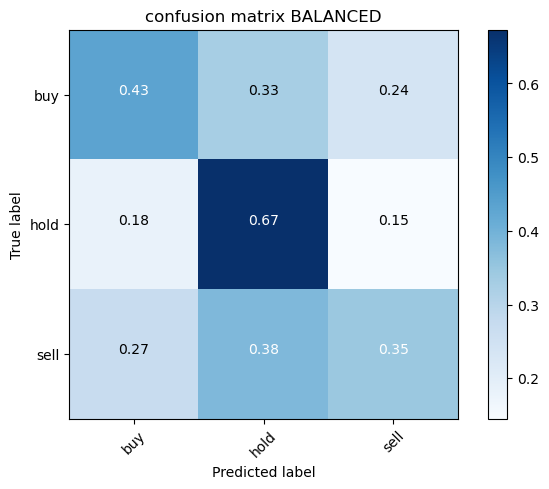

In [78]:
##BALANCED
print('BALANCED DATA SET\n')
print('Best score: {0: .4f}'.format(qda_grid.best_score_))
print('train accuracy balanced: {0: .4f}'.format(qda_grid.score(X_train, y_train)))
print('test accuracy balanced: {0: .4f}\n'.format(qda_grid.score(X_test, y_test)))

# extract best params
extr_bp_qda = qda_grid.best_estimator_ 

# fit with best params
extr_bp_qda.fit(X_train, y_train)

# Predict Classes
y_pred_qda = extr_bp_qda.predict(X_test)

# Confusion Matrix
#print(metrics.confusion_matrix(y_test, y_pred_qda))

# Classification report
print(metrics.classification_report(y_test, y_pred_qda))


#construct a basic confusion matrix for our prediction
#confusion_matrix(y_test, y_pred_qda)
#calculate accuracy by hand


#defining a plot function for a fancy confusion matrix
plt.style.use('default')

    
# confusion matrix fct from above
cfm_matrix_qda = confusion_matrix(y_test, y_pred_qda)
np.set_printoptions(precision = 2)
    
#plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_qda, classes=['buy', 'hold', 'sell'], title = 'confusion matrix without normalization BALANCED')

#plot normaliized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_qda, classes=['buy', 'hold', 'sell'], normalize = True, title = 'confusion matrix BALANCED')

In [79]:
test_scores.append(('QDA', extr_bp_qda.score(X_test, y_test)))

Again, we try to further optimize our model via bagging.

In [80]:
#### BAGGING the QDA with UNBALANCED data set
pipe_bagged_qda_ns = Pipeline([('Feature Selection', SelectFromModel(RandomForestClassifier(), threshold = 'median')),
                    ('scaler', StandardScaler()),
                    ('bagged_qda', BaggingClassifier(QDA(), random_state = 0))])

#param_grid_bagged_qda_ns = {
    #'bagged_qda__bootstrap': [True, False],
    #'bagged_qda__bootstrap_features': [True, False]}
    
#We got bootstrap = True and bootstrap_features = False.
param_grid_bagged_qda_ns = {
    'bagged_qda__bootstrap': [True],
    'bagged_qda__bootstrap_features': [False]}

bagged_qda_grid_ns = GridSearchCV(pipe_bagged_qda_ns, param_grid = param_grid_bagged_qda_ns, scoring = 'accuracy', cv = kFold, n_jobs = -1)
bagged_qda_grid_ns.fit(X_train_ns, y_train_ns)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('Feature Selection',
                                        SelectFromModel(estimator=RandomForestClassifier(),
                                                        threshold='median')),
                                       ('scaler', StandardScaler()),
                                       ('bagged_qda',
                                        BaggingClassifier(base_estimator=QuadraticDiscriminantAnalysis(),
                                                          random_state=0))]),
             n_jobs=-1,
             param_grid={'bagged_qda__bootstrap': [True],
                         'bagged_qda__bootstrap_features': [False]},
             scoring='accuracy')

In [81]:
#### BAGGING the QDA with BALANCED data set
pipe_bagged_qda = Pipeline([('Feature Selection', SelectFromModel(RandomForestClassifier(), threshold = 'median')),
                    ('scaler', StandardScaler()),
                    ('bagged_qda', BaggingClassifier(QDA(), random_state = 0))])

#param_grid_bagged_qda = {
    #'bagged_qda__bootstrap': [True, False],
    #'bagged_qda__bootstrap_features': [True, False]}

#We got bootstrap = True and bootstrap_features = False.
param_grid_bagged_qda = {
    'bagged_qda__bootstrap': [True],
    'bagged_qda__bootstrap_features': [False]}

bagged_qda_grid = GridSearchCV(pipe_bagged_qda, param_grid = param_grid_bagged_qda, scoring = 'accuracy', cv = kFold, n_jobs = -1)
bagged_qda_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('Feature Selection',
                                        SelectFromModel(estimator=RandomForestClassifier(),
                                                        threshold='median')),
                                       ('scaler', StandardScaler()),
                                       ('bagged_qda',
                                        BaggingClassifier(base_estimator=QuadraticDiscriminantAnalysis(),
                                                          random_state=0))]),
             n_jobs=-1,
             param_grid={'bagged_qda__bootstrap': [True],
                         'bagged_qda__bootstrap_features': [False]},
             scoring='accuracy')

UNBALANCED DATA SET

Best score:  0.5196
train accuracy unbalanced:  0.5600
test accuracy undbalanced:  0.5265



Pipeline(steps=[('Feature Selection',
                 SelectFromModel(estimator=RandomForestClassifier(),
                                 threshold='median')),
                ('scaler', StandardScaler()),
                ('bagged_qda',
                 BaggingClassifier(base_estimator=QuadraticDiscriminantAnalysis(),
                                   random_state=0))])

              precision    recall  f1-score   support

        -1.0       0.62      0.47      0.54      2019
         0.0       0.04      0.08      0.05       170
         1.0       0.52      0.61      0.56      1794

    accuracy                           0.52      3983
   macro avg       0.39      0.39      0.38      3983
weighted avg       0.55      0.52      0.53      3983



<Figure size 640x480 with 0 Axes>

Confusion matrix , without normalization 
[[ 958  177  884]
 [  42   14  114]
 [ 539  168 1087]]


<Figure size 640x480 with 0 Axes>

normalized confusion matrix
[[0.47 0.09 0.44]
 [0.25 0.08 0.67]
 [0.3  0.09 0.61]]


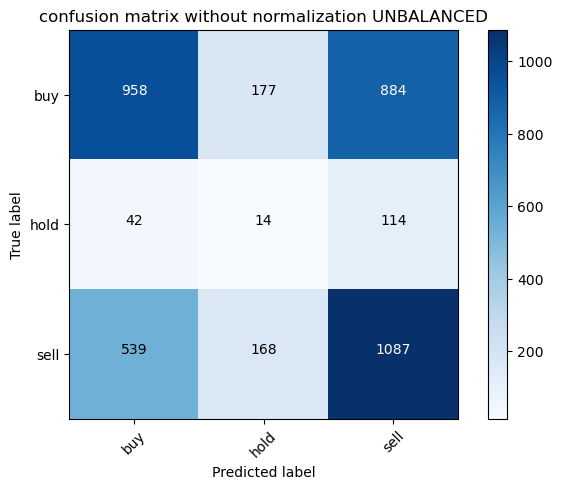

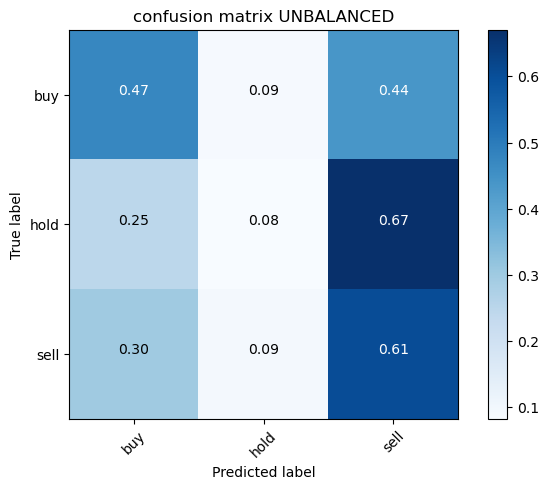

In [82]:
#### Results and Confusion Matrices of the bagged models
##UNBALANCED
print('UNBALANCED DATA SET\n')
print('Best score: {0: .4f}'.format(bagged_qda_grid_ns.best_score_))
print('train accuracy unbalanced: {0: .4f}'.format(bagged_qda_grid_ns.score(X_train_ns, y_train_ns)))
print('test accuracy undbalanced: {0: .4f}\n'.format(bagged_qda_grid_ns.score(X_test_ns, y_test_ns)))

# extract best params
extr_bp_bagged_qda_ns = bagged_qda_grid_ns.best_estimator_ 

# fit with best params
extr_bp_bagged_qda_ns.fit(X_train_ns, y_train_ns)

# Predict Classes
y_pred_bagged_qda_ns = extr_bp_bagged_qda_ns.predict(X_test_ns)

# Confusion Matrix
#print(metrics.confusion_matrix(y_test_ns, y_pred_bagged_qda_ns))

# Classification report
print(metrics.classification_report(y_test_ns, y_pred_bagged_qda_ns))


#construct a basic confusion matrix for our prediction
#confusion_matrix(y_test_ns, y_pred_bagged_qda_ns)
#calculate accuracy by hand


#defining a plot function for a fancy confusion matrix
plt.style.use('default')

    
# confusion matrix fct from above
cfm_matrix_bagged_qda_ns = confusion_matrix(y_test_ns, y_pred_bagged_qda_ns)
np.set_printoptions(precision = 2)
    
#plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_bagged_qda_ns, classes=['buy', 'hold', 'sell'], title = 'confusion matrix without normalization UNBALANCED')

#plot normaliized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_bagged_qda_ns, classes=['buy', 'hold', 'sell'], normalize = True, title = 'confusion matrix UNBALANCED')



BALANCED DATA SET

Best score:  0.4838
train accuracy balanced:  0.5150
test accuracy balanced:  0.4804



Pipeline(steps=[('Feature Selection',
                 SelectFromModel(estimator=RandomForestClassifier(),
                                 threshold='median')),
                ('scaler', StandardScaler()),
                ('bagged_qda',
                 BaggingClassifier(base_estimator=QuadraticDiscriminantAnalysis(),
                                   random_state=0))])

              precision    recall  f1-score   support

        -1.0       0.52      0.45      0.48      2019
         0.0       0.48      0.67      0.56      1770
         1.0       0.47      0.36      0.41      1794

    accuracy                           0.49      5583
   macro avg       0.49      0.49      0.48      5583
weighted avg       0.49      0.49      0.48      5583



<Figure size 640x480 with 0 Axes>

Confusion matrix , without normalization 
[[ 901  629  489]
 [ 346 1180  244]
 [ 500  648  646]]


<Figure size 640x480 with 0 Axes>

normalized confusion matrix
[[0.45 0.31 0.24]
 [0.2  0.67 0.14]
 [0.28 0.36 0.36]]


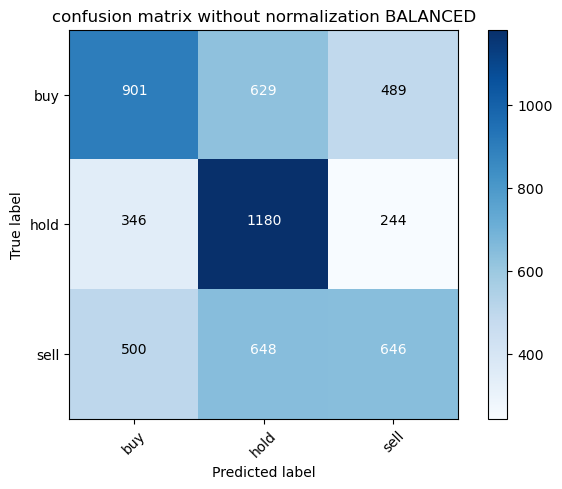

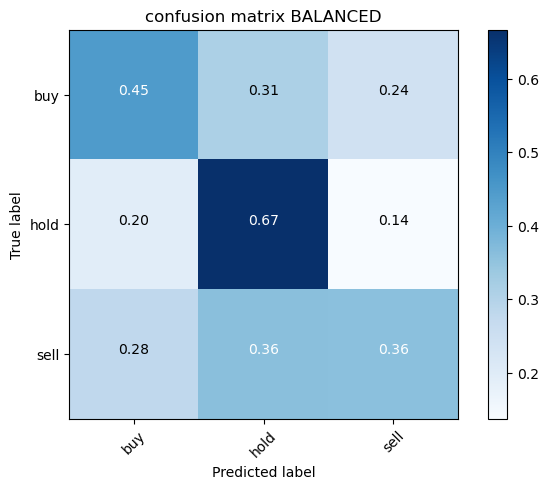

In [83]:
##BALANCED
print('BALANCED DATA SET\n')
print('Best score: {0: .4f}'.format(bagged_qda_grid.best_score_))
print('train accuracy balanced: {0: .4f}'.format(bagged_qda_grid.score(X_train, y_train)))
print('test accuracy balanced: {0: .4f}\n'.format(bagged_qda_grid.score(X_test, y_test)))

# extract best params
extr_bp_bagged_qda = bagged_qda_grid.best_estimator_ 

# fit with best params
extr_bp_bagged_qda.fit(X_train, y_train)

# Predict Classes
y_pred_bagged_qda = extr_bp_bagged_qda.predict(X_test)

# Confusion Matrix
#print(metrics.confusion_matrix(y_test, y_pred_bagged_qda))

# Classification report
print(metrics.classification_report(y_test, y_pred_bagged_qda))


#construct a basic confusion matrix for our prediction
#confusion_matrix(y_test, y_pred_bagged_qda)
#calculate accuracy by hand


#defining a plot function for a fancy confusion matrix
plt.style.use('default')

    
# confusion matrix fct from above
cfm_matrix_bagged_qda = confusion_matrix(y_test, y_pred_bagged_qda)
np.set_printoptions(precision = 2)
    
#plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_bagged_qda, classes=['buy', 'hold', 'sell'], title = 'confusion matrix without normalization BALANCED')

#plot normaliized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_bagged_qda, classes=['buy', 'hold', 'sell'], normalize = True, title = 'confusion matrix BALANCED')

In [84]:
test_scores.append(('QDA bagged', extr_bp_bagged_qda.score(X_test, y_test)))

#### Interpretation Quadratic Discriminant Analysis (unbalanced data set)

according to our model we have the following precisions:

##### whithout bagging
if we look at a buy, hold, sell worthy stock our model will recognize:

* a buy worthy stock 47 times out of 100
* a hold worthy stock 9 times out of 100
* a sell worthy stock 64 times out of 100

##### with bagging
if we look at a buy, hold, sell worthy stock our model will recognize:

* a buy worthy stock 48 times out of 100
* a hold worthy stock 11 times out of 100
* a sell worthy stock 61 times out of 100

this tells us that:
* as we already saw in previous models the recognition of hold worthy stocks is very poor if one uses the unbalanced data set
* for sell worthy stocks our model performs on a good level

some other interesting findings include:
* although the model performs better for sell worthy stocks than a naive classification we still have quite a lot of misclassifications
* the model did not really improve through bagging

#### Interpretation Linear Discriminant Analysis (balanced data set)
##### without bagging
if we look at a buy, hold, sell worthy stock our model will recognize:

* a buy worthy stock 43 times out of 100
* a hold worthy stock 67 times out of 100
* a sell worthy stock 36 times out of 100

##### with bagging
if we look at a buy, hold, sell worthy stock our model will recognize:

* a buy worthy stock 44 times out of 100
* a hold worthy stock 69 times out of 100
* a sell worthy stock 35 times out of 100

this tells us that:
* Our model perfroms good for hold worthy stocks
* Overall our model does not perform very well since we have many missclassifications
* especially for hold and sell worthy stocks our model nearly gives us any additional information if one compares it with the naive classification

some other interesting findings include:
* QDA did perform better with the unbalanced data set
* the model did improve improve very little through bagging

### 8.7 Support Vector Machines 

Since testing all parameter at once took way too much time, some steps were done manually. Finally only the best parameters were left in the code.

**Testing:** ->  (best parameters)

    Balanced:
    1. kernel=['linear', 'rbf', 'poly', 'sigmoid'], C=[1, 0.1], gamma=[0.1, 0.01]->  (rbf)
    2. kernel=[rbf], C=[10, 1, 0.1], gamma=[1, 0.1, 0.01] ->  (rbf, 1, 0.1) 
    3. kernel=[rbf], C=[2, 1, 0.1], gamma=[0.2, 0.1, 0.05] ->  (rbf, 1, 0.05) 
    4. kernel=[rbf], C=[1], gamma=[0.06, 0.04, 0.05] ->  (rbf, 1, 0.06) 
    5. kernel=[rbf], C=[1, 0.5, 0.3], gamma=[0.06] ->  (rbf, 0.5, 0.06) (lower C -> less overfitting)
    6. kernel=[rbf], C=[0.8], gamma=[0.06] ->  (rbf, 0.8, 0.06) (slightly more overfitting than 6 but better classification performance of "sell"

    Unbalanced:
    Version 6 without class_weight='balanced' and not upsampled data 

In [85]:
##### SVM Classifier
# BALANCED

# Hyperparamter tuning with grid search (partly manually)
pipe_svm = Pipeline([('feature_selection', SelectFromModel(RandomForestClassifier(), threshold='median')),
                     ('scaler', StandardScaler()),
                     ('svm', SVC(random_state=0, class_weight='balanced'))])

param_grid_svm = {'svm__C': [0.8], 
                  'svm__gamma': [0.06], 
                  'svm__kernel': ['rbf']}

grid_svm = GridSearchCV(estimator=pipe_svm, 
                        param_grid=param_grid_svm, 
                        scoring='accuracy',
                        cv=kFold, 
                        n_jobs=-1)

grid_svm.fit(X_train, y_train)

print('\nMean CV score of the best_estimator: {:.4f}'.format(grid_svm.best_score_))
print('Test score: {:.4f}'.format(grid_svm.score(X_test, y_test)))
print('Best parameters: {}'.format(grid_svm.best_params_))

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('feature_selection',
                                        SelectFromModel(estimator=RandomForestClassifier(),
                                                        threshold='median')),
                                       ('scaler', StandardScaler()),
                                       ('svm',
                                        SVC(class_weight='balanced',
                                            random_state=0))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.8], 'svm__gamma': [0.06],
                         'svm__kernel': ['rbf']},
             scoring='accuracy')


Mean CV score of the best_estimator: 0.7295
Test score: 0.7238
Best parameters: {'svm__C': 0.8, 'svm__gamma': 0.06, 'svm__kernel': 'rbf'}


In [107]:
%store grid_svm

Stored 'grid_svm' (GridSearchCV)


In [86]:
# extract best params
extr_bp_svm = grid_svm.best_estimator_ 

# fit with best params
extr_bp_svm.fit(X_train, y_train)

# Train and Test Score
print("Train score: {:.4f}".format(extr_bp_svm.score(X_train, y_train)))
print("Test score: {:.4f}".format(extr_bp_svm.score(X_test, y_test)))

Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier(),
                                 threshold='median')),
                ('scaler', StandardScaler()),
                ('svm',
                 SVC(C=0.8, class_weight='balanced', gamma=0.06,
                     random_state=0))])

Train score: 0.9497
Test score: 0.7249


              precision    recall  f1-score   support

        -1.0       0.61      0.71      0.66      2019
         0.0       0.96      0.99      0.98      1770
         1.0       0.60      0.47      0.53      1794

    accuracy                           0.72      5583
   macro avg       0.73      0.73      0.72      5583
weighted avg       0.72      0.72      0.72      5583

Absolut number of predictions for buy: 1413
Absolut number of predictions for hold: 1820
Absolut number of predictions for sell: 2350


<Figure size 640x480 with 0 Axes>

Confusion matrix , without normalization 
[[1442   24  553]
 [   9 1753    8]
 [ 899   43  852]]


<Figure size 640x480 with 0 Axes>

normalized confusion matrix
[[0.71 0.01 0.27]
 [0.01 0.99 0.  ]
 [0.5  0.02 0.47]]


0.32133261687264913

0.31703385276732937

0.3616335303600215

      PRECISION  RECALL
    0     0.614  0.714
    1     0.963  0.990
    2     0.603  0.475


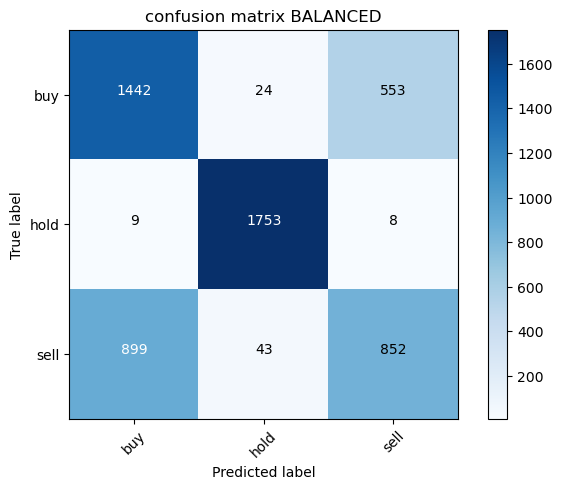

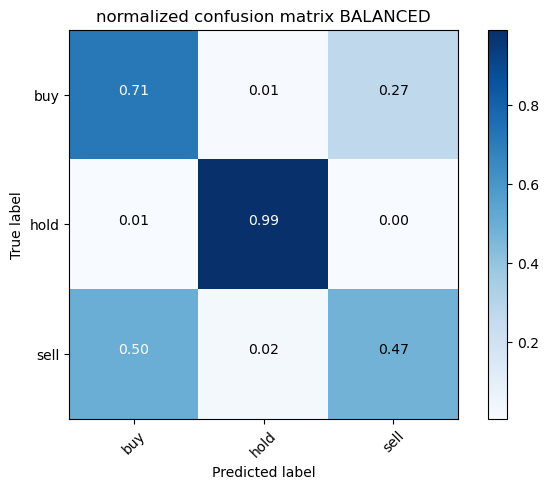

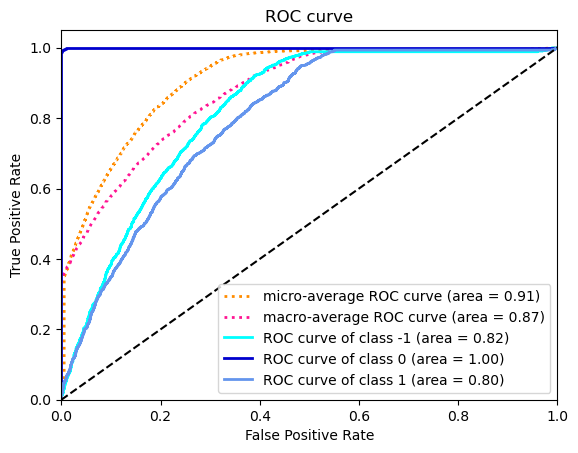

In [87]:
# Predict Classes
y_pred_svm = extr_bp_svm.predict(X_test)

# Classification report
print(metrics.classification_report(y_test, y_pred_svm))

# count the absolute number of predicitions for buy, hold and sell worthy stocks
print('Absolut number of predictions for buy: {}'.format(len(y_pred_svm[y_pred_svm==1])))
print('Absolut number of predictions for hold: {}'.format(len(y_pred_svm[y_pred_svm==0])))
print('Absolut number of predictions for sell: {}'.format(len(y_pred_svm[y_pred_svm==-1])))

# defining a plot function for a fancy confusion matrix
plt.style.use('default')
 
# confusion matrix fct from above
cfm_matrix_svm = confusion_matrix(y_test, y_pred_svm)
np.set_printoptions(precision = 2)

# plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_svm, classes=['buy', 'hold', 'sell'], title = 'confusion matrix BALANCED')

# plot normaliized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_svm, classes=['buy', 'hold', 'sell'], normalize = True, title = 'normalized confusion matrix BALANCED')

# true proportions of buy, hold and sell stock for our test sample
len(y_test[y_test == 1])/len(y_test)
len(y_test[y_test == 0])/len(y_test)
len(y_test[y_test == -1])/len(y_test)

# print precision and recall
for label in np.arange(0,3):
    if not label:
        print("      PRECISION  RECALL")
    print(f"{label:5d} {precision(label, cfm_matrix_svm):9.3f} {recall(label, cfm_matrix_svm):6.3f}")
    
# ROC Curve
plot_roc_curve(extr_bp_svm, X, y)

In [88]:
test_scores.append(('SVM', extr_bp_svm.score(X_test, y_test)))

In [89]:
##### SVM Classifier
# UNBALANCED

# Hyperparamter tuning with grid search (partly manually)
pipe_svm_ns = Pipeline([('feature_selection', SelectFromModel(RandomForestClassifier(), threshold='median')),
                     ('scaler', StandardScaler()),
                     ('svm', SVC(random_state=0))])

param_grid_svm_ns = {'svm__C': [0.8], 
                  'svm__gamma': [0.06], 
                  'svm__kernel': ['rbf']}

grid_svm_ns = GridSearchCV(estimator=pipe_svm_ns, 
                        param_grid=param_grid_svm_ns, 
                        scoring='accuracy',
                        cv=kFold, 
                        n_jobs=-1)

grid_svm_ns.fit(X_train_ns, y_train_ns)

print('\nMean CV score of the best_estimator: {:.4f}'.format(grid_svm_ns.best_score_))
print('Test score: {:.4f}'.format(grid_svm_ns.score(X_test_ns, y_test_ns)))
print('Best parameters: {}'.format(grid_svm_ns.best_params_))

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('feature_selection',
                                        SelectFromModel(estimator=RandomForestClassifier(),
                                                        threshold='median')),
                                       ('scaler', StandardScaler()),
                                       ('svm', SVC(random_state=0))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.8], 'svm__gamma': [0.06],
                         'svm__kernel': ['rbf']},
             scoring='accuracy')


Mean CV score of the best_estimator: 0.5957
Test score: 0.6073
Best parameters: {'svm__C': 0.8, 'svm__gamma': 0.06, 'svm__kernel': 'rbf'}


In [108]:
%store grid_svm_ns

Stored 'grid_svm_ns' (GridSearchCV)


In [90]:
# extract best params
extr_bp_svm_ns = grid_svm_ns.best_estimator_ 

# fit with best params
extr_bp_svm_ns.fit(X_train_ns, y_train_ns)

# Train and Test Score
print("Train score: {:.4f}".format(extr_bp_svm_ns.score(X_train_ns, y_train_ns)))
print("Test score: {:.4f}".format(extr_bp_svm_ns.score(X_test_ns, y_test_ns)))

Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier(),
                                 threshold='median')),
                ('scaler', StandardScaler()),
                ('svm', SVC(C=0.8, gamma=0.06, random_state=0))])

Train score: 0.8843
Test score: 0.6031


              precision    recall  f1-score   support

        -1.0       0.60      0.77      0.67      2019
         0.0       0.00      0.00      0.00       170
         1.0       0.61      0.47      0.53      1794

    accuracy                           0.60      3983
   macro avg       0.40      0.41      0.40      3983
weighted avg       0.58      0.60      0.58      3983

Absolut number of predictions for buy: 1379
Absolut number of predictions for hold: 0
Absolut number of predictions for sell: 2604


/Users/lukasdekker/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lukasdekker/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lukasdekker/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

Confusion matrix , without normalization 
[[1555    0  464]
 [ 102    0   68]
 [ 947    0  847]]


<Figure size 640x480 with 0 Axes>

normalized confusion matrix
[[0.77 0.   0.23]
 [0.6  0.   0.4 ]
 [0.53 0.   0.47]]


0.4504142606075822

0.042681395932714035

0.5069043434597037

      PRECISION  RECALL
    0     0.597  0.770
    1       nan  0.000
    2     0.614  0.472


<ipython-input-40-28ea05759623>:94: RuntimeWarning: invalid value encountered in long_scalars
  return confusion_matrix[label, label] / col.sum()


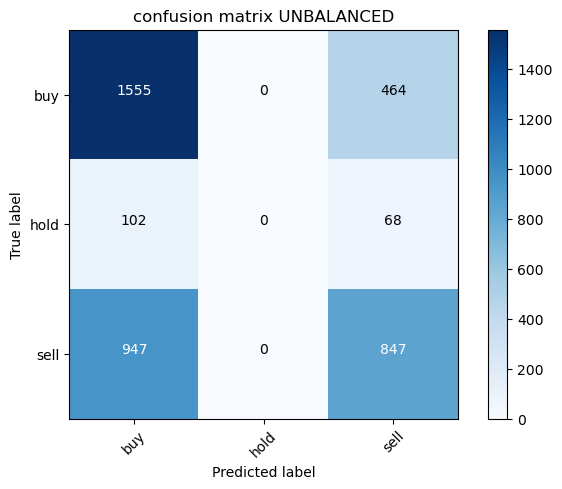

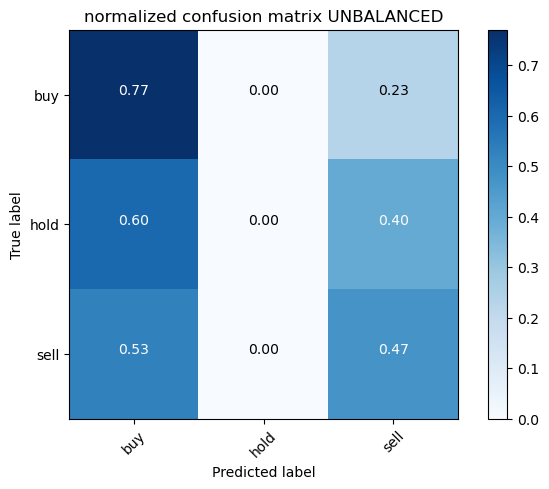

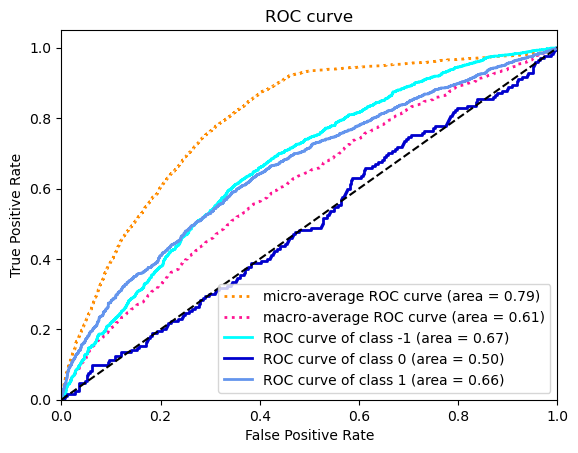

In [91]:
# Predict Classes
y_pred_svm_ns = extr_bp_svm_ns.predict(X_test_ns)

# Classification report
print(metrics.classification_report(y_test_ns, y_pred_svm_ns))

# count the absolute number of predicitions for buy, hold and sell worthy stocks
print('Absolut number of predictions for buy: {}'.format(len(y_pred_svm_ns[y_pred_svm_ns==1])))
print('Absolut number of predictions for hold: {}'.format(len(y_pred_svm_ns[y_pred_svm_ns==0])))
print('Absolut number of predictions for sell: {}'.format(len(y_pred_svm_ns[y_pred_svm_ns==-1])))

# defining a plot function for a fancy confusion matrix
plt.style.use('default')
 
# confusion matrix fct from above
cfm_matrix_svm_ns = confusion_matrix(y_test_ns, y_pred_svm_ns)
np.set_printoptions(precision = 2)

# plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_svm_ns, classes=['buy', 'hold', 'sell'], title = 'confusion matrix UNBALANCED')

# plot normaliized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_svm_ns, classes=['buy', 'hold', 'sell'], normalize = True, title = 'normalized confusion matrix UNBALANCED')

# true proportions of buy, hold and sell stock for our test sample
len(y_test_ns[y_test_ns == 1])/len(y_test_ns)
len(y_test_ns[y_test_ns == 0])/len(y_test_ns)
len(y_test_ns[y_test_ns == -1])/len(y_test_ns)

# print precision and recall
for label in np.arange(0,3):
    if not label:
        print("      PRECISION  RECALL")
    print(f"{label:5d} {precision(label, cfm_matrix_svm_ns):9.3f} {recall(label, cfm_matrix_svm_ns):6.3f}")
    
# ROC Curve
plot_roc_curve(extr_bp_svm_ns, X_ns, y_ns)

In [92]:
##### SVM Classifier 
# BALANCED
# WITHOUT FEATURE SELECTION

# Hyperparamter tuning with grid search (partly manually)
pipe_svm_nfs = Pipeline([('scaler', StandardScaler()),
                     ('svm', SVC(random_state=0, class_weight='balanced'))])

param_grid_svm_nfs = {'svm__C': [0.8], 
                  'svm__gamma': [0.06], 
                  'svm__kernel': ['rbf']}

grid_svm_nfs = GridSearchCV(estimator=pipe_svm_nfs, 
                        param_grid=param_grid_svm_nfs, 
                        scoring='accuracy',
                        cv=kFold, 
                        n_jobs=-1)

grid_svm_nfs.fit(X_train, y_train)

print('\nMean CV score of the best_estimator: {:.4f}'.format(grid_svm_nfs.best_score_))
print('Test score: {:.4f}'.format(grid_svm_nfs.score(X_test, y_test)))
print('Best parameters: {}'.format(grid_svm_nfs.best_params_))

# extract best params 
extr_bp_svm_nfs = grid_svm_nfs.best_estimator_ 

# fit with best params
extr_bp_svm_nfs.fit(X_train, y_train)

# Train and Test Score
print("\nTrain score: {:.4f}".format(extr_bp_svm_nfs.score(X_train, y_train)))
print("Test score: {:.4f}".format(extr_bp_svm_nfs.score(X_test, y_test)))

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm',
                                        SVC(class_weight='balanced',
                                            random_state=0))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.8], 'svm__gamma': [0.06],
                         'svm__kernel': ['rbf']},
             scoring='accuracy')


Mean CV score of the best_estimator: 0.7150
Test score: 0.7141
Best parameters: {'svm__C': 0.8, 'svm__gamma': 0.06, 'svm__kernel': 'rbf'}


Pipeline(steps=[('scaler', StandardScaler()),
                ('svm',
                 SVC(C=0.8, class_weight='balanced', gamma=0.06,
                     random_state=0))])


Train score: 0.9944
Test score: 0.7141


In [109]:
%store extr_bp_svm_nfs

Stored 'extr_bp_svm_nfs' (Pipeline)


In [ ]:
test_scores.append(('SVM (without feature selection)', extr_bp_svm_nfs.score(X_test, y_test)))

#### Interpretation SVM 

**Balanced data set:**  
Mean CV score of the best_estimator: 0.7273  
grid_svm Test score: 0.7252   
grid_svm.best_estimator_  Train score: 0.9437  
grid_svm.best_estimator_  Test score: 0.7254  


- Version 6 with the parameters kernel=rbf, C=0.8 and gamma=0.05 got the highest performance
- Better score on train set than on test set implies rather high variance of the model (overfitting)
- To reduce overfitting C was lowered to make the decision surface smoother because a high C value aims to classify all training examples correctly.
- Model misses the prediction 'sell' for 52 (49+3) out of 100 samples -> quite bad for such an investment classification task
- If we look at a buy, hold, sell worthy stocks, our model will recognize:
    - a buy worthy stock 70 times out of 100
    - a hold worthy stock 99 times out of 100
    - a sell worthy stock 49 times out of 100
- this tells us that:
    - our model performs medium for buy worthy stocks
    - our model recognizes hold worthy stocks pretty well
    - our model performs very badly for sell worhty stocks (bad characteristic for such a classification task)
- ROC curve tells us that this model works perfectly for the class hold however less well for buy and sell (better than unbalanced)


**Unbalanced data set:**  
Mean CV score of the best_estimator: 0.5967  
grid_svm Test score: 0.6083  
grid_svm_ns.best_estimator_  Train score: 0.8894  
grid_svm_ns.best_estimator_  Test score: 0.6076    


- Unbalanced dataset performed worse and is less accurate
- We see that balancing the data set helped the model to recognize the upsampled class "hold" way better (with unbalanced data the hold worthy stocks have (almost) always been misclassified
- If we look at a buy, hold, sell worthy stocks, our model will recognize:
    - a buy worthy stock 78 times out of 100
    - a hold worthy stock 0 times out of 100
    - a sell worthy stock 47 times out of 100
- ROC curve tells us that this model doesn't work at all for the class hold and also very badly for buy and sell
    
    
**Bagging:**  
To reduce overfitting and improve the performance the bagging method was tested as well. However, the overfitting increased and the perfromance decreased. Therefore, it was not included in the final code. 

### 8.8 k-Nearest Neighbors

Since testing all parameter at once took way too much time, some steps were done manually. Finally only the best parameters were left in the code.


‘uniform’ : uniform weights. All points in each neighborhood are weighted equally -> scored always better


**Testing:** ->  (best parameters)

    Balanced:
    1. n_neighbors=[5,20], p=[1,2], leaf_size=[30,50], weights=['uniform', 'distance'] ->  (5, 1, 30, uniform) 
    2. n_neighbors=[5,3], p=[1,2], leaf_size=[40,30], weights=['uniform', 'distance'] ->  (3, 2, 40, uniform)
    3. n_neighbors=[5,3], p=[1,2], leaf_size=[40,50], weights=['uniform', 'distance'] ->  (3, 2, 50, uniform) 
    4. n_neighbors=[1,3], p=[2], leaf_size=[70,50], weights=['uniform'] ->  (1, 2, 70, uniform) 
    5. n_neighbors=[1], p=[2], leaf_size=[80, 100], weights=['uniform'] ->  (1, 2, 80, uniform) 
    --> with n_neighbors=1 high overfitting!
    6. n_neighbors=[3], p=[2], leaf_size=[100], weights=['uniform'] ->  less overfitting but lower test score
    7. n_neighbors=[5], p=[2], leaf_size=[100], weights=['uniform'] ->  less overfitting but lower test score


    Unbalanced:
    Version 7 without using the upsampled data 

In [96]:
##### KNN Classifier
# BALANCED

# Hyperparamter tuning with grid search (partly manually)
pipe_knn = Pipeline([('feature_selection', SelectFromModel(RandomForestClassifier(), threshold='median')),
                     ('scaler', StandardScaler()),
                     ('knn', KNeighborsClassifier())])

param_grid_knn = [{'knn__leaf_size': [100], 
                   'knn__n_neighbors': [5], 
                   'knn__p': [2],
                   'knn__weights': ['uniform']}]

grid_knn = GridSearchCV(estimator=pipe_knn, 
                        param_grid=param_grid_knn, 
                        scoring='accuracy',
                        cv=kFold, 
                        n_jobs=1)

grid_knn = grid_knn.fit(X_train, y_train)

print('Mean CV score of the best_estimator: {:.4f}'.format(grid_knn.best_score_))
print('Test score: {:.4f}'.format(grid_knn.score(X_test, y_test)))
print('Best parameters: {}'.format(grid_knn.best_params_))

Mean CV score of the best_estimator: 0.6191
Test score: 0.6332
Best parameters: {'knn__leaf_size': 100, 'knn__n_neighbors': 5, 'knn__p': 2, 'knn__weights': 'uniform'}


In [97]:
# extract best params
extr_bp_knn = grid_knn.best_estimator_ 

# fit with best params
extr_bp_knn.fit(X_train, y_train)

# Train and Test Score
print("Train score: {:.4f}".format(extr_bp_knn.score(X_train, y_train)))
print("Test score: {:.4f}".format(extr_bp_knn.score(X_test, y_test)))

Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier(),
                                 threshold='median')),
                ('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(leaf_size=100))])

Train score: 0.7483
Test score: 0.6384


              precision    recall  f1-score   support

        -1.0       0.59      0.51      0.55      2019
         0.0       0.74      1.00      0.85      1770
         1.0       0.53      0.43      0.48      1794

    accuracy                           0.64      5583
   macro avg       0.62      0.65      0.62      5583
weighted avg       0.62      0.64      0.62      5583

Absolut number of predictions for buy: 1456
Absolut number of predictions for hold: 2388
Absolut number of predictions for sell: 1739


<Figure size 640x480 with 0 Axes>

Confusion matrix , without normalization 
[[1028  312  679]
 [   3 1763    4]
 [ 708  313  773]]


<Figure size 640x480 with 0 Axes>

normalized confusion matrix
[[0.51 0.15 0.34]
 [0.   1.   0.  ]
 [0.39 0.17 0.43]]


0.32133261687264913

0.31703385276732937

0.3616335303600215

      PRECISION  RECALL
    0     0.591  0.509
    1     0.738  0.996
    2     0.531  0.431


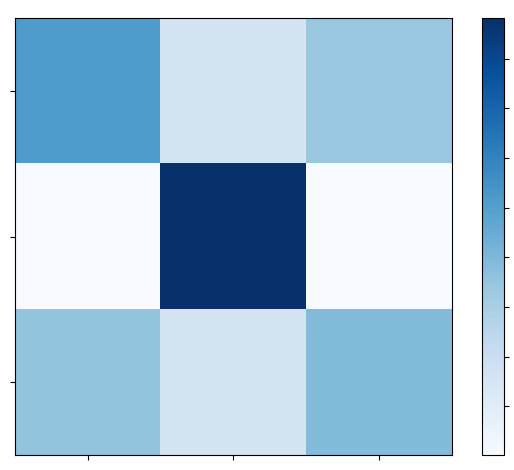

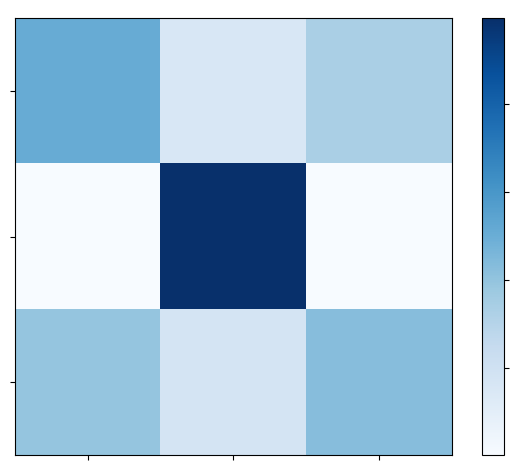

In [112]:
# Predict Classes
y_pred_knn = extr_bp_knn.predict(X_test)

# Classification report
print(metrics.classification_report(y_test, y_pred_knn))

#count the absolute number of predicitions for buy, hold and sell worthy stocks
print('Absolut number of predictions for buy: {}'.format(len(y_pred_knn[y_pred_knn==1])))
print('Absolut number of predictions for hold: {}'.format(len(y_pred_knn[y_pred_knn==0])))
print('Absolut number of predictions for sell: {}'.format(len(y_pred_knn[y_pred_knn==-1])))

#defining a plot function for a fancy confusion matrix
plt.style.use('default')

# confusion matrix fct from above
cfm_matrix_knn = confusion_matrix(y_test, y_pred_knn)
np.set_printoptions(precision = 2)

#plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_knn, classes=['buy', 'hold', 'sell'], title = 'confusion matrix BALANCED')

#plot normaliized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_knn, classes=['buy', 'hold', 'sell'], normalize = True, title = 'normalized confusion matrix BALANCED')

#true proportions of buy, hold and sell stock for our test sample
len(y_test[y_test == 1])/len(y_test)
len(y_test[y_test == 0])/len(y_test)
len(y_test[y_test == -1])/len(y_test)

#print precision and recall
for label in np.arange(0,3):
    if not label:
        print("      PRECISION  RECALL")
    print(f"{label:5d} {precision(label, cfm_matrix_knn):9.3f} {recall(label, cfm_matrix_knn):6.3f}")


In [99]:
test_scores.append(('KNN', extr_bp_knn.score(X_test, y_test)))

In [111]:
##### KNN Classifier
# UNBALANCED

# Hyperparamter tuning 
pipe_knn_ns = Pipeline([('feature_selection', SelectFromModel(RandomForestClassifier(), threshold='median')),
                     ('scaler', StandardScaler()),
                     ('knn', KNeighborsClassifier())])

param_grid_knn_ns = [{'knn__leaf_size': [100], 
                   'knn__n_neighbors': [5], 
                   'knn__p': [2],
                   'knn__weights': ['uniform']}]

grid_knn_ns = GridSearchCV(estimator=pipe_knn_ns, 
                        param_grid=param_grid_knn_ns, 
                        scoring='accuracy',
                        cv=kFold, 
                        n_jobs=-1)

grid_knn_ns = grid_knn_ns.fit(X_train_ns, y_train_ns)

print('Mean CV score of the best_estimator: {:.4f}'.format(grid_knn_ns.best_score_))
print('Test score: {:.4f}'.format(grid_knn_ns.score(X_test_ns, y_test_ns)))
print('Best parameters: {}'.format(grid_knn_ns.best_params_))

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}

In [ ]:
# extract best params
extr_bp_knn_ns = grid_knn_ns.best_estimator_ 

# fit with best params
extr_bp_knn_ns.fit(X_train_ns, y_train_ns)

# Train and Test Score
print("Train score: {:.4f}".format(extr_bp_knn_ns.score(X_train_ns, y_train_ns)))
print("Test score: {:.4f}".format(extr_bp_knn_ns.score(X_test_ns, y_test_ns)))

In [ ]:
# Predict Classes
y_pred_knn_ns = extr_bp_knn_ns.predict(X_test_ns)

# Classification report
print(metrics.classification_report(y_test_ns, y_pred_knn_ns))

#count the absolute number of predicitions for buy, hold and sell worthy stocks
print('Absolut number of predictions for buy: {}'.format(len(y_pred_knn_ns[y_pred_knn_ns==1])))
print('Absolut number of predictions for hold: {}'.format(len(y_pred_knn_ns[y_pred_knn_ns==0])))
print('Absolut number of predictions for sell: {}'.format(len(y_pred_knn_ns[y_pred_knn_ns==-1])))

#defining a plot function for a fancy confusion matrix
plt.style.use('default')

# confusion matrix fct from above
cfm_matrix_knn_ns = confusion_matrix(y_test_ns, y_pred_knn_ns)
np.set_printoptions(precision = 2)

#plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_knn_ns, classes=['buy', 'hold', 'sell'], title = 'confusion matrix UNBALANCED')

#plot normaliized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_knn_ns, classes=['buy', 'hold', 'sell'], normalize = True, title = 'normalized confusion matrix UNBALANCED')

#true proportions of buy, hold and sell stock for our test sample
len(y_test_ns[y_test_ns == 1])/len(y_test_ns)
len(y_test_ns[y_test_ns == 0])/len(y_test_ns)
len(y_test_ns[y_test_ns == -1])/len(y_test_ns)

#print precision and recall
for label in np.arange(0,3):
    if not label:
        print("      PRECISION  RECALL")
    print(f"{label:5d} {precision(label, cfm_matrix_knn_ns):9.3f} {recall(label, cfm_matrix_knn_ns):6.3f}")

#### Interpretation KNN 

**Balanced data set:**  
Mean CV score of the best_estimator: 0.6252  
grid_knn Test score: 0.6328  
grid_knn.best_estimator_  Train score: 0.7457  
grid_knn.best_estimator_  Test score: 0.6337 


- Version 7 with the parameters leaf_size=100, n_neighbors=5, p=2 and weights='uniform' got the best performance and the highest recall for the class 'sell'. 
- Better score on train set than on test set implies rather high variance of the model (overfitting)
- Model misses the prediction 'sell' for 57 (39+18) out of 100 samples -> quite bad for such an investment classification task
- If we look at a buy, hold, sell worthy stocks, our model will recognize:
    - a buy worthy stock 49 times out of 100
    - a hold worthy stock 100 times out of 100
    - a sell worthy stock 43 times out of 100
- this tells us that:
    - our model performs badly for buy worthy stocks
    - our model recognizes the hold worthy stocks perfectly
    - our model performs badly for sell worhty stocks 


**Unbalanced data set:**  
Mean CV score of the best_estimator: 0.5398  
grid_knn_ns Test score: 0.5483   
grid_knn_ns.best_estimator_  Train score: 0.6903  
grid_knn_ns.best_estimator_  Test score: 0.5539  


- Unbalanced performed worse and is less accurate
- We see that balancing the data set helped the model to recognize the upsampled class "hold" way better (with unbalanced data the hold worthy stocks have (almost) always been misclassified
- However "buy" and "sell" worthy stocks are more often recognized with the unbalanced data set
- If we look at a buy, hold, sell worthy stocks, our model will recognize:
    - a buy worthy stock 62 times out of 100
    - a hold worthy stock 1 times out of 100
    - a sell worthy stock 53 times out of 100
    
    
**Bagging:**  
To reduce overfitting and improve the performance the bagging method was tested as well. However, the overfitting increased and the perfromance decreased. Therefore, it was not included in the final code. 

### 8.9 Simple Neural Network (Multi Layer Perceptron)

In [ ]:
#### MLP with UNBALANCED data set

pipe_mlp_ns = Pipeline([('Feature Selection', SelectFromModel(RandomForestClassifier(), threshold = 'median')),
                    ('scaler', StandardScaler()),
                    ('MLP', MLPClassifier(random_state = 0,activation = 'relu', solver = 'lbfgs', max_iter =1000))])

param_grid_mlp_ns = {'MLP__alpha': [0.0001],
                  'MLP__max_fun': [5000]}

mlp_grid_ns = GridSearchCV(pipe_mlp_ns, param_grid = param_grid_mlp_ns,scoring = 'accuracy', cv = kFold, n_jobs=-1)
mlp_grid_ns.fit(X_train_ns, y_train_ns)

In [ ]:
#### MLP with BALANCED data set

pipe_mlp = Pipeline([('Feature Selection', SelectFromModel(RandomForestClassifier(), threshold = 'median')),
                    ('scaler', StandardScaler()),
                    ('MLP', MLPClassifier(random_state = 0,activation = 'relu', solver = 'lbfgs', max_iter = 1000))])

#In the first optimization we got activation = 'relu' and solver = 'lbfgs'.

#param_grid_mlp2 = {'MLP__alpha': [0.000001,0.000005,0.00001],
                  #'MLP__max_fun': [7500,10000,12500]}
#From this optimization we got the 0.00001 as the best value for alpha and 7500 as the best value for max_fun. 
#Now we can optimize again:

#param_grid_mlp2 = {'MLP__alpha': [0.00001, 0.0001],
                  #'MLP__max_fun': [2500, 7500]}
#We got alpha = 0.0001 and max_fun = 7500. We optimize again:

#param_grid_mlp2 = {'MLP__alpha': [0.0001, 0.001],
                  #'MLP__max_fun': [5000, 7500]}
#From this optimization we got alpha = 0.0001 and max_fun = 5000. We can use this model. 
#Since the model failed to converge we need to increase max_iter

param_grid_mlp = {'MLP__alpha': [0.0001],
                  'MLP__max_fun': [5000]}
#We also tested the parameter hidden_layer_sizes but ended up with the default value.

mlp_grid = GridSearchCV(pipe_mlp, param_grid = param_grid_mlp,scoring = 'accuracy', cv = kFold, n_jobs=-1)
mlp_grid.fit(X_train, y_train)

In [ ]:
#### Results and Confusion matrices for MLP Classifier

##UNBALANCED
print('UNBALANCED DATA SET\n')
print('Best score: {0: .4f}'.format(mlp_grid_ns.best_score_))
print('train accuracy unbalanced: {0: .4f}'.format(mlp_grid_ns.score(X_train_ns, y_train_ns)))
print('test accuracy undbalanced: {0: .4f}\n'.format(mlp_grid_ns.score(X_test_ns, y_test_ns)))

# extract best params
extr_bp_mlp_ns = mlp_grid_ns.best_estimator_ 

# fit with best params
extr_bp_mlp_ns.fit(X_train_ns, y_train_ns)

# Predict Classes
y_pred_mlp_ns = extr_bp_mlp_ns.predict(X_test_ns)

# Confusion Matrix
#print(metrics.confusion_matrix(y_test_ns, y_pred_mlp_ns))

# Classification report
print(metrics.classification_report(y_test_ns, y_pred_mlp_ns))


#construct a basic confusion matrix for our prediction
#confusion_matrix(y_test_ns, y_pred_mlp_ns)
#calculate accuracy by hand


#defining a plot function for a fancy confusion matrix
plt.style.use('default')

    
# confusion matrix fct from above
cfm_matrix_mlp_ns = confusion_matrix(y_test_ns, y_pred_mlp_ns)
np.set_printoptions(precision = 2)
    
#plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_mlp_ns, classes=['buy', 'hold', 'sell'], title = 'confusion matrix without normalization UNBALANCED')

#plot normaliized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_mlp_ns, classes=['buy', 'hold', 'sell'], normalize = True, title = 'confusion matrix UNBALANCED')




In [ ]:
##BALANCED
print('BALANCED DATA SET\n')
print('Best score: {0: .4f}'.format(mlp_grid.best_score_))
print('train accuracy balanced: {0: .4f}'.format(mlp_grid.score(X_train, y_train)))
print('test accuracy balanced: {0: .4f}\n'.format(mlp_grid.score(X_test, y_test)))

# extract best params
extr_bp_mlp = mlp_grid.best_estimator_ 

# fit with best params
extr_bp_mlp.fit(X_train, y_train)

# Predict Classes
y_pred_mlp = extr_bp_mlp.predict(X_test)

# Confusion Matrix
#print(metrics.confusion_matrix(y_test, y_pred_mlp))

# Classification report
print(metrics.classification_report(y_test, y_pred_mlp))


#construct a basic confusion matrix for our prediction
#confusion_matrix(y_test, y_pred_mlp)
#calculate accuracy by hand


#defining a plot function for a fancy confusion matrix
plt.style.use('default')

    
# confusion matrix fct from above
cfm_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)
np.set_printoptions(precision = 2)
    
#plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_mlp, classes=['buy', 'hold', 'sell'], title = 'confusion matrix without normalization BALANCED')

#plot normaliized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix_mlp, classes=['buy', 'hold', 'sell'], normalize = True, title = 'confusion matrix BALANCED')

In [ ]:
#### MLP with BALANCED data set -> handling overfitting with bigger alpha

pipe_mlp2 = Pipeline([('Feature Selection', SelectFromModel(RandomForestClassifier(), threshold = 'median')),
                    ('scaler', StandardScaler()),
                    ('MLP', MLPClassifier(random_state = 0,activation = 'relu', solver = 'lbfgs', max_iter = 1000))])

#We set our alpha high in order to prevent from overfitting alpha = 5.0:
    #best score: 0.6888
    #train accuracy: 0.8587
    #test accuracy: 0.6975
#alpha = 10.0:
    #best score: 0.6888
    #train accuracy: 0.8442
    #test accuracy: 0.6887
    
param_grid_mlp2 = {'MLP__alpha': [5.0],
                  'MLP__max_fun': [5000]}
#We also tested the parameter hidden_layer_sizes but ended up with the default value.

mlp_grid2 = GridSearchCV(pipe_mlp2, param_grid = param_grid_mlp2,scoring = 'accuracy', cv = kFold, n_jobs=-1)
mlp_grid2.fit(X_train, y_train)

In [ ]:
print('BALANCED DATA SET\n')
print('Best score: {0: .4f}'.format(mlp_grid2.best_score_))
print('train accuracy balanced: {0: .4f}'.format(mlp_grid2.score(X_train, y_train)))
print('test accuracy balanced: {0: .4f}\n'.format(mlp_grid2.score(X_test, y_test)))

extr_bp_mlp2 = mlp_grid2.best_estimators_

test_scores.append(('MLP2', extr_bp_mlp2.score(X_test, y_test)))

#### Interpretation Multi Layer Perceptron
##### Unbalanced
if we look at a buy, hold, sell worthy stock our model will recognize:

* a buy worthy stock 59 times out of 100
* a hold worthy stock 1 time out of 100
* a sell worthy stock 54 times out of 100


##### Balanced
if we look at a buy, hold, sell worthy stock our model will recognize:

* a buy worthy stock 57 times out of 100
* a hold worthy stock 100 times out of 100
* a sell worthy stock 51 times out of 100

this tells us that:
* Our model perfroms medium on both datasets classifying buy and sell worthy stocks
* Our model perfroms very poor while classifying hold stocks if we use the unbalanced data set. If we use the balanced dataset, our model performs extremely good in classifying hold worthy stocks.

some other interesting findings include:
* Our model perfroms much better on the balanced dataset since the hold worthy stocks get recognised much better. 
* If we only look at the buy and sell worthy stocks the type of the data set is not very important.
* It looks like we have some overfitting because the model perfroms much better on the training set than on the test set. By increasing alpha, we can add a penalty for overfitting. We will try to deal with the overfitting in the following section.

In [ ]:
#### MLP with BALANCED data set -> handling overfitting via bagging classifier


pipe_mlp_bagged = Pipeline([('Feature Selection', SelectFromModel(RandomForestClassifier(), threshold = 'median')),
                    ('scaler', StandardScaler()),
                    ('MLP_bagged', BaggingClassifier(MLPClassifier(random_state = 0,activation = 'relu', solver = 'lbfgs', max_iter = 1000, alpha = 5.0, max_fun = 5000), random_state = 0))])

#param_grid_bagged_mlp = {
    #'MLP_bagged__bootstrap': [True, False], #default: True
    #'MLP_bagged__bootstrap_features': [True, False],#default: False
    #'MLP_bagged__n_estimators': [5,10,20]}#default: 10

#Best was bootstrap = False, bootstrap_features = True and n_estimators = 20. 
#Best score:  0.7447, train accuracy balanced:  0.8359, test accuracy balanced:  0.7423. We optimize again:

#param_grid_bagged_mlp = {
    #'MLP_bagged__bootstrap': [False], #default: True
    #'MLP_bagged__bootstrap_features': [True],#default: False
    #'MLP_bagged__n_estimators': [20, 30, 40]}#default: 10

#Best was n_estimator = 40

param_grid_bagged_mlp = {
    'MLP_bagged__bootstrap': [False], #default: True
    'MLP_bagged__bootstrap_features': [True], #default: False
    'MLP_bagged__n_estimators': [40]} #default: 10

bagged_mlp_grid = GridSearchCV(pipe_mlp_bagged, param_grid = param_grid_bagged_mlp, scoring = 'accuracy', cv = kFold, n_jobs = -1)
bagged_mlp_grid.fit(X_train, y_train)

In [ ]:
extr_bp_bagged_mlp = bagged_mlp_grid.best_estimators_

test_scores.append(('MLP bagged', extr_bp_bagged_mlp.score(X_test, y_test)))

## 9. Overall Results

In [ ]:
from matplotlib import cm
from matplotlib.colors import Normalize


test_scores = sorted(test_scores, key = lambda tup:tup[1])
x_plot = [x for y,x in test_scores]
y_plot = [y for y,x in test_scores]

my_cmap = cm.get_cmap('viridis_r')
my_norm = Normalize(vmin = 0, vmax = 1)

plt.barh(y_plot, x_plot, color=my_cmap(my_norm(x_plot)))
plt.xlabel('Test Scores')
plt.ylabel('Model')
plt.title('Comparison of Test Scores with Balanced Data Set')
plt.show()